In [1]:
## Catálogo das Abordagens
#  A1: Cadastro
#  A2: Medidas
#      A2.1: Medidas Importantes
#      A2.2: Select KBeast
#  A3: Estatística
#  A4: Doenças
#      A4.1: Select KBest
#  A5: Doenças sem Hipotensão e Normotenso
#  A6: Escolho Doença
#  A7: Categorias
#  A8: Extratificação Sexo Masculino
#  A9: Extratificação Sexo Feminino
#  A10: Sistólicas
#  A11: Diastólicas
#  A12: Medidas Mais Importantes

In [2]:
#bibliotecas pandas de leitura de arquivos
import pandas as pd
#biblioteca do kmeans
from sklearn.cluster import KMeans
import numpy as np
#avaliar classificacao cluster
#from sklearn.metrics.cluster import adjusted_rand_score
#visualizar graficos
import matplotlib.pyplot as plt
#caracter 
import re
#countar os itens de uma lista
from collections import Counter
#separar treino, teste, validação
from sklearn.model_selection import train_test_split
# métricas de avaliação do K-Means
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
# Método Silhouette
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import math
from sklearn import svm
# AIX - Explanability
import lime
from lime import lime_tabular

from IPython.display import Image
from pathlib import Path


#from sklearn_extra.cluster import KMedoids

In [3]:
# Definição de diretórios e Disco de leitura dos arquivos (Desktop ou Notebook) 
config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIR_BASE = DIR_PREFIXO / "Projeto_PA" / "dataset_modificado"
DIR_KMEANS = DIRETORIO_PRINCIPAL / "KMeansRandom"


In [4]:
#leitura do dataset completo com dados cadastrais, medidas e estatísticas

dataset = pd.read_csv(DIR_BASE / "pacientes_completos_tratados.csv",sep=';', encoding="Latin1")
dataset_apos_tratamento = dataset

#dataset = dataset.drop ("Unnamed: 0", axis=1)
#for i in dataset.columns:
#    print(repr(i))
#

In [5]:
dataset

numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19145                 21786      1972-11-25       1   47.0   75.0    165   
19146                 21787      1970-10-19       1   49.0   90.0    183   
19147                 21788      1985-03-15       0   35.0   93.0    167   
19148                 21792      1952-04-21       0   68.0   64.0    160   
19149                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  sist 9:00  sist 9:15  ...  \
0      33.2  2018-09-10 12:25:23      105.0      108.0  ...   
1      29.4  2018-12-26 07:39:41      103.0      114.0  ...   
2      25.8  2018-12-26 08:06:19      147.0      148.0  ...   
3      24.2  2018-12-26 08:19:06      140.0      139.0  ...   
4      40.6  2018-12-26 08:26:59      113.0      110.0  ...   
...     ...                  ...        ...        ...  ...   
19145  27.5  2020-09-10 16:03:08      163.0      198.0  ...   
19146  26.9  2020-09-10 16:21:02      114.0      120.0  ...   
19147  33.3  2020-09-10 16:44:53      107.0      110.0  ...   
19148  25.0  2020-09-10 17:25:50       94.0      107.0  ...   
19149  30.9  2020-09-10 17:42:01      111.0      104.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19145                      116.0               12224.5                 9265.0   
19146                       85.0               10970.0                 6819.0   
19147                       62.0                9245.0                 4935.5   
19148                       68.0                8989.5                 5660.0   
19149                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19145          2439.0             474.5                18.66   
19146          3319.0             738.0                17.22   
19147          3556.0             713.5                14.36   
19148          2815.5             460.0                14.14   
19149          2400.5             612.0                13.92   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                     11.36               11                34   
1                      6.65                9                23   
2                     13.01               19                19   
3                     10.34               21                 9   
4                     12.79               10                11   
...                     ...              ...               ...   
19145                 14.80               49                60   
19146                 13.67               32                27   
1

In [6]:
#!pip install scikit-learn-extra

In [7]:
############################### FUNÇÕES ##########################################

#Funções para calcular o melhor numero de cluster(grupos) que seu dataset gerar

def calculate_wcss(data):
    """
    Calcula a soma dos quadrados intra-clusters para 19
    quantidades de clusters, iniciando com o mínimo de 2 clusters
    
    Parametros
    ----------
    data : DataFrame
        conjunto de dados para fazer o `.fit()` do KMeans

    
    Returns
    -------
    wcss : lista contendo os valores de soma de quadrados intra-cluster
    """
    from sklearn.cluster import KMeans
    wcss = []
    for n in range(2, 21):
        kmeans = KMeans(n_clusters=n, random_state=10)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula a maior distância entre os pontos que marcam as 
    somas dos quadrados intra-clusters para 19 calculadas 
    com `calculate_wcss()`
    
    Parametros
    ----------
    wcss : lista
        lista contendo os valores de soma de quadrados intra-cluster

    
    Returns
    -------
    int : número de clusters 
    """
    from math import sqrt
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]

        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    return distances.index(max(distances)) + 2

In [8]:
array  = list(np.arange(100) * 2 )
array.index(max(array)) + 2

101

In [9]:
#converter peso em float

#def Tratar_Peso(peso):    
#    
#    try:
#        if peso[-1] == ',' or peso[-1] == '.':
#            peso =  peso[:-1]
#    except:
#        pass
#    
#    
#    try:
#        peso = float(peso)
#    except:
#        peso = float(peso.replace(',','.'))
#    return peso
#
##converter altura
#def Tratar_Altura(altura):       
#       
#    altura = str(altura)
#    if re.match('\d,,\d', altura):
#        altura = altura.replace(',,','')
#    
#    try:
#        if altura[-1] == ',' or altura[-1] == '.' or  altura[-1] == ']':
#            altura =  altura[:-1]
#    except:
#        pass
#    
#    try:
#        altura = float(altura)
#    except:
#        altura = float(altura.replace(',','.'))     
#    
#    # convt 150.00 para 1.50
#    if altura >= 3:
#        altura = altura/100 
#    
#    
#    return altura
#
##calcular o IMC
#def IMC(peso,altura):  
#        
#    imc = float(peso) / (float(altura) ** 2)
#    
#    return np.round (imc, 1)
#
#
##Trocar  True para 1 e False para 0
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0
##
#def normaliza_float(n):
#    if isinstance(n, (float, int)):
#        return n
#    if isinstance(n, str):
#        if "," in n:
#            n = n.replace(",", ".")
#        if not n.replace(".", "").isdigit():
#            n = "".join(digito for digito in n if digito in "0123456789.")
#        n = n.replace("..", ".")
#        if not n or n.count(".") > 1:
#            n = float("nan")
#         # convt 150.00 para 1.50
#        n = float(n)
#        if n >= 3:
#            while 1:
#                if (n//10 == 0.0 or n//10 == 0):
#                    break
#                else:
#                    n = n/10 
#    return float(n)

In [10]:
dataset_apos_tratamento['IMC']

0        33.2
1        29.4
2        25.8
3        24.2
4        40.6
         ... 
19145    27.5
19146    26.9
19147    33.3
19148    25.0
19149    30.9
Name: IMC, Length: 19150, dtype: float64

### Transforma Genero M = 1 e F = 0 

In [11]:
# transform Gender M and F to binary 

#limpa_coluna_genero = {"genero": {"M": True, "F": False}}
#controle = 1
#genero0 = dataset['genero']
#for i in range(len(genero0)):
#    if genero0.iloc[i] != 'M' and genero0.iloc[i] != 'F':
#        if controle == 1:
#            genero0.iloc[i] = 0
#            controle = 0
#        else:
#            genero0.iloc[i] = 1
#            controle = 1
#
#dataset_apos_tratamento['genero'] = genero0
#
#dataset_apos_tratamento = dataset_apos_tratamento.replace(limpa_coluna_genero)
#
#dataset_apos_tratamento["genero"] = dataset_apos_tratamento["genero"].astype(int)
##
##
#
genero_M_F = {"genero": {1: "M", 0: "F"}}

##  Tratar os dados para colocá-los em Categorias

In [12]:
# Cálculo do Indice de Massa Corporal:
#         IMC entre 18,0 e 24,9 Kg/m2: normal
#         IMC menor do que 18,0 Kg/m2: baixo peso
#         IMC entre 25,0 e 29,9 Kg/m2: sobrepeso 
#         IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I 
#         IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II 
#         IMC maior do que 40,0 Kg/m2: obesidade grau III  

def faixas_imc(imc):

    classes = ["Peso normal","Sobrepeso", "Obesidade"]
    intervalos = [(0, 25),(25, 30),(30, 1000)]
#    classes = ["Baixo Peso","Normal","Sobrepeso","Obesidade grau I","Obesidade grau II","Obesidade Grau III"]
#    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]

def faixas_imc_13(imc):
    classes = ["Peso normal", "Obesidade"]
    intervalos = [(0, 30),(30, 1000)]

    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
        

def faixas_imc_classe(imc):
    classes = [1, 2, 3]
    intervalos = [(0, 25),(25, 30),(30, 1000)]
#    classes = [1, 2, 3, 4, 5, 6]
#    intervalos = [(0, 18),(18, 25),(25, 30),(30, 35),(35, 40),(40, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
    
def faixas_imc_classe_13(imc):
    classes = [1, 2]
    intervalos = [(0, 30),(30, 1000)]
    
    for faixa in range(len(classes)):
        if imc < intervalos[faixa][1]:
            return classes[faixa]
    
def faixas_etarias(idade):
    classes = ["Adultos","Meia-idade","Idoso"]
    intervalos = [(0, 50),(50, 65),(65, 200)]
#    classes = ["Jovens","Adultos","Meia-idade","Idoso", "Ancião","Velhice extrema"]
#    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

        
def faixas_etarias_13(idade):
    classes = ["Adultos","Idoso"]
    intervalos = [(0, 65),(65, 200)]
 
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

        
        
def faixas_etarias_classe(idade):
    classes = [1, 2, 3]
    intervalos = [(0, 50),(50, 65),(65, 200)]    
#    classes = [1, 2, 3, 4, 5, 6]
#    intervalos = [(0, 20),(20, 45),(45, 60),(60, 75),(75, 90),(90, 200)]
    
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

        
def faixas_etarias_classe_13(idade):
    classes = [1, 2]
    intervalos = [(0, 65),(65, 200)]
      
    for faixa in range(len(classes)):
        if idade <= intervalos[faixa][1]:
            return classes[faixa]

In [13]:
#dataset_apos_tratamento['idade'] = dataset_apos_tratamento['idade'].fillna(-1)
#dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['idade'] != -1]

In [14]:
#dataset_apos_tratamento = dataset_apos_tratamento[dataset_apos_tratamento['altura_normalizada'] <= 2.5]
#dataset_apos_tratamento = pd.concat([dataset_apos_tratamento.loc[:,'numero_identificacao':'altura'],
#                                     dataset_apos_tratamento['IMC'],
#                                    dataset_apos_tratamento.loc[:,'data_exame':'Picos Diastolica']],
#                                    axis=1)
#
#print(len(dataset_apos_tratamento))
## Dataset com IMC e tratamento de Nans com a política de normalização
#dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_completos_tratados.csv", 
#                        sep=";", encoding="latin1", index=False)
#
#dataset_apos_tratamento.to_csv(DIR_BASE / "pacientes_com_tab.csv", 
#                        sep="\t", encoding="latin1", index=False)

In [15]:
dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat']

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19145        True              False               False     True   
19146        True              False               False    False   
19147        True              False               False    False   
19148        True              False               False    False   
19149        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19145        False            False            False           True   False   
19146         True            False            False          False   False   
19147         True            False            False          False   False   
19148        False             True            False          False   False   
19149        False            False             True          False   False   

       Whitecoat  
0          False  
1          False  
2           True  
3           True  
4          False  
...          ...  
19145       True  
19146       True  
19147       True  
19148      False  
19149       True  

[19150 rows x 10 columns]

In [16]:
def verdadeiro_falso(valor):
    if valor == True:
        return 1
    else:
        return 0

In [17]:
dataset_por_classes = pd.DataFrame()
dataset_por_classes['numero_identificacao'] = dataset_apos_tratamento['numero_identificacao']
dataset_por_classes['genero'] = dataset_apos_tratamento['genero']
dataset_por_classes['idade'] = dataset_apos_tratamento['idade'].apply(faixas_etarias_classe)
dataset_por_classes['IMC'] = dataset_apos_tratamento['IMC'].apply(faixas_imc_classe)
dataset_por_classes = pd.concat([dataset_por_classes, dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)
for doenca in list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns):
    dataset_por_classes[doenca] = dataset_apos_tratamento[doenca].apply(verdadeiro_falso)
dataset_por_classes

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      3    3      105.0      108.0   
1                         5       1      3    2      103.0      114.0   
2                         6       1      1    2      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    3      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19145                 21786       1      1    2      163.0      198.0   
19146                 21787       1      1    2      114.0      120.0   
19147                 21788       0      1    3      107.0      110.0   
19148                 21792       0      3    2       94.0      107.0   
19149                 21793       1      1    3      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Hipotensao  \
0          116.0      104.0       106.0        98.0  ...           1   
1           82.0      104.0        98.0       106.0  ...           1   
2          156.0      140.0       130.0       132.0  ...           1   
3          142.0      137.0       135.0       177.0  ...           1   
4          101.0      108.0       111.0       111.0  ...           1   
...          ...        ...         ...         ...  ...         ...   
19145      172.0      148.0       161.0       156.0  ...           1   
19146      164.0      116.0       119.0       126.0  ...           1   
19147      103.0      105.0       108.0       111.0  ...           1   
19148      112.0      124.0       120.0        94.0  ...           1   
19149      103.0      101.0        97.0       110.0  ...           1   

       Sistolica Isolada  Diastolica Isolada  Dipping  Non Dipping  \
0                      0                   0        0            0   
1                      0                   0        0            0   
2                      0                   0        0            1   
3                      0                   0        1            0   
4                      0                   0        1            0   
...                  ...                 ...      ...          ...   
19145                  0                   0        1            0   
19146                  0                   0        0            1   
19147                  0                   0        0            1   
19148                  0                   0        0            0   
19149                  0                   0        0            0   

       Extreme Dipping  Reverse Dipping  Morning Surge  Masked  Whitecoat  
0                    0                1              0       0          0  
1                    0                1              0       0          0  
2                    0                0              0       0          1  
3                    0                0              0       0          1  
4                    0                0              0       0          0  
...                ...              ...            ...     ...        ...  
19145                0                0              1       0          1  
19146                0                0              0       0          1  
19147                0                0              0       0          1  
19148                1                0              0       0          0  
19149                0                1              0       0          1  

[19150 rows x 178 columns]

In [18]:
dataset_apos_tratamento['IMC'].unique

<bound method Series.unique of 0        33.2
1        29.4
2        25.8
3        24.2
4        40.6
         ... 
19145    27.5
19146    26.9
19147    33.3
19148    25.0
19149    30.9
Name: IMC, Length: 19150, dtype: float64>

In [19]:
dataset_apos_tratamento

numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19145                 21786      1972-11-25       1   47.0   75.0    165   
19146                 21787      1970-10-19       1   49.0   90.0    183   
19147                 21788      1985-03-15       0   35.0   93.0    167   
19148                 21792      1952-04-21       0   68.0   64.0    160   
19149                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  sist 9:00  sist 9:15  ...  \
0      33.2  2018-09-10 12:25:23      105.0      108.0  ...   
1      29.4  2018-12-26 07:39:41      103.0      114.0  ...   
2      25.8  2018-12-26 08:06:19      147.0      148.0  ...   
3      24.2  2018-12-26 08:19:06      140.0      139.0  ...   
4      40.6  2018-12-26 08:26:59      113.0      110.0  ...   
...     ...                  ...        ...        ...  ...   
19145  27.5  2020-09-10 16:03:08      163.0      198.0  ...   
19146  26.9  2020-09-10 16:21:02      114.0      120.0  ...   
19147  33.3  2020-09-10 16:44:53      107.0      110.0  ...   
19148  25.0  2020-09-10 17:25:50       94.0      107.0  ...   
19149  30.9  2020-09-10 17:42:01      111.0      104.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19145                      116.0               12224.5                 9265.0   
19146                       85.0               10970.0                 6819.0   
19147                       62.0                9245.0                 4935.5   
19148                       68.0                8989.5                 5660.0   
19149                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19145          2439.0             474.5                18.66   
19146          3319.0             738.0                17.22   
19147          3556.0             713.5                14.36   
19148          2815.5             460.0                14.14   
19149          2400.5             612.0                13.92   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                     11.36               11                34   
1                      6.65                9                23   
2                     13.01               19                19   
3                     10.34               21                 9   
4                     12.79               10                11   
...                     ...              ...               ...   
19145                 14.80               49                60   
19146                 13.67               32                27   
1

In [20]:
# Dataset com cadastro, IMC e medidas
dataset_cadastro = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                             dataset_apos_tratamento['genero'],dataset_apos_tratamento['idade'],
                             dataset_apos_tratamento['IMC'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com as medidas
dataset_medidas = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)

# Dataset com numero identificação e estatísticas
dataset_estatistica = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Media Sistolica em 24h':'DP Diastolica em 24h']],axis=1)

# Dataset com numero identificação e doenças
dataset_doenca = pd.concat([dataset_apos_tratamento['numero_identificacao'],
                     dataset_apos_tratamento.loc[:,'Hipotensao':'Normotenso']],axis=1)

dataset_masc = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 1]

dataset_masc_medidas =  pd.concat([dataset_masc['numero_identificacao'],
                     dataset_masc.loc[:,'sist 9:00':'diast 8:45']],axis=1)


dataset_fem = dataset_apos_tratamento[dataset_apos_tratamento['genero'] == 0]

dataset_fem_medidas =  pd.concat([dataset_fem['numero_identificacao'],
                     dataset_fem.loc[:,'sist 9:00':'diast 8:45']],axis=1)

In [21]:
print(f'Quantidade F: {len(dataset_fem_medidas)}\nQuantidade M: {len(dataset_masc_medidas)}')

Quantidade F: 10445
Quantidade M: 8705


# Abordagem 1: Cadastro e Medidas como entrada

In [22]:
dataset_cadastro

numero_identificacao  genero  idade   IMC  sist 9:00  sist 9:15  \
0                         4       1   94.0  33.2      105.0      108.0   
1                         5       1   70.0  29.4      103.0      114.0   
2                         6       1   19.0  25.8      147.0      148.0   
3                         7       0   40.0  24.2      140.0      139.0   
4                         8       1   28.0  40.6      113.0      110.0   
...                     ...     ...    ...   ...        ...        ...   
19145                 21786       1   47.0  27.5      163.0      198.0   
19146                 21787       1   49.0  26.9      114.0      120.0   
19147                 21788       0   35.0  33.3      107.0      110.0   
19148                 21792       0   68.0  25.0       94.0      107.0   
19149                 21793       1   49.0  30.9      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  diast 6:30  \
0          116.0      104.0       106.0        98.0  ...        41.0   
1           82.0      104.0        98.0       106.0  ...        74.0   
2          156.0      140.0       130.0       132.0  ...        80.0   
3          142.0      137.0       135.0       177.0  ...        49.0   
4          101.0      108.0       111.0       111.0  ...        64.0   
...          ...        ...         ...         ...  ...         ...   
19145      172.0      148.0       161.0       156.0  ...       102.0   
19146      164.0      116.0       119.0       126.0  ...        87.0   
19147      103.0      105.0       108.0       111.0  ...        49.0   
19148      112.0      124.0       120.0        94.0  ...        63.0   
19149      103.0      101.0        97.0       110.0  ...        67.0   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
0            46.0        51.0        56.0        61.0        67.0        61.0   
1            74.0        74.0        70.0        67.0        63.0        60.0   
2            86.0        93.0        91.0        89.0        87.0        86.0   
3            56.0        62.0        83.0       104.0        99.0        94.0   
4            73.0        83.0        93.0        68.0        91.0        87.0   
...           ...         ...         ...         ...         ...         ...   
19145       114.0       126.0       125.0       124.0       123.0       123.0   
19146        73.0        59.0        74.0        68.0        86.0        96.0   
19147        50.0        50.0        53.0        52.0        62.0        68.0   
19148        63.0        64.0        76.0        72.0        69.0        75.0   
19149        68.0        69.0        71.0        73.0        56.0        57.0   

       diast 8:15  diast 8:30  diast 8:45  
0            69.0        62.0        51.0  
1            74.0        70.0        67.0  
2            87.0        82.0        82.0  
3            89.0        90.0        72.0  
4            84.0        81.0        72.0  
...           ...         ...         ...  
19145       121.0       119.0       123.0  
19146       107.0       106.0        93.0  
19147        61.0        64.0        60.0  
19148        74.0        69.0        67.0  
19149        65.0        68.0        82.0  

[19150 rows x 168 columns]

In [23]:
#selecionando variaveis de medidad : sist 9:00 a diast 8:45
#campos sist e diast

#   Gera uma lista com cabeçalhos
ls_cadastro = list(dataset_cadastro.loc[:,'genero':'diast 8:45'].columns)

dados_cadastro_sem_id = dataset_cadastro.loc[:,'genero':'diast 8:45']
#dados_sist_diast = dados_sist_diast.drop(['peso','altura','data_exame'],axis=1)

dados_cadastro_sem_id.head(5)

genero  idade   IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  \
0       1   94.0  33.2      105.0      108.0      116.0      104.0   
1       1   70.0  29.4      103.0      114.0       82.0      104.0   
2       1   19.0  25.8      147.0      148.0      156.0      140.0   
3       0   40.0  24.2      140.0      139.0      142.0      137.0   
4       1   28.0  40.6      113.0      110.0      101.0      108.0   

   sist 10:00  sist 10:15  sist 10:30  ...  diast 6:30  diast 6:45  \
0       106.0        98.0       102.0  ...        41.0        46.0   
1        98.0       106.0       108.0  ...        74.0        74.0   
2       130.0       132.0       121.0  ...        80.0        86.0   
3       135.0       177.0       148.0  ...        49.0        56.0   
4       111.0       111.0       114.0  ...        64.0        73.0   

   diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  \
0        51.0        56.0        61.0        67.0        61.0        69.0   
1        74.0        70.0        67.0        63.0        60.0        74.0   
2        93.0        91.0        89.0        87.0        86.0        87.0   
3        62.0        83.0       104.0        99.0        94.0        89.0   
4        83.0        93.0        68.0        91.0        87.0        84.0   

   diast 8:30  diast 8:45  
0        62.0        51.0  
1        70.0        67.0  
2        82.0        82.0  
3        90.0        72.0  
4        81.0        72.0  

[5 rows x 167 columns]

## Trata nulos, quando houver

In [24]:
#  ****** trocar a variável de dados_cadastro_sem_id  para  dados_cadastro_sem_nan

#dados_medidas_sem_nan = dados_medidas.fillna(0)

#  Retirar a linha que contém NaN em alguma coluna 
# dados_cadastro_sem_nan = dados_cadastro
# ls_cadastro = list(dados_cadastro_sem_nan.columns)

## Abordagem 1: Número de Clusters gerado pelo k-Means

In [25]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_cadastro = calculate_wcss(dados_cadastro_sem_id)
num_otimo_clusters_cadastro = optimal_number_of_clusters(sum_of_squares_cadastro)
num_otimo_clusters_cadastro

Wall time: 48.4 s


7

In [26]:
#convertendo os dados para a clusterização
dados_cadastro_array = np.array(dados_cadastro_sem_id)

In [27]:
#habilitando o kmeans com 8 grupos (foi calculado na etapa anterior)
kmeans_cadastro = KMeans(n_clusters=num_otimo_clusters_cadastro, random_state=42).fit(dados_cadastro_array)

In [28]:
#listar os grupos 
grupos_cadastro = kmeans_cadastro.fit_predict(dados_cadastro_array)

In [29]:
#incluir grupos nos dados de sist e diast
dados_cadastro_sem_id['grupo'] = grupos_cadastro
dados_cadastro_sem_id['grupo'] = dados_cadastro_sem_id['grupo'] + 1
dados_cadastro_sem_id


genero  idade   IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  \
0           1   94.0  33.2      105.0      108.0      116.0      104.0   
1           1   70.0  29.4      103.0      114.0       82.0      104.0   
2           1   19.0  25.8      147.0      148.0      156.0      140.0   
3           0   40.0  24.2      140.0      139.0      142.0      137.0   
4           1   28.0  40.6      113.0      110.0      101.0      108.0   
...       ...    ...   ...        ...        ...        ...        ...   
19145       1   47.0  27.5      163.0      198.0      172.0      148.0   
19146       1   49.0  26.9      114.0      120.0      164.0      116.0   
19147       0   35.0  33.3      107.0      110.0      103.0      105.0   
19148       0   68.0  25.0       94.0      107.0      112.0      124.0   
19149       1   49.0  30.9      111.0      104.0      103.0      101.0   

       sist 10:00  sist 10:15  sist 10:30  ...  diast 6:45  diast 7:00  \
0           106.0        98.0       102.0  ...        46.0        51.0   
1            98.0       106.0       108.0  ...        74.0        74.0   
2           130.0       132.0       121.0  ...        86.0        93.0   
3           135.0       177.0       148.0  ...        56.0        62.0   
4           111.0       111.0       114.0  ...        73.0        83.0   
...           ...         ...         ...  ...         ...         ...   
19145       161.0       156.0       156.0  ...       114.0       126.0   
19146       119.0       126.0       123.0  ...        73.0        59.0   
19147       108.0       111.0       114.0  ...        50.0        50.0   
19148       120.0        94.0       102.0  ...        63.0        64.0   
19149        97.0       110.0       111.0  ...        68.0        69.0   

       diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  diast 8:30  \
0            56.0        61.0        67.0        61.0        69.0        62.0   
1            70.0        67.0        63.0        60.0        74.0        70.0   
2            91.0        89.0        87.0        86.0        87.0        82.0   
3            83.0       104.0        99.0        94.0        89.0        90.0   
4            93.0        68.0        91.0        87.0        84.0        81.0   
...           ...         ...         ...         ...         ...         ...   
19145       125.0       124.0       123.0       123.0       121.0       119.0   
19146        74.0        68.0        86.0        96.0       107.0       106.0   
19147        53.0        52.0        62.0        68.0        61.0        64.0   
19148        76.0        72.0        69.0        75.0        74.0        69.0   
19149        71.0        73.0        56.0        57.0        65.0        68.0   

       diast 8:45  grupo  
0            51.0      1  
1            67.0      7  
2            82.0      3  
3            72.0      3  
4            72.0      2  
...           ...    ...  
19145       123.0      4  
19146        93.0      6  
19147        60.0      7  
19148        67.0      2  
19149        82.0      5  

[19150 rows x 168 columns]

## Abordagem 1: O método Elbow

### Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico

### https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

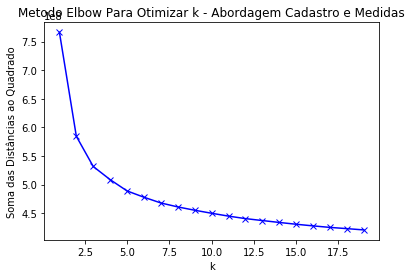

Wall time: 80 ms


In [30]:
#metodo de Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dados_cadastro_array)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Cadastro e Medidas')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_cadastro.svg', format="svg")
%time plt.show()

In [31]:
#fig.savefig('D:\Projeto_PA\\Projeto_PA_validado\\KMeansRandom\\graficos\\grafico_metodoelbow_medidas.svg', format='svg')
#plt.savefig(DIR_NMF / f'NMF_classificado_{grupo}.svg',format="svg")
#fig.savefig('diastolica_sistolica/diast_sist_elbow.png', format='png')


## Abordagem 1: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.20438485291133257
Para n_clusters = 3 O score_silhouette medio e : 0.12698921096131033
Para n_clusters = 4 O score_silhouette medio e : 0.08227575991518386
Para n_clusters = 5 O score_silhouette medio e : 0.07774326104092624
Para n_clusters = 6 O score_silhouette medio e : 0.061757552410604995
Para n_clusters = 7 O score_silhouette medio e : 0.05829610675116027
Para n_clusters = 8 O score_silhouette medio e : 0.05515462534924344


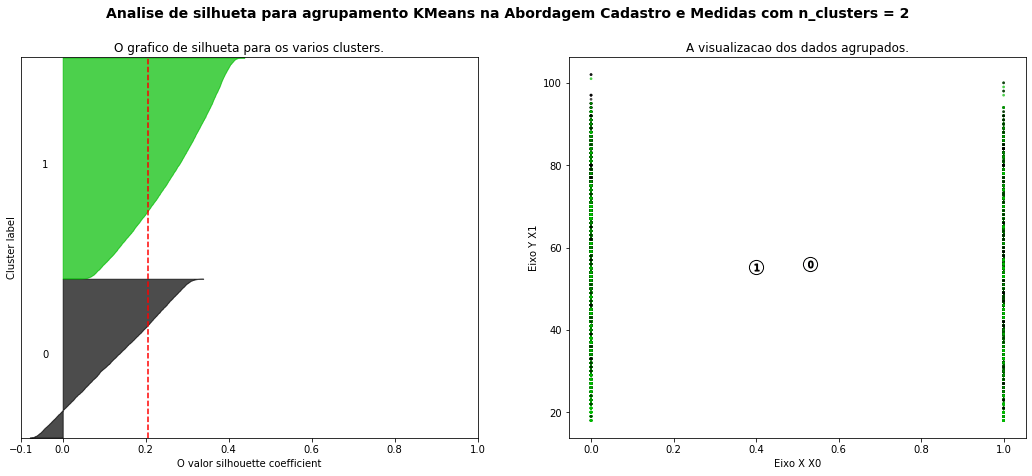

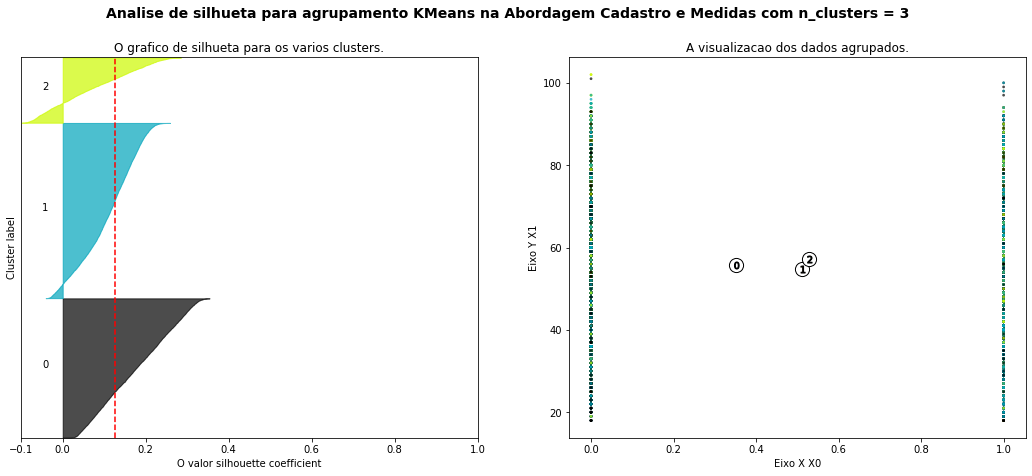

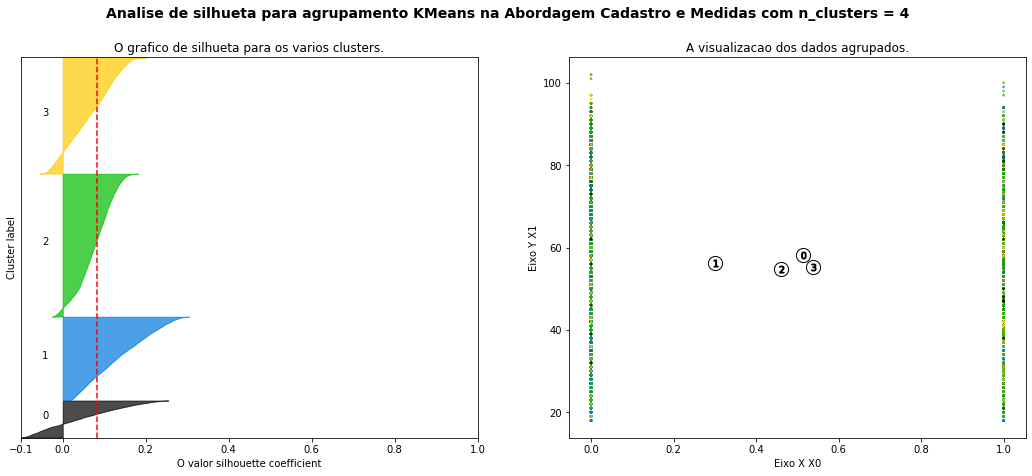

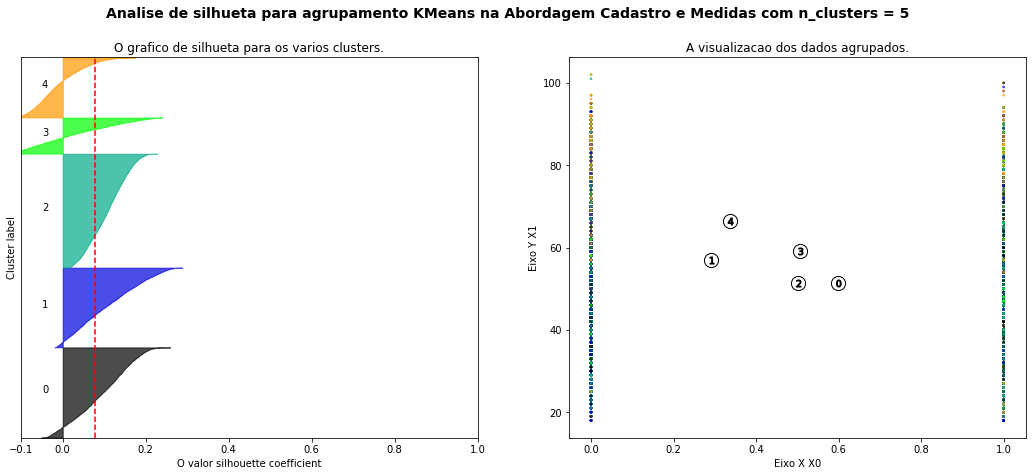

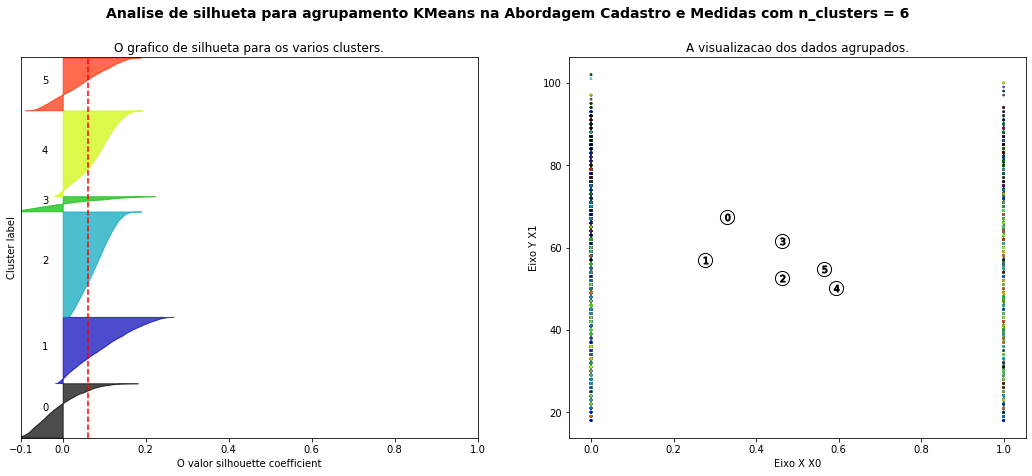

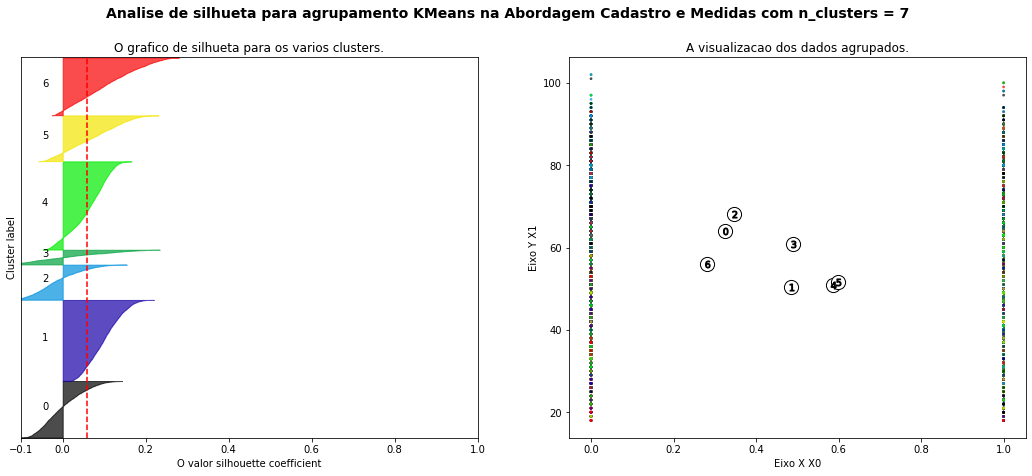

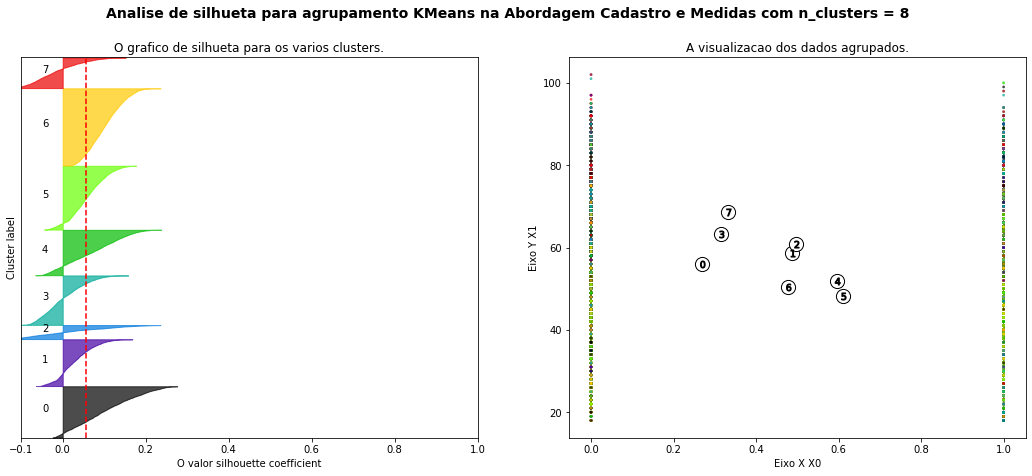

In [32]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dados_cadastro_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dados_cadastro_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dados_cadastro_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dados_cadastro_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dados_cadastro_array[:, 0], dados_cadastro_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans na Abordagem Cadastro e Medidas "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_cadastro_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando 

In [33]:
#dataset com grupos e com os dados de cadastro e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estaitsticos, 11 doenças em cada grupo 
dataset_s_d = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
dataset_s_d['IMC'] = dataset_cadastro['IMC']
dataset_s_d['grupo'] = grupos_cadastro
dataset_s_d = pd.concat([dataset_s_d,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_s_d

# Salva dataset com dados completos após o K-Means com abordagem 1 (cadastro e medidas)
dataset_s_d.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

In [34]:
dataset_s_d.head()

numero_identificacao data_nascimento  genero  idade   peso altura   IMC  \
0                     4      1923-10-05       1   94.0   85.0    160  33.2   
1                     5      1948-10-07       1   70.0   80.0    165  29.4   
2                     6      1999-03-23       1   19.0  100.0    197  25.8   
3                     7      1978-01-26       0   40.0   65.0   1,64  24.2   
4                     8      1990-03-07       1   28.0  120.0    172  40.6   

   grupo  sist 9:00  sist 9:15  ...  Mediana Sistolica em 24h  \
0      0      105.0      108.0  ...                     118.5   
1      6      103.0      114.0  ...                     106.0   
2      2      147.0      148.0  ...                     133.0   
3      2      140.0      139.0  ...                     131.0   
4      1      113.0      110.0  ...                     115.0   

   Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                       59.0                9545.5                 4902.0   
1                       62.0                8586.5                 5034.5   
2                       79.0               10674.0                 6154.0   
3                       80.0               10679.5                 6420.5   
4                       78.0                9141.5                 6118.0   

   AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0          3748.0             841.5                16.52   
1          2915.0             606.0                 7.51   
2          3721.0             751.5                12.70   
3          3642.0             602.5                16.13   
4          2405.0             566.0                12.27   

   DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  
0                 11.36               11                34  
1                  6.65                9                23  
2                 13.01               19                19  
3                 10.34               21                 9  
4                 12.79               10                11  

[5 rows x 209 columns]

## Abordagem 1: Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
#parametro simples do modelo
%time random_forest_cadastro = RandomForestClassifier(n_estimators=50)

Wall time: 0 ns


In [37]:
#base para modelo

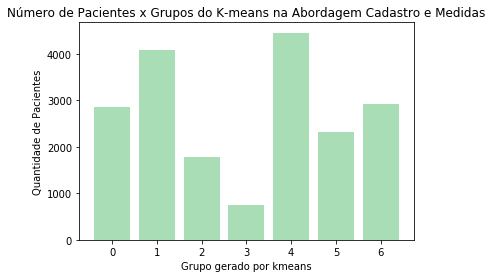

In [38]:
classes = []
qtds = []

contagem = Counter(grupos_cadastro)

for i in range(0,num_otimo_clusters_cadastro):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid ()
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Cadastro e Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem1_pacientes_por_grupos.svg',format="svg")
plt.show()


In [39]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dados_cadastro_array, grupos_cadastro, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dados_cadastro_array, grupos_cadastro, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [40]:
#treino
random_forest_cadastro.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 1: VALIDAÇÃO

In [41]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_cadastro.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [42]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [43]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2    3     4     5     6
0  1723     0     0    0     0     0     0
1     0  2461     0    0     0     0     0
2     0     0  1054    0     0     0     0
3     0     0     0  454     0     0     0
4     0     0     0    0  2670     0     0
5     0     0     0    0     0  1410     0
6     0     0     0    0     0     0  1718

#### Abordagem 1: TESTE

In [44]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_cadastro.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [45]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9088772845953003 - Recall: 0.8905618500024868 - F1 Score: 0.9050999619106629


In [46]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2    3     4    5     6
0  997    76   16    0    22    0    26
1   27  1513    0    0    60    0    27
2   43     0  611    2    47   17     0
3    0     0   10  236     0   42     0
4   15    52   10    0  1700   10     0
5    0     0    8    1    96  798     0
6   37    54    0    0     0    0  1107

In [47]:
dataset_s_d.describe()
dados_cadastro_array.shape
dados_cadastro_sem_id

genero  idade   IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  \
0           1   94.0  33.2      105.0      108.0      116.0      104.0   
1           1   70.0  29.4      103.0      114.0       82.0      104.0   
2           1   19.0  25.8      147.0      148.0      156.0      140.0   
3           0   40.0  24.2      140.0      139.0      142.0      137.0   
4           1   28.0  40.6      113.0      110.0      101.0      108.0   
...       ...    ...   ...        ...        ...        ...        ...   
19145       1   47.0  27.5      163.0      198.0      172.0      148.0   
19146       1   49.0  26.9      114.0      120.0      164.0      116.0   
19147       0   35.0  33.3      107.0      110.0      103.0      105.0   
19148       0   68.0  25.0       94.0      107.0      112.0      124.0   
19149       1   49.0  30.9      111.0      104.0      103.0      101.0   

       sist 10:00  sist 10:15  sist 10:30  ...  diast 6:45  diast 7:00  \
0           106.0        98.0       102.0  ...        46.0        51.0   
1            98.0       106.0       108.0  ...        74.0        74.0   
2           130.0       132.0       121.0  ...        86.0        93.0   
3           135.0       177.0       148.0  ...        56.0        62.0   
4           111.0       111.0       114.0  ...        73.0        83.0   
...           ...         ...         ...  ...         ...         ...   
19145       161.0       156.0       156.0  ...       114.0       126.0   
19146       119.0       126.0       123.0  ...        73.0        59.0   
19147       108.0       111.0       114.0  ...        50.0        50.0   
19148       120.0        94.0       102.0  ...        63.0        64.0   
19149        97.0       110.0       111.0  ...        68.0        69.0   

       diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  diast 8:30  \
0            56.0        61.0        67.0        61.0        69.0        62.0   
1            70.0        67.0        63.0        60.0        74.0        70.0   
2            91.0        89.0        87.0        86.0        87.0        82.0   
3            83.0       104.0        99.0        94.0        89.0        90.0   
4            93.0        68.0        91.0        87.0        84.0        81.0   
...           ...         ...         ...         ...         ...         ...   
19145       125.0       124.0       123.0       123.0       121.0       119.0   
19146        74.0        68.0        86.0        96.0       107.0       106.0   
19147        53.0        52.0        62.0        68.0        61.0        64.0   
19148        76.0        72.0        69.0        75.0        74.0        69.0   
19149        71.0        73.0        56.0        57.0        65.0        68.0   

       diast 8:45  grupo  
0            51.0      1  
1            67.0      7  
2            82.0      3  
3            72.0      3  
4            72.0      2  
...           ...    ...  
19145       123.0      4  
19146        93.0      6  
19147        60.0      7  
19148        67.0      2  
19149        82.0      5  

[19150 rows x 168 columns]

In [48]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_s_d, grupos_cadastro, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_s_d, grupos_cadastro, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 1: Importância das Features Random Forest

In [49]:
len(ls_cadastro), len(random_forest_cadastro.feature_importances_)

(167, 167)

In [50]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_cadastro,'importance':np.round(random_forest_cadastro.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

#importances.to_excel('diastolica_sistolica/features_sisto_diasto.xlsx')

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_cadastro.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
74     sist 6:15       0.018
76     sist 6:45       0.015
91   diast 10:30       0.012
48    sist 20:15       0.011
115  diast 16:30       0.011
..           ...         ...
142  diast 23:30       0.003
141  diast 23:00       0.003
154   diast 5:30       0.002
2            IMC       0.002
0         genero       0.000

[167 rows x 2 columns]

# Abordagem 2: Medidas como entrada

In [51]:
#  Arquivo salvo para servir de entrada ao K-medoids na abordagem Medidas
#

dataset_medidas.to_csv('D:/Projeto_PA/Projeto_PA_validado/KMedoids/centroide/kmedoids_pacientes_abordagem_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

In [52]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45

#   Gera uma lista com cabeçalhos
ls_sist_diast = list(dataset_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dados_medidas_sem_id = dataset_medidas.loc[:,'sist 9:00':'diast 8:45']

#dados_medidas_sem_id.head(5)
dados_medidas_sem_id.loc[1:70]


sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
1       103.0      114.0       82.0      104.0        98.0       106.0   
2       147.0      148.0      156.0      140.0       130.0       132.0   
3       140.0      139.0      142.0      137.0       135.0       177.0   
4       113.0      110.0      101.0      108.0       111.0       111.0   
5       152.0      152.0      152.0      152.0       154.0       138.0   
..        ...        ...        ...        ...         ...         ...   
66       80.0       80.0       85.0       96.0       106.0       105.0   
67      113.0      119.0      120.0      122.0       117.0       122.0   
68      154.0      142.0      123.0      125.0       111.0       113.0   
69      118.0      122.0      116.0      115.0        84.0       102.0   
70      146.0      162.0      108.0      112.0       117.0       128.0   

    sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:30  \
1        108.0       107.0       109.0       100.0  ...        74.0   
2        121.0       113.0       149.0       128.0  ...        80.0   
3        148.0       152.0       135.0       136.0  ...        49.0   
4        114.0       115.0       113.0       112.0  ...        64.0   
5        137.0       152.0        95.0       117.0  ...        67.0   
..         ...         ...         ...         ...  ...         ...   
66       103.0       105.0       104.0       100.0  ...        59.0   
67       118.0       122.0       126.0       133.0  ...        85.0   
68       114.0       118.0       113.0       121.0  ...        67.0   
69       120.0       118.0       116.0       115.0  ...        68.0   
70       128.0       127.0       126.0       137.0  ...        76.0   

    diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
1         74.0        74.0        70.0        67.0        63.0        60.0   
2         86.0        93.0        91.0        89.0        87.0        86.0   
3         56.0        62.0        83.0       104.0        99.0        94.0   
4         73.0        83.0        93.0        68.0        91.0        87.0   
5         94.0       120.0       109.0       109.0       110.0       111.0   
..         ...         ...         ...         ...         ...         ...   
66        60.0        61.0        60.0        60.0        55.0        61.0   
67        85.0        85.0        86.0        87.0        62.0        63.0   
68        78.0        89.0        97.0        82.0        87.0        96.0   
69        68.0        67.0        56.0        62.0        66.0        73.0   
70        80.0        84.0        73.0        71.0        71.0        80.0   

    diast 8:15  diast 8:30  diast 8:45  
1         74.0        70.0        67.0  
2         87.0        82.0        82.0  
3         89.0        90.0        72.0  
4         84.0        81.0        72.0  
5        112.0       114.0       115.0  
..         ...         ...         ...  
66        47.0        49.0        45.0  
67        86.0        81.0        84.0  
68       100.0        83.0        85.0  
69        66.0        72.0        75.0  
70        77.0        76.0        74.0  

[70 rows x 164 columns]

## Abordagem 2: Número de Clusters gerado pelo k-Means

In [53]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas = calculate_wcss(dados_medidas_sem_id)
num_otimo_clusters_medidas = optimal_number_of_clusters(sum_of_squares_medidas)
num_otimo_clusters_medidas

Wall time: 46.6 s


7

In [54]:
#convertendo os dados para a clusterização

dados_medidas_array = np.array(dados_medidas_sem_id)

In [55]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas = KMeans(n_clusters=num_otimo_clusters_medidas, random_state=42).fit(dados_medidas_array)

In [56]:
#listar os grupos 

%time grupos_medidas = kmeans_medidas.fit_predict(dados_medidas_array)

Wall time: 1.36 s


In [57]:
set(grupos_medidas)

{0, 1, 2, 3, 4, 5, 6}

In [58]:
contagem1 = 0
grupo_contagem = 0
for i in grupos_medidas:
    if (i == grupo_contagem):
        contagem1 += 1

print(f'Quantidade de pacientes no cluster {grupo_contagem+1}: {contagem1}')


Quantidade de pacientes no cluster 1: 2966


In [59]:
#incluir grupos nos dados de sist e diast

dados_medidas_sem_id['grupo'] = grupos_medidas
dados_medidas_sem_id['grupo'] = dados_medidas_sem_id['grupo'] + 1
dados_medidas_sem_id

sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
0          105.0      108.0      116.0      104.0       106.0        98.0   
1          103.0      114.0       82.0      104.0        98.0       106.0   
2          147.0      148.0      156.0      140.0       130.0       132.0   
3          140.0      139.0      142.0      137.0       135.0       177.0   
4          113.0      110.0      101.0      108.0       111.0       111.0   
...          ...        ...        ...        ...         ...         ...   
19145      163.0      198.0      172.0      148.0       161.0       156.0   
19146      114.0      120.0      164.0      116.0       119.0       126.0   
19147      107.0      110.0      103.0      105.0       108.0       111.0   
19148       94.0      107.0      112.0      124.0       120.0        94.0   
19149      111.0      104.0      103.0      101.0        97.0       110.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:45  \
0           102.0       107.0       111.0       116.0  ...        46.0   
1           108.0       107.0       109.0       100.0  ...        74.0   
2           121.0       113.0       149.0       128.0  ...        86.0   
3           148.0       152.0       135.0       136.0  ...        56.0   
4           114.0       115.0       113.0       112.0  ...        73.0   
...           ...         ...         ...         ...  ...         ...   
19145       156.0       138.0       107.0        76.0  ...       114.0   
19146       123.0       122.0       122.0       159.0  ...        73.0   
19147       114.0       144.0       128.0       104.0  ...        50.0   
19148       102.0       113.0       104.0        96.0  ...        63.0   
19149       111.0       116.0       104.0       121.0  ...        68.0   

       diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  \
0            51.0        56.0        61.0        67.0        61.0        69.0   
1            74.0        70.0        67.0        63.0        60.0        74.0   
2            93.0        91.0        89.0        87.0        86.0        87.0   
3            62.0        83.0       104.0        99.0        94.0        89.0   
4            83.0        93.0        68.0        91.0        87.0        84.0   
...           ...         ...         ...         ...         ...         ...   
19145       126.0       125.0       124.0       123.0       123.0       121.0   
19146        59.0        74.0        68.0        86.0        96.0       107.0   
19147        50.0        53.0        52.0        62.0        68.0        61.0   
19148        64.0        76.0        72.0        69.0        75.0        74.0   
19149        69.0        71.0        73.0        56.0        57.0        65.0   

       diast 8:30  diast 8:45  grupo  
0            62.0        51.0      1  
1            70.0        67.0      1  
2            82.0        82.0      3  
3            90.0        72.0      3  
4            81.0        72.0      2  
...           ...         ...    ...  
19145       119.0       123.0      5  
19146       106.0        93.0      6  
19147        64.0        60.0      1  
19148        69.0        67.0      2  
19149        68.0        82.0      7  

[19150 rows x 165 columns]

In [60]:
len(dados_medidas_sem_id.loc[:,'grupo'])
set(dados_medidas_sem_id.loc[:,'grupo'])

{1, 2, 3, 4, 5, 6, 7}

In [61]:
dados_medidas_sem_id.loc[:,'grupo']

0        1
1        1
2        3
3        3
4        2
        ..
19145    5
19146    6
19147    1
19148    2
19149    7
Name: grupo, Length: 19150, dtype: int32

###  Abordagem 2: Método Elbow
####  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
####  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

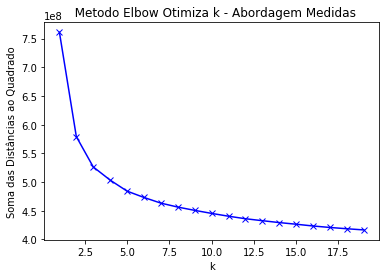

Wall time: 92.8 ms


In [62]:
#metodo de Elbow

Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dados_medidas_array)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('  Metodo Elbow Otimiza k - Abordagem Medidas')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medida.svg', format="svg")
%time plt.show()

### Abordagem 2: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.20556068194132648
Para n_clusters = 3 O score_silhouette medio e : 0.12817200383813093
Para n_clusters = 4 O score_silhouette medio e : 0.0828335775668247
Para n_clusters = 5 O score_silhouette medio e : 0.07871120462971788
Para n_clusters = 6 O score_silhouette medio e : 0.06106949271057454
Para n_clusters = 7 O score_silhouette medio e : 0.059065673771412655
Para n_clusters = 8 O score_silhouette medio e : 0.05592367596994815


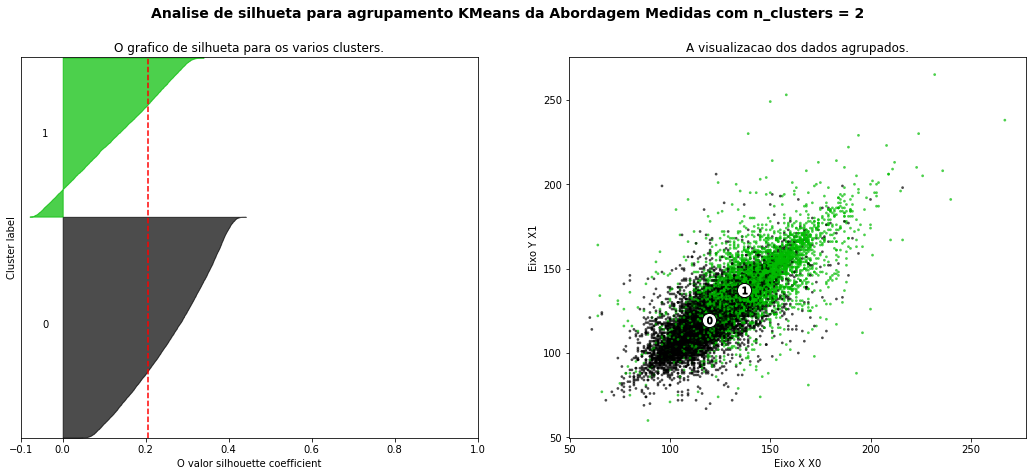

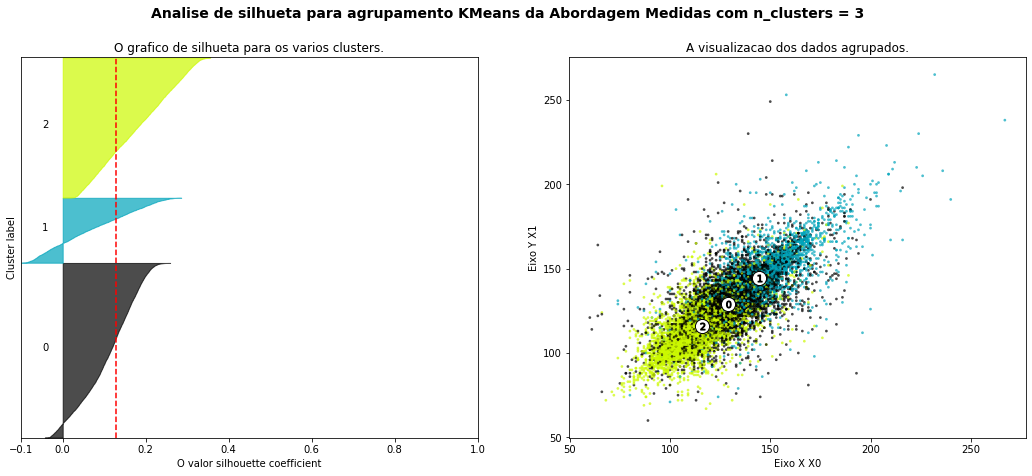

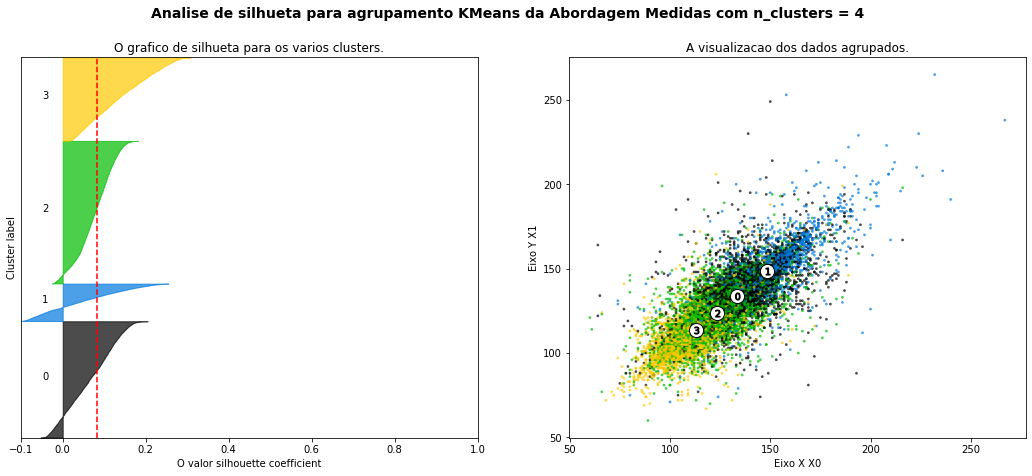

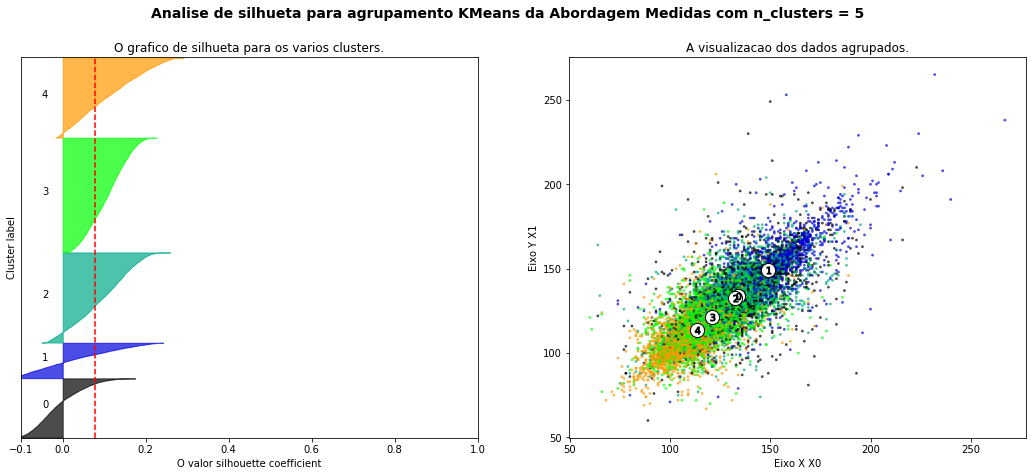

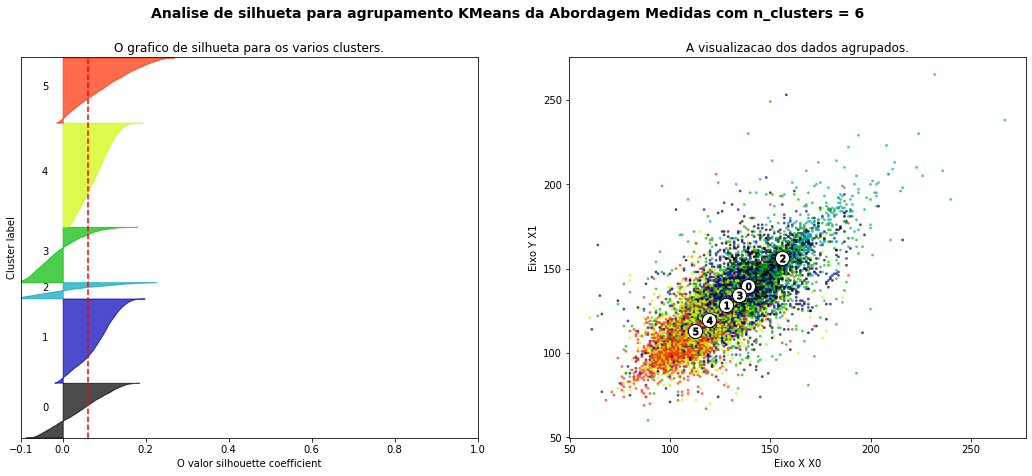

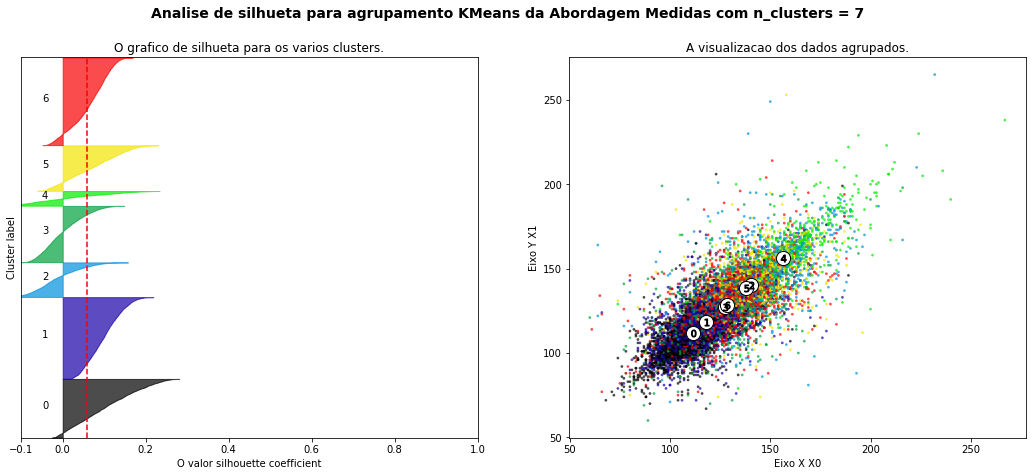

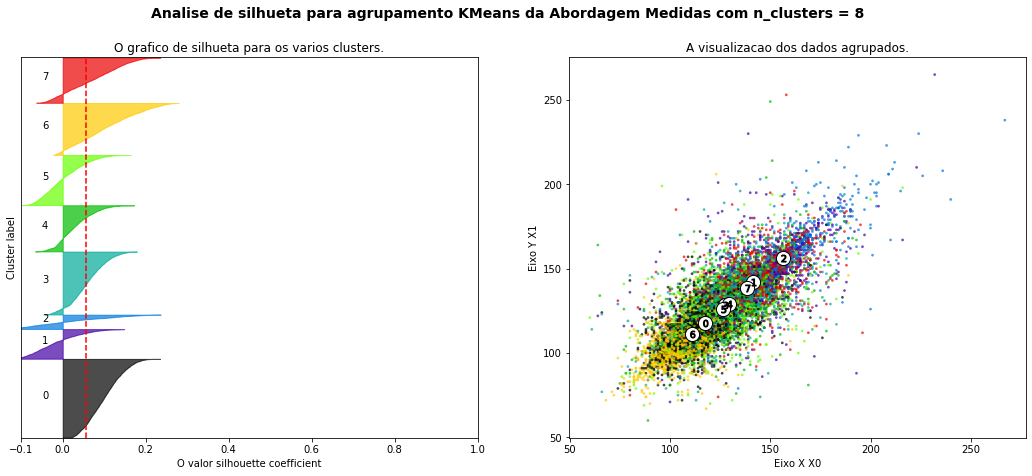

In [63]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dados_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dados_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dados_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dados_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dados_medidas_array[:, 0], dados_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Medidas "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

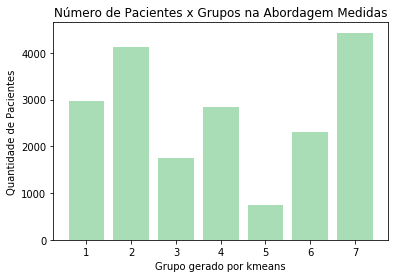

In [64]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_medidas)

for i in range(0,num_otimo_clusters_medidas):
    classes.append(i)
    qtds.append(contagem[i])

classes1 = [num + 1 for num in classes]
plt.bar(classes1,qtds,color="#a8ddb5")
plt.xticks(classes1)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
plt.title('Número de Pacientes x Grupos na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_pacientes_GruposK-means_Abordagem2_medidas.svg',format="svg")
plt.show()


In [65]:
contagem1 = 0
grupo_contagem = 0
for i in grupos_medidas:
    if (i == grupo_contagem):
        contagem1 += 1

print(f'Quantidade de pacientes no cluster {grupo_contagem+1}: {contagem1}')


Quantidade de pacientes no cluster 1: 2966


In [66]:
classes

[0, 1, 2, 3, 4, 5, 6]

In [67]:
set(grupos_medidas)

{0, 1, 2, 3, 4, 5, 6}

In [68]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
dataset_medidas_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']

dataset_medidas_apos_kmeans['grupo'] = grupos_medidas
dataset_medidas_apos_kmeans = pd.concat([dataset_medidas_apos_kmeans,
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_medidas_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 2 (medidas)
dataset_medidas_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

In [69]:
dataset_medidas_apos_kmeans.head()

numero_identificacao data_nascimento  genero  idade   peso altura   IMC  \
0                     4      1923-10-05       1   94.0   85.0    160  33.2   
1                     5      1948-10-07       1   70.0   80.0    165  29.4   
2                     6      1999-03-23       1   19.0  100.0    197  25.8   
3                     7      1978-01-26       0   40.0   65.0   1,64  24.2   
4                     8      1990-03-07       1   28.0  120.0    172  40.6   

   grupo  sist 9:00  sist 9:15  ...  Mediana Sistolica em 24h  \
0      0      105.0      108.0  ...                     118.5   
1      0      103.0      114.0  ...                     106.0   
2      2      147.0      148.0  ...                     133.0   
3      2      140.0      139.0  ...                     131.0   
4      1      113.0      110.0  ...                     115.0   

   Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                       59.0                9545.5                 4902.0   
1                       62.0                8586.5                 5034.5   
2                       79.0               10674.0                 6154.0   
3                       80.0               10679.5                 6420.5   
4                       78.0                9141.5                 6118.0   

   AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0          3748.0             841.5                16.52   
1          2915.0             606.0                 7.51   
2          3721.0             751.5                12.70   
3          3642.0             602.5                16.13   
4          2405.0             566.0                12.27   

   DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  
0                 11.36               11                34  
1                  6.65                9                23  
2                 13.01               19                19  
3                 10.34               21                 9  
4                 12.79               10                11  

[5 rows x 209 columns]

### Abordagem 2: Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [71]:
#parametro simples do modelo
random_forest_medidas = RandomForestClassifier(n_estimators=50)

In [72]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
# 
x_train, x_test, y_train, y_test = train_test_split(dados_medidas_array, grupos_medidas, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dados_medidas_array, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [73]:
#treino
random_forest_medidas.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

In [74]:
#dir(random_forest_medidas)

In [75]:
random_forest_medidas.classes_

array([0, 1, 2, 3, 4, 5, 6])

#### Abordagem 2: VALIDAÇÃO

In [76]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_medidas.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [77]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [78]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3    4     5     6
0  1749     0     0     0    0     0     0
1     0  2479     0     0    0     0     0
2     0     0  1042     0    0     0     0
3     0     0     0  1720    0     0     0
4     0     0     0     0  454     0     0
5     0     0     0     0    0  1403     0
6     0     0     0     0    0     0  2643

#### Abordagem 2: TESTE

In [79]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_medidas.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [80]:
x_test

array([[129., 135., 121., ...,  67.,  74.,  75.],
       [103., 110., 108., ...,  72.,  70.,  66.],
       [107., 105., 102., ...,  61.,  61.,  61.],
       ...,
       [112., 110., 111., ...,  75.,  88.,  84.],
       [154., 151., 148., ...,  85.,  77.,  80.],
       [171., 167., 162., ...,  90.,  89.,  88.]])

In [81]:
y_prev_test

array([3, 1, 0, ..., 6, 6, 4])

In [82]:
y_test

array([3, 1, 0, ..., 6, 6, 4])

In [83]:
y_test == y_prev_test

array([ True,  True,  True, ...,  True,  True,  True])

In [84]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9127937336814621 - Recall: 0.8950639119116319 - F1 Score: 0.9085348710721238


In [85]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2    3    4    5     6
0  1149    50    0   18    0    0     0
1    34  1539    0   17    0    0    54
2     0     0  588   43    1   26    47
3    33    72   10  981    0    0    29
4     0     0   14    0  241   33     0
5     0     0   12    0    2  800    81
6     0    49   11   18    0   14  1694

In [86]:
dataset_medidas_apos_kmeans.describe()


numero_identificacao        genero         idade          peso  \
count          19150.000000  19150.000000  19150.000000  19150.000000   
mean           10811.206527      0.454569     55.595509     77.344856   
std             6301.977172      0.497945     15.786255     16.743687   
min                4.000000      0.000000     18.000000     31.000000   
25%             5337.250000      0.000000     43.000000     65.000000   
50%            10724.500000      0.000000     56.000000     75.000000   
75%            16280.750000      1.000000     68.000000     87.000000   
max            21793.000000      1.000000    102.000000    200.000000   

                IMC         grupo    sist 9:00     sist 9:15     sist 9:30  \
count  19150.000000  19150.000000  19150.00000  19150.000000  19150.000000   
mean      27.840721      2.986110    126.67436    126.950131    126.961044   
std        4.775087      2.224117     17.54430     17.625836     17.502864   
min       15.000000      0.000000     60.00000     60.000000     61.000000   
25%       24.600000      1.000000    115.00000    115.000000    115.000000   
50%       27.200000      3.000000    125.00000    126.000000    125.000000   
75%       30.400000      5.000000    137.00000    137.000000    137.000000   
max       85.400000      6.000000    267.00000    265.000000    257.000000   

          sist 9:45  ...  Mediana Sistolica em 24h  Mediana Diastolica em 24h  \
count  19150.000000  ...              19150.000000               19150.000000   
mean     126.904073  ...                122.323629                  77.211514   
std       17.390678  ...                 11.690682                   9.949096   
min       62.000000  ...                 84.500000                  43.000000   
25%      115.000000  ...                114.000000                  70.000000   
50%      126.000000  ...                121.000000                  77.000000   
75%      137.000000  ...                129.000000                  84.000000   
max      243.000000  ...                190.000000                 138.500000   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
count          19150.000000           19150.000000    19150.000000   
mean            9948.545170            6224.610809     3071.932715   
std              942.386106             766.223018      616.296718   
min             6903.000000            3651.500000     1641.500000   
25%             9300.000000            5700.500000     2629.000000   
50%             9865.750000            6191.500000     2974.500000   
75%            10483.000000            6708.875000     3411.500000   
max            15230.000000           11134.500000     7329.500000   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
count      19150.000000         19150.000000          19150.000000   
mean         604.732193            12.921647             10.578713   
std          122.785461             3.472117              2.308765   
min          281.500000             4.570000              3.980000   
25%          519.500000            10.490000              8.960000   
50%          586.750000            12.390000             10.380000   
75%          669.500000            14.800000             11.960000   
max         1418.500000            39.550000             24.390000   

       Picos Sistolica  Picos Diastolica  
count     19150.000000      19150.000000  
mean         16.189452         20.630966  
std          13.085595         13.845569  
min           0.000000          0.000000  
25%           7.000000         11.000000  
50%          12.000000         17.000000  
75%          21.000000         27.000000  
max          81.000000         82.000000  

[8 rows x 194 columns]

In [87]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
#x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos_medidas, test_size=1 - train_ratio, random_state=42)
#x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_medidas_apos_kmeans, grupos_medidas, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 2: Importância das Features Random Forest

In [88]:
len(ls_sist_diast), len(random_forest_medidas.feature_importances_)

(164, 164)

In [89]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia_medidas = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_medidas.feature_importances_,3)})
importancia_medidas = importancia_medidas.sort_values('importance',ascending=False)

importancia_medidas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia_medidas


features  importance
73     sist 6:45       0.015
71     sist 6:15       0.013
44    sist 20:00       0.012
92   diast 11:30       0.012
91   diast 11:15       0.012
..           ...         ...
141   diast 0:30       0.003
140   diast 0:00       0.003
139  diast 23:30       0.003
137  diast 22:45       0.003
138  diast 23:00       0.003

[164 rows x 2 columns]

In [90]:
#!pip install lime        # x_train, x_test, y_train, y_test

In [91]:
#explica = lime_tabular.LimeTabularExplainer(
#                            training_data=np.array(x_train),
#                            feature_names=dados_medidas_sem_id.columns,
#                            #class_names=['grupo 1'],
#                            mode='classification'
#)
#

In [92]:
#dados_medidas_sem_id.loc[:,'sist 6:45':]

In [93]:
#exp = explica.explain_instance(
#    data_row=x_test[10], 
#    num_features=20,
#    predict_fn=random_forest_medidas.predict_proba
#)
#
#exp.show_in_notebook(show_table=True)

In [94]:
 #explica.explain_instance()

In [95]:
#print (x_test)

In [96]:
#  Método LIME para explicar como o Classificador Random Forest utilizou as variáveis

#explica = lime_tabular.LimeTabularExplainer(
#                                    dado_treinamento = np.array(x_train),
#                                    nome_colunas = dados_medidas_sem_id.columns,
#                                    nome_classes = 'grupo',
#                                    mode = 'classification'
#                                    )
#
#
#print (explica)

In [97]:
#print (x_train)

In [98]:
#print (y_train)

In [99]:
#print (dados_medidas_array)

# Abordagem 2.1: Medidas Importantes

In [100]:
#  Utiliza as 7 features mais importantes calculadas na Abordagem Medidas
ls_importantes = importancia_medidas['features'].iloc[:7].values
ls_importantes

array(['sist 6:45', 'sist 6:15', 'sist 20:00', 'diast 11:30',
       'diast 11:15', 'sist 19:15', 'sist 20:30'], dtype=object)

In [101]:
medidas_importantes = dataset_apos_tratamento[ls_importantes]
medidas_importantes

sist 6:45  sist 6:15  sist 20:00  diast 11:30  diast 11:15  sist 19:15  \
0           94.0      104.0       109.0         62.0         58.0       111.0   
1          111.0      107.0       107.0         60.0         61.0       106.0   
2          136.0      122.0       122.0         72.0         54.0       131.0   
3          104.0      116.0       127.0         84.0         84.0       137.0   
4          116.0      102.0       130.0         78.0         78.0       111.0   
...          ...        ...         ...          ...          ...         ...   
19145      162.0      152.0       163.0        135.0         60.0       158.0   
19146      136.0      146.0       125.0         88.0         84.0       125.0   
19147       96.0       94.0       119.0         64.0         65.0       131.0   
19148      124.0      107.0       121.0         64.0         69.0       126.0   
19149      105.0      102.0       115.0         99.0         98.0       117.0   

       sist 20:30  
0           110.0  
1           108.0  
2           137.0  
3           137.0  
4           117.0  
...           ...  
19145       163.0  
19146       147.0  
19147       133.0  
19148       130.0  
19149       110.0  

[19150 rows x 7 columns]

## Abordagem 2.1: Número de Clusters gerado pelo k-Means

In [102]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas_importantes = calculate_wcss(medidas_importantes)
num_otimo_clusters_medidas_importantes = optimal_number_of_clusters(sum_of_squares_medidas_importantes)
num_otimo_clusters_medidas_importantes

Wall time: 16.3 s


7

In [103]:
#convertendo os dados para a clusterização

dados_medidas_importantes_array = np.array(medidas_importantes)

In [104]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas_importantes = KMeans(n_clusters=num_otimo_clusters_medidas_importantes, random_state=42).fit(dados_medidas_importantes_array)

In [105]:
#listar os grupos 

%time grupos_medidas_importantes = kmeans_medidas_importantes.fit_predict(dados_medidas_importantes_array)
grupos_medidas_importantes

Wall time: 378 ms


array([1, 1, 0, ..., 0, 0, 5])

In [106]:
medidas_importantes.insert(0,'grupo',grupos_medidas_importantes + 1)
medidas_importantes

grupo  sist 6:45  sist 6:15  sist 20:00  diast 11:30  diast 11:15  \
0          2       94.0      104.0       109.0         62.0         58.0   
1          2      111.0      107.0       107.0         60.0         61.0   
2          1      136.0      122.0       122.0         72.0         54.0   
3          1      104.0      116.0       127.0         84.0         84.0   
4          6      116.0      102.0       130.0         78.0         78.0   
...      ...        ...        ...         ...          ...          ...   
19145      3      162.0      152.0       163.0        135.0         60.0   
19146      5      136.0      146.0       125.0         88.0         84.0   
19147      1       96.0       94.0       119.0         64.0         65.0   
19148      1      124.0      107.0       121.0         64.0         69.0   
19149      6      105.0      102.0       115.0         99.0         98.0   

       sist 19:15  sist 20:30  
0           111.0       110.0  
1           106.0       108.0  
2           131.0       137.0  
3           137.0       137.0  
4           111.0       117.0  
...           ...         ...  
19145       158.0       163.0  
19146       125.0       147.0  
19147       131.0       133.0  
19148       126.0       130.0  
19149       117.0       110.0  

[19150 rows x 8 columns]

In [107]:
df_medidas_importantes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],medidas_importantes['grupo'],dataset_apos_tratamento.loc[:,'sist 9:00':]], axis=1)
df_medidas_importantes

numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19145                 21786      1972-11-25       1   47.0   75.0    165   
19146                 21787      1970-10-19       1   49.0   90.0    183   
19147                 21788      1985-03-15       0   35.0   93.0    167   
19148                 21792      1952-04-21       0   68.0   64.0    160   
19149                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 9:00  ...  \
0      33.2  2018-09-10 12:25:23      2      105.0  ...   
1      29.4  2018-12-26 07:39:41      2      103.0  ...   
2      25.8  2018-12-26 08:06:19      1      147.0  ...   
3      24.2  2018-12-26 08:19:06      1      140.0  ...   
4      40.6  2018-12-26 08:26:59      6      113.0  ...   
...     ...                  ...    ...        ...  ...   
19145  27.5  2020-09-10 16:03:08      3      163.0  ...   
19146  26.9  2020-09-10 16:21:02      5      114.0  ...   
19147  33.3  2020-09-10 16:44:53      1      107.0  ...   
19148  25.0  2020-09-10 17:25:50      1       94.0  ...   
19149  30.9  2020-09-10 17:42:01      6      111.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19145                      116.0               12224.5                 9265.0   
19146                       85.0               10970.0                 6819.0   
19147                       62.0                9245.0                 4935.5   
19148                       68.0                8989.5                 5660.0   
19149                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19145          2439.0             474.5                18.66   
19146          3319.0             738.0                17.22   
19147          3556.0             713.5                14.36   
19148          2815.5             460.0                14.14   
19149          2400.5             612.0                13.92   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                     11.36               11                34   
1                      6.65                9                23   
2                     13.01               19                19   
3                     10.34               21                 9   
4                     12.79               10                11   
...                     ...              ...               ...   
19145                 14.80               49                60   
19146                 13.67               32                27   
19147                  8.29               14     

# Abordagem 2.2: Features Selection: Select Kbest na Abordagem 2

In [108]:
#  Uso do SelectKBest para identificar as melhores 5 features

#from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
dados_medidas_sem_id
#medidas_mais_importantes_ml = SelectKBest(chi2, k=7).fit_transform(dados_medidas_array, grupos_medidas)
medidas_mais_importantes_ml = SelectKBest(score_func=chi2, k=7).fit_transform(dados_medidas_sem_id.iloc[:,:-1], grupos_medidas)
medidas_mais_importantes_ml.shape

(19150, 7)

In [109]:
ls_score = SelectKBest(chi2, k=7).score_func(dados_medidas_sem_id.iloc[:,:-1], grupos_medidas)[0]

ls_score_indice = []

for indice, score in enumerate(ls_score):
    ls_score_indice.append((score,indice+1))

for i in range(len(ls_score_indice)):
    for j in range(i+1,len(ls_score_indice)):
        if (ls_score_indice[j][0] > ls_score_indice[i][0]):
            aux = ls_score_indice[j]
            ls_score_indice[j] = ls_score_indice[i]
            ls_score_indice[i] = aux

print(ls_score_indice[:7])

[(21941.147388485715, 75), (21731.222394085493, 74), (21554.226396697723, 73), (21520.00969161237, 76), (21321.902970506693, 72), (21188.619342582173, 77), (21177.92606075582, 71)]


In [110]:
SelectKBest(chi2, k=7).score_func(dados_medidas_sem_id.iloc[:,:-1], grupos_medidas)

(array([17788.33320853, 17900.92168111, 17550.4871343 , 17460.32274403,
        17394.58462936, 17444.19583463, 17068.41266971, 17148.88407673,
        16867.98443948, 16581.85491925, 16358.03148066, 16046.04102986,
        16159.72451233, 15881.00420431, 16765.13773548, 16417.79885902,
        16388.38387363, 15848.37532088, 15914.77581924, 15625.08222242,
        15596.03743943, 15884.12574525, 16381.31405047, 16562.3418753 ,
        16692.92980908, 16799.6865972 , 16901.90463692, 17166.13403188,
        17488.1437322 , 17530.73690051, 17784.82359209, 17724.28413879,
        17228.15108969, 17929.52684089, 17851.28334061, 18547.02570821,
        18666.96223061, 18648.72022531, 18536.51306246, 18788.07322392,
        18483.76995005, 18920.29191832, 19261.35095417, 19442.39505448,
        19494.31494417, 19067.34464735, 19236.88390477, 19199.55662272,
        19049.59046564, 19282.28225994, 19379.03672206, 19409.5016021 ,
        19449.29981405, 19936.53371644, 19584.14460391, 19471.69

In [111]:
medidas_mais_importantes_ml

array([[113., 104.,  96., ...,  92.,  91.,  89.],
       [105., 107., 109., ..., 113., 113., 113.],
       [109., 122., 135., ..., 136., 135., 134.],
       ...,
       [ 89.,  94.,  98., ...,  95., 100., 110.],
       [ 99., 107., 116., ..., 133., 121., 114.],
       [100., 102., 103., ..., 108., 111., 105.]])

In [112]:
#medidas_transformadas[70]

In [113]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

medidas_mais_importantes = pd.DataFrame(medidas_mais_importantes_ml)

In [114]:
# identificação de quais colunas foram escolhidas
#
lista_colunas_escolhidas = []
#
## X é o dataset das doenças que precisa ser transformado em df
medidas_transformadas = pd.DataFrame(dados_medidas_array)


for coluna_ml in range(len(medidas_mais_importantes.columns)):
    for coluna_base in range(len(medidas_transformadas.columns)):
        # para identificar valores únicos
        if set(np.array(medidas_transformadas[coluna_base]) == np.array(medidas_mais_importantes[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

lista_colunas_escolhidas,list(dados_medidas_sem_id.iloc[:,lista_colunas_escolhidas].columns)

#

([70, 71, 72, 73, 74, 75, 76],
 ['sist 6:00',
  'sist 6:15',
  'sist 6:30',
  'sist 6:45',
  'sist 7:00',
  'sist 7:15',
  'sist 7:30'])

In [115]:
#selecionando padrões de doencas

ls_medidas_kbest = ['sist 5:30', 'sist 6:00', 'sist 6:15', 'sist 6:30', 'sist 6:45', 'sist 7:00', 'sist 7:15']
ls_medidas_kbest = list(dados_medidas_sem_id.iloc[:,lista_colunas_escolhidas].columns)

dados_padrao_medidas_kbest =  dataset_apos_tratamento[ls_medidas_kbest]
dados_padrao_medidas_kbest

sist 6:00  sist 6:15  sist 6:30  sist 6:45  sist 7:00  sist 7:15  \
0          113.0      104.0       96.0       94.0       92.0       91.0   
1          105.0      107.0      109.0      111.0      113.0      113.0   
2          109.0      122.0      135.0      136.0      136.0      135.0   
3          135.0      116.0       96.0      104.0      111.0      128.0   
4           94.0      102.0      109.0      116.0      124.0      132.0   
...          ...        ...        ...        ...        ...        ...   
19145      147.0      152.0      157.0      162.0      166.0      166.0   
19146      135.0      146.0      157.0      136.0      116.0      113.0   
19147       89.0       94.0       98.0       96.0       95.0      100.0   
19148       99.0      107.0      116.0      124.0      133.0      121.0   
19149      100.0      102.0      103.0      105.0      108.0      111.0   

       sist 7:30  
0           89.0  
1          113.0  
2          134.0  
3          145.0  
4           93.0  
...          ...  
19145      166.0  
19146      113.0  
19147      110.0  
19148      114.0  
19149      105.0  

[19150 rows x 7 columns]

## K-means para Abordagem 2.2: SelectKbest

In [116]:
#  Cálculo do "n_clusters" considerando as colunas definidas por SelectKBest

sum_of_squares = calculate_wcss(medidas_mais_importantes_ml)
medidas_kbest = optimal_number_of_clusters(sum_of_squares)
kmeans = KMeans(n_clusters=medidas_kbest, random_state=42).fit(medidas_mais_importantes_ml)
grupos_medidas_kbest = kmeans.fit_predict(medidas_mais_importantes_ml)
print(medidas_kbest)
print(grupos_medidas_kbest)

6
[2 3 1 ... 2 3 2]


###  Abordagem 2.2: Random Forest for KBest

In [117]:
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

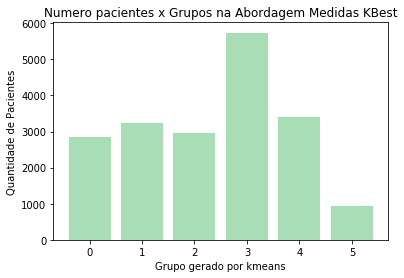

In [118]:
#base para modelo
classes = []
qtds = []

contagem_medidas = Counter(grupos_medidas_kbest)

for i in range(0,medidas_kbest):
    classes.append(i)
    qtds.append(contagem_medidas[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
plt.title('Numero pacientes x Grupos na Abordagem Medidas KBest')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_pacientes_GruposK-means_Abordagem2_medidas_KBest.svg',format="svg")
plt.show()

## Train, Test, Validation for KBest

In [119]:
# Separa o grupo de dados para treino e teste
#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection: SelectKBest
x_train, x_test, y_train, y_test = train_test_split(medidas_mais_importantes_ml, grupos_medidas_kbest, test_size=1 - train_ratio,random_state=42)

# Feature Selection: SelectKBest
x_val, x_test, y_val, y_test = train_test_split(medidas_mais_importantes_ml, grupos_medidas_kbest, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)


# Feature Selection: SelectKBest sem validação
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)

#X_train.shape, y_train.shape

#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [120]:
# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 2.2: VALIDAÇÃO

In [121]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [122]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3     4    5
0  1721     0     0     0     0    0
1     0  1983     0     0     0    0
2     0     0  1709     0     0    0
3     0     0     0  3467     0    0
4     0     0     0     0  2054    0
5     0     0     0     0     0  556

#### Abordagem 2.2: TESTE

In [123]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9656657963446476 - Recall: 0.9628937035551087 - F1 Score: 0.9660074806068716


In [124]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3     4    5
0  1104     8     0     0    19    1
1     9  1202     0    32    23    0
2     0     0  1225    28     0    0
3     0    24    31  2203    15    0
4    19    15     0    18  1309    0
5    21     0     0     0     0  354

####  Abordagem 2.2: Importância das Features Random Forest

In [125]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

# Importância para SelectKBest
importancia_medidas = pd.DataFrame({'features':ls_medidas_kbest,'importance':np.round(random_forest.feature_importances_,3)})

importancia_medidas = importancia_medidas.sort_values('importance',ascending=False)

importancia_medidas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_kbest_medidas.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia_medidas

features  importance
1  sist 6:15       0.214
3  sist 6:45       0.196
5  sist 7:15       0.177
6  sist 7:30       0.141
4  sist 7:00       0.108
2  sist 6:30       0.088
0  sist 6:00       0.076

# Abordagem 3: Estatísticas como entrada

In [126]:
#selecionando variaveis estatisticas


ls_estatistica = [
    'Media Sistolica em 24h',
#    'Media Diastolica em 24h',
#    'Media Sistolica Diurna',
#    'Media Sistolica Matutina',
#    'Media Sistolica Vespertina',
#    'Media Sistolica Daytime',
#    'Media Sistolica Nighttime',
#    'Media Diastolica Diurna',
#    'Media Diastolica Matutina',
#    'Media Diastolica Vespertina',
#    'Media Diastolica Daytime',
#    'Media Diastolica Nighttime',
#    'Variancia Sistolica em 24h',
#    'Variancia Diastolica em 24h',
#    'Mediana Sistolica em 24h',
#    'Mediana Diastolica em 24h',
    'AUC Sistolica em 24h',
    'AUC Diastolica em 24h',
    'AUC PP Daytime',
#    'AUC PP Nighttime',
#    'DP Sistolica em 24h',
#    'DP Diastolica em 24h',
]

dados_estatistica =  dataset_estatistica[ls_estatistica]

In [127]:
#tratar nulos
dados_estatistica_sem_nan = dados_estatistica.fillna(0)

## Abordagem 3: Número de Clusters gerado pelo k-Means

In [128]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(dados_estatistica_sem_nan)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

Wall time: 13.7 s
7


In [129]:
#convertendo os dados para a clusterização
X = np.array(dados_estatistica_sem_nan)

In [130]:
#habilitando o kmeans com 7 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=42).fit(X)

In [131]:
#listar os grupos 
grupos = kmeans.fit_predict(X)

In [132]:
#incluir grupos nos dados de sist e diast
dados_estatistica_sem_nan['grupo'] = grupos
dados_estatistica_sem_nan['grupo'] = dados_estatistica_sem_nan['grupo'] + 1

##   Abordagem 3: Método Elbow 

###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

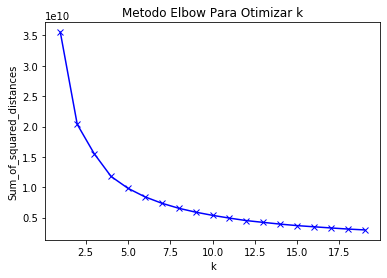

In [133]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_estatistica.svg', format="svg")
plt.show()



## Abordagem 3: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

Para n_clusters = 2 O score_silhouette medio e : 0.38543211731640553
Para n_clusters = 3 O score_silhouette medio e : 0.32630394338027285
Para n_clusters = 4 O score_silhouette medio e : 0.3508785240125203
Para n_clusters = 5 O score_silhouette medio e : 0.3258701400704055
Para n_clusters = 6 O score_silhouette medio e : 0.3265899178214712
Para n_clusters = 7 O score_silhouette medio e : 0.322281945698608


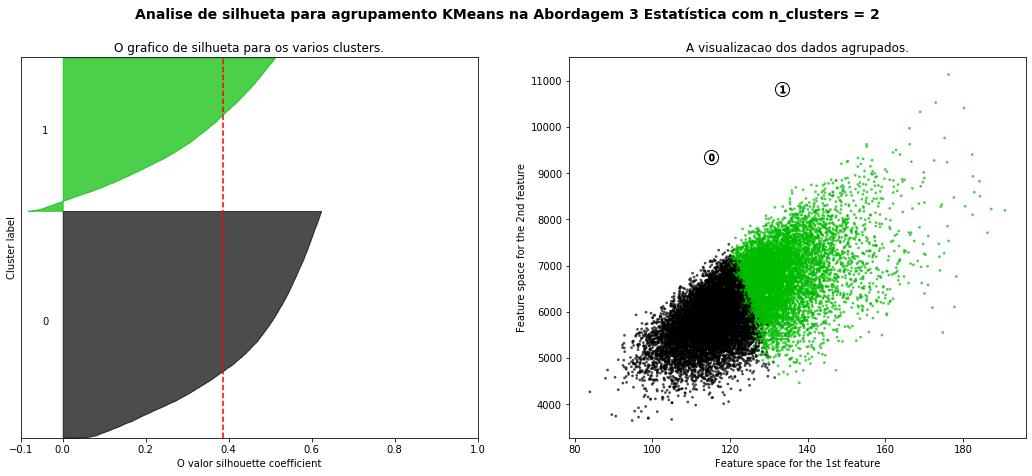

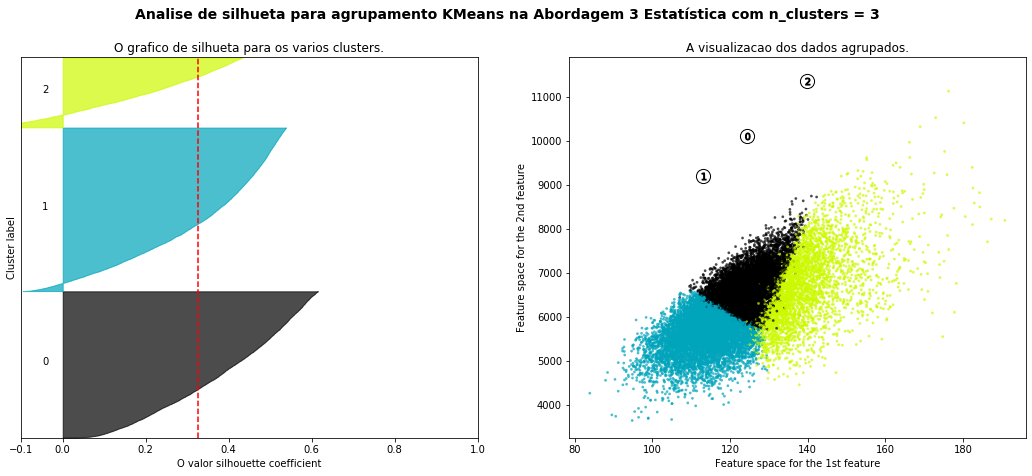

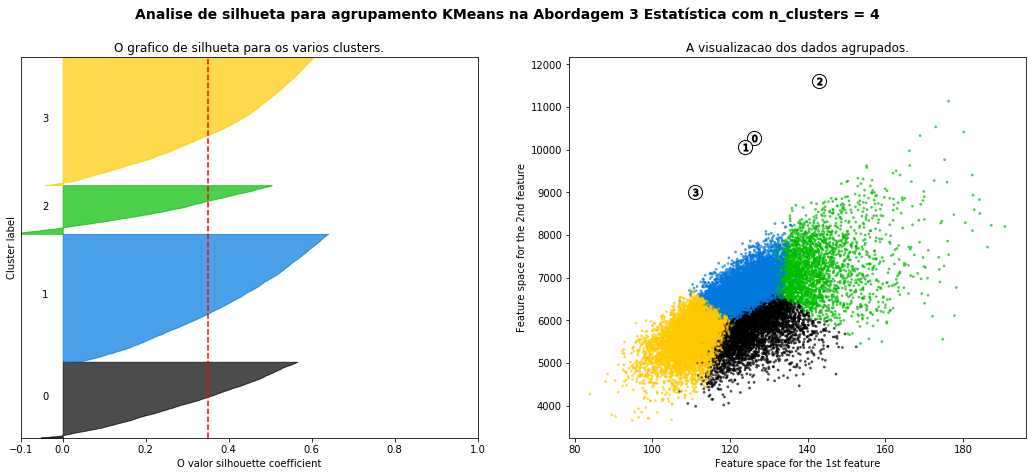

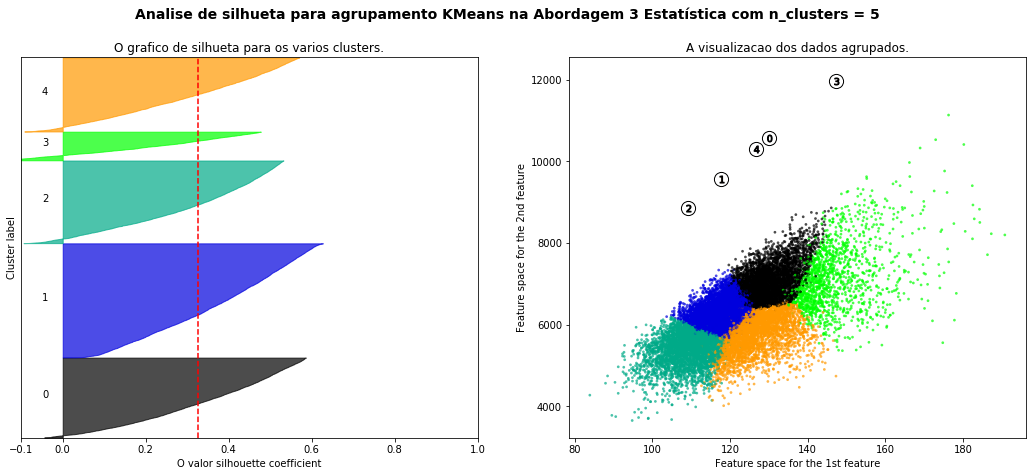

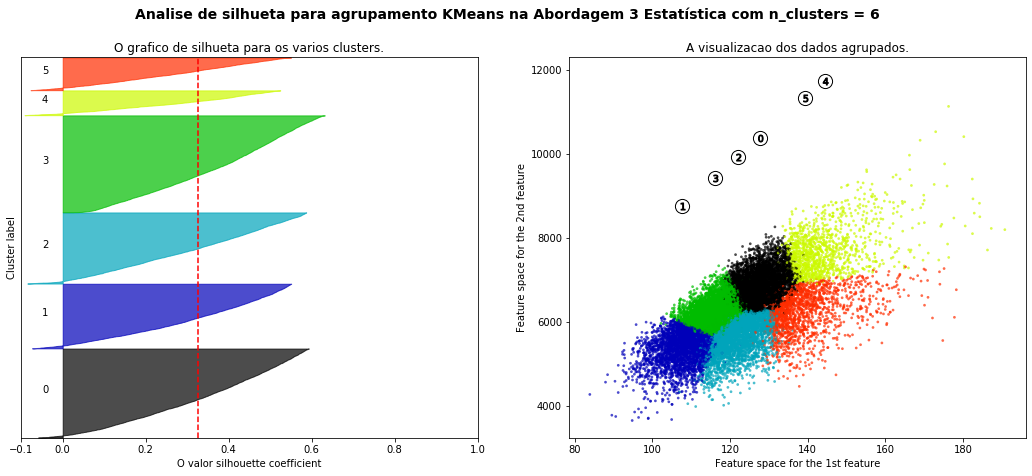

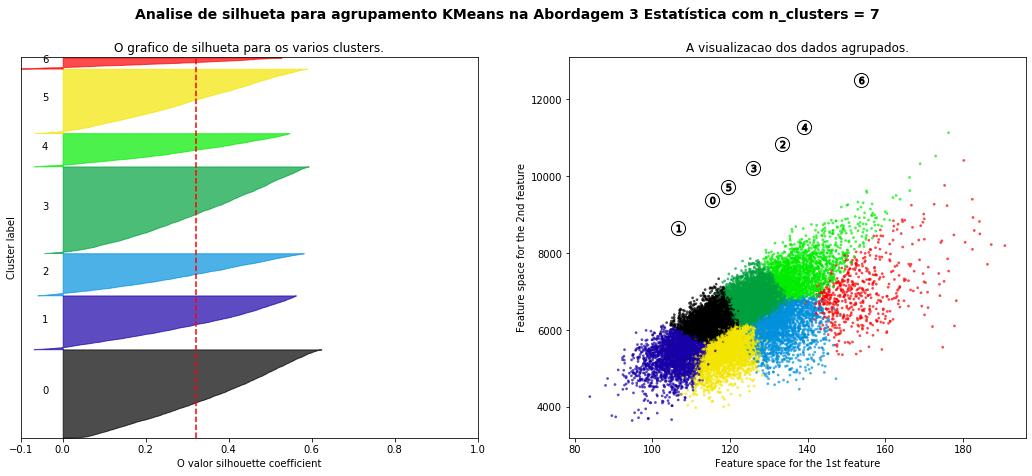

In [134]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color,       alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans na Abordagem 3 Estatística "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_estatistica_{n_clusters}.svg', format="svg")
    #fig.savefig('estatisticas/estatisticas_kmeans_'+str(n_clusters)+'.png', format='png')

plt.show()

#fig.savefig('kmeans_estatisticas.png', format='png')

In [135]:
#dataset com grupos e por estatisticas

dataset_estatistica = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']
#############################################################################################
#dataset_estatistica = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
#dataset_estatistica['IMC'] = dataset_medidas['IMC']
dataset_estatistica['grupo'] = grupos
dataset_estatistica = pd.concat([dataset_estatistica,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


### Abordagem 3: Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [137]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

In [138]:
#base para modelo

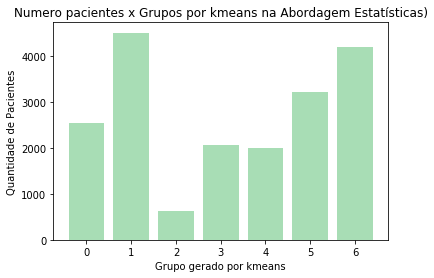

In [139]:
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Estatísticas)')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem2_estatistica_por_grupos.svg',format="svg")
plt.show()

In [140]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [141]:
#treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 3: VALIDAÇÃO

In [142]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [143]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [144]:
#Matriz da Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3     4     5     6
0  1501     0    0     0     0     0     0
1     0  2691    0     0     0     0     0
2     0     0  371     0     0     0     0
3     0     0    0  1220     0     0     0
4     0     0    0     0  1233     0     0
5     0     0    0     0     0  1965     0
6     0     0    0     0     0     0  2509

#### Abordagem 3: TESTE

In [145]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [146]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9906005221932115 - Recall: 0.9902277925667026 - F1 Score: 0.9897419620035283


In [147]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2    3    4     5     6
0  1038     0    0    0    0     4     3
1     0  1799    0    3    7     1     7
2     0     0  257    0    2     0     0
3     0     2    2  825    3     4     0
4     0     7    2    1  747     0     0
5     2     1    0    9    0  1235     5
6     1     3    0    0    0     3  1687

In [148]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_estatistica, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_estatistica = x_val_[['numero_identificacao']]
pacientes_validacao_estatistica['Grupo_Real'] = y_val_
pacientes_validacao_estatistica['Grupo_Previsto'] = y_prev_val
pacientes_validacao_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


#teste
pacientes_teste_estatistica = x_test_[['numero_identificacao']]
pacientes_teste_estatistica['Grupo_Real'] = y_test_
pacientes_teste_estatistica['Grupo_Previsto'] = y_prev_test
pacientes_teste_estatistica.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 3: Importância das Features Random Forest

In [149]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_estatistica,'importance':np.round(random_forest.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
1    AUC Sistolica em 24h       0.332
2   AUC Diastolica em 24h       0.268
3          AUC PP Daytime       0.220
0  Media Sistolica em 24h       0.180

# Abordagem 4: Padrão de Doenças

In [150]:
#selecionando padrões de doencas

ls_padroes_doencas = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas =  dataset_apos_tratamento[ls_padroes_doencas]

In [151]:
dados_padrao_doencas[dados_padrao_doencas['Non Dipping'] == True]

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
2            True              False               False    False   
5            True              False               False    False   
6            True              False               False    False   
7            True              False               False    False   
8            True              False               False    False   
...           ...                ...                 ...      ...   
19138        True              False               False    False   
19139        True              False               False    False   
19141        True              False               False    False   
19146        True              False               False    False   
19147        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
2             True            False            False          False   False   
5             True            False            False          False   False   
6             True            False            False          False   False   
7             True            False            False          False   False   
8             True            False            False          False   False   
...            ...              ...              ...            ...     ...   
19138         True            False            False          False   False   
19139         True            False            False          False   False   
19141         True            False            False          False   False   
19146         True            False            False          False   False   
19147         True            False            False          False   False   

       Whitecoat  Normotenso  
2           True       False  
5           True       False  
6           True       False  
7          False       False  
8          False       False  
...          ...         ...  
19138       True       False  
19139       True       False  
19141       True       False  
19146       True       False  
19147       True       False  

[8681 rows x 11 columns]

In [152]:
#tratar nulos
dados_padrao_doencas_sem_nan = dados_padrao_doencas.fillna(0)
dados_padrao_doencas_sem_nan

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19145        True              False               False     True   
19146        True              False               False    False   
19147        True              False               False    False   
19148        True              False               False    False   
19149        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19145        False            False            False           True   False   
19146         True            False            False          False   False   
19147         True            False            False          False   False   
19148        False             True            False          False   False   
19149        False            False             True          False   False   

       Whitecoat  Normotenso  
0          False       False  
1          False       False  
2           True       False  
3           True       False  
4          False       False  
...          ...         ...  
19145       True       False  
19146       True       False  
19147       True       False  
19148      False       False  
19149       True       False  

[19150 rows x 11 columns]

In [153]:
#trocar nulos do dataframe
d_p_d = dados_padrao_doencas
dados_padrao_doencas

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19145        True              False               False     True   
19146        True              False               False    False   
19147        True              False               False    False   
19148        True              False               False    False   
19149        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19145        False            False            False           True   False   
19146         True            False            False          False   False   
19147         True            False            False          False   False   
19148        False             True            False          False   False   
19149        False            False             True          False   False   

       Whitecoat  Normotenso  
0          False       False  
1          False       False  
2           True       False  
3           True       False  
4          False       False  
...          ...         ...  
19145       True       False  
19146       True       False  
19147       True       False  
19148      False       False  
19149       True       False  

[19150 rows x 11 columns]

In [154]:
##############################################################################################################
#Trocar True e False para 1 e 0
#d_p_d['Hipotensao'] = d_p_d['Hipotensao'].apply(verdadeiro_falso)
#d_p_d['Sistolica Isolada'] = d_p_d['Sistolica Isolada'].apply(verdadeiro_falso)
#d_p_d['Diastolica Isolada'] = d_p_d['Diastolica Isolada'].apply(verdadeiro_falso)
#d_p_d['Dipping'] = d_p_d['Dipping'].apply(verdadeiro_falso)
#d_p_d['Non Dipping'] = d_p_d['Non Dipping'].apply(verdadeiro_falso)
#d_p_d['Extreme Dipping'] = d_p_d['Extreme Dipping'].apply(verdadeiro_falso)
#d_p_d['Reverse Dipping'] = d_p_d['Reverse Dipping'].apply(verdadeiro_falso)
#d_p_d['Morning Surge'] = d_p_d['Morning Surge'].apply(verdadeiro_falso)
#d_p_d['Masked'] = d_p_d['Masked'].apply(verdadeiro_falso)
#d_p_d['Whitecoat'] = d_p_d['Whitecoat'].apply(verdadeiro_falso)
#d_p_d['Normotenso'] = d_p_d['Normotenso'].apply(verdadeiro_falso)

##  Abordagem 4: Número de Clusters gerado pelo k-Means

In [155]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
sum_of_squares = calculate_wcss(d_p_d)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

8


In [156]:
kmeans

KMeans(n_clusters=7, random_state=42)

In [157]:
#convertendo os dados para entrga ao Random - Classifcação
X = np.array(d_p_d)

In [158]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans = KMeans(n_clusters=n, random_state=42).fit(X)


In [159]:
#listar os grupos 

grupos = kmeans.fit_predict(X)


In [160]:
grupos

array([4, 4, 2, ..., 2, 6, 4])

In [161]:
set(grupos)

{0, 1, 2, 3, 4, 5, 6, 7}

##   Abordagem 4: Método Elbow 

###  Método de cálculo do melhor número de cluster para o algoritmo e plota o gráfico

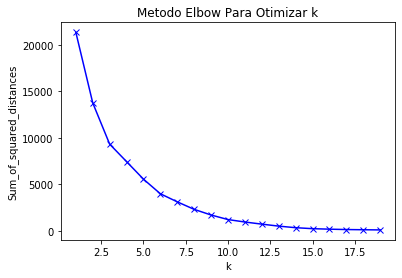

In [162]:
#metodo Elbow
Sum_of_squared_distances = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Metodo Elbow Para Otimizar k')
fig = plt.gcf()
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_doenca.svg', format="svg")
plt.show()

## Abordagem 4: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster

In [163]:
X

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False,  True, False],
       ...,
       [ True, False, False, ..., False,  True, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False,  True, False]])

Para n_clusters = 2 O score_silhouette medio é : 0.417066442958284
Para n_clusters = 3 O score_silhouette medio é : 0.5265157717211699
Para n_clusters = 4 O score_silhouette medio é : 0.5848233364330666
Para n_clusters = 5 O score_silhouette medio é : 0.6556366154598832
Para n_clusters = 6 O score_silhouette medio é : 0.6951612758577148
Para n_clusters = 7 O score_silhouette medio é : 0.7502067604064192
Para n_clusters = 8 O score_silhouette medio é : 0.8151679649032846


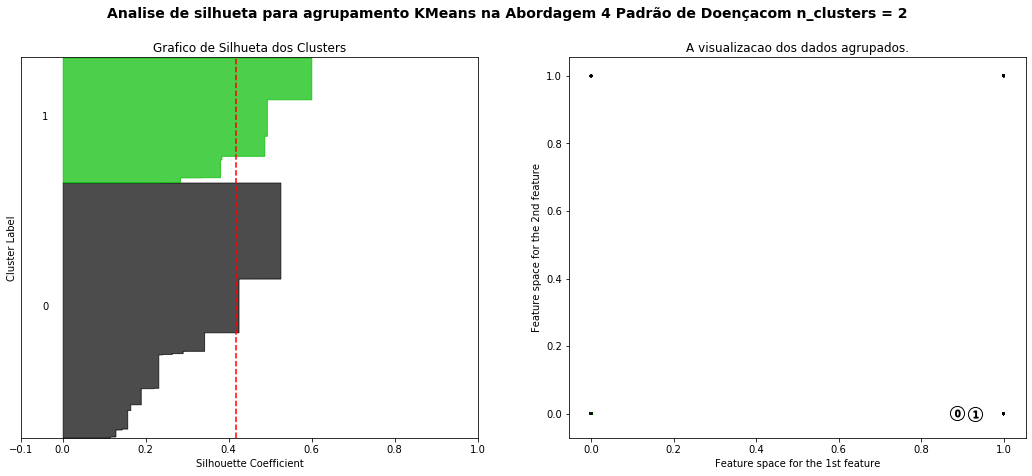

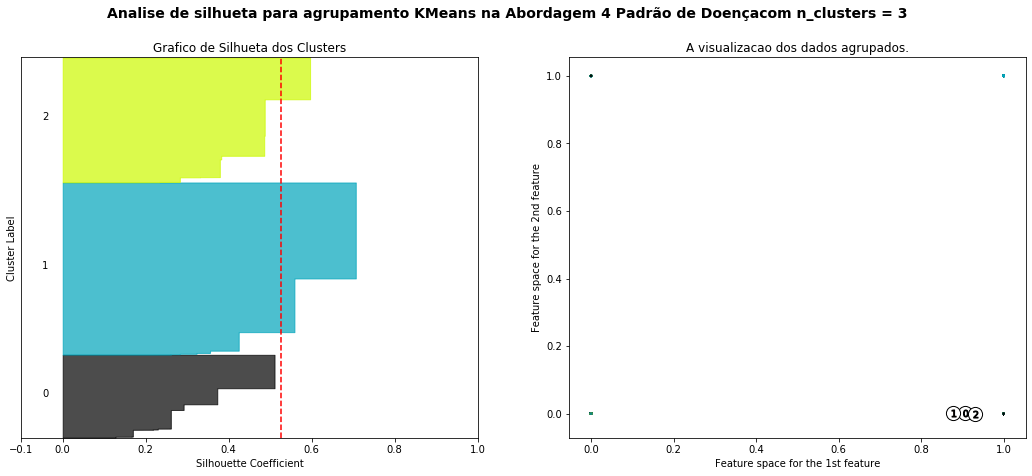

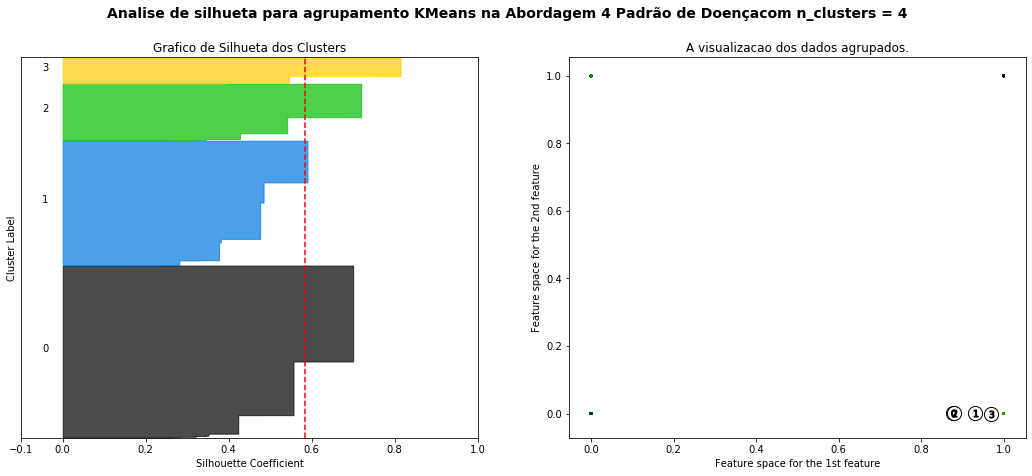

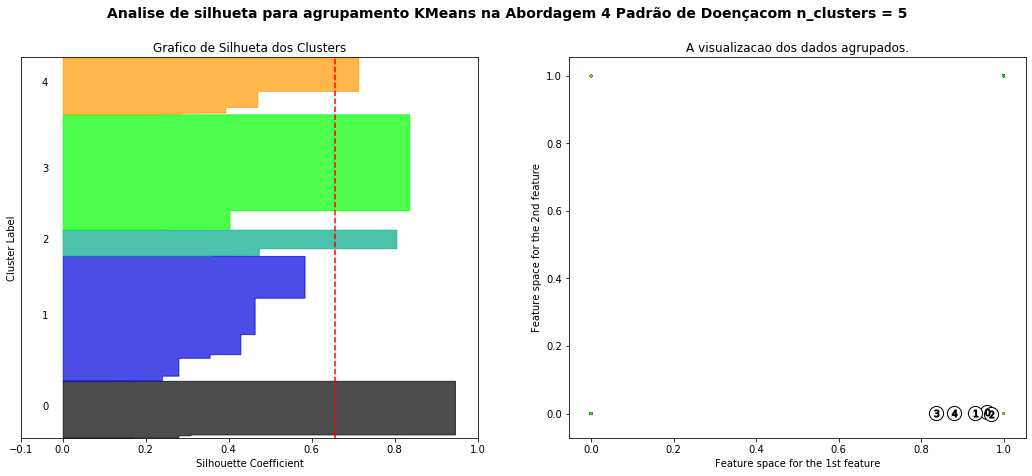

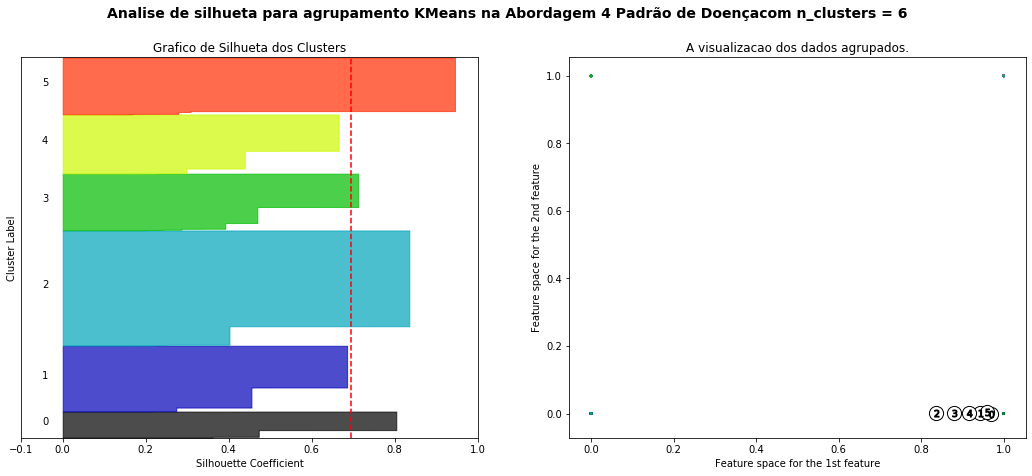

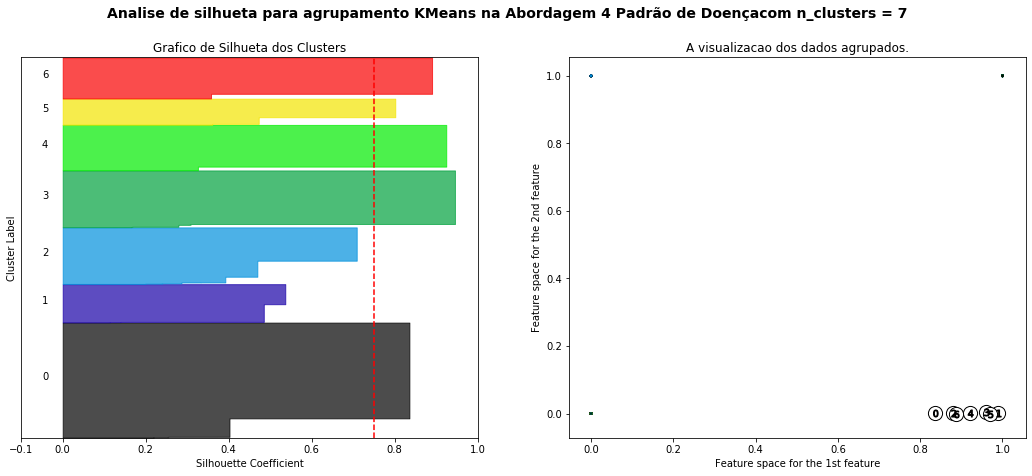

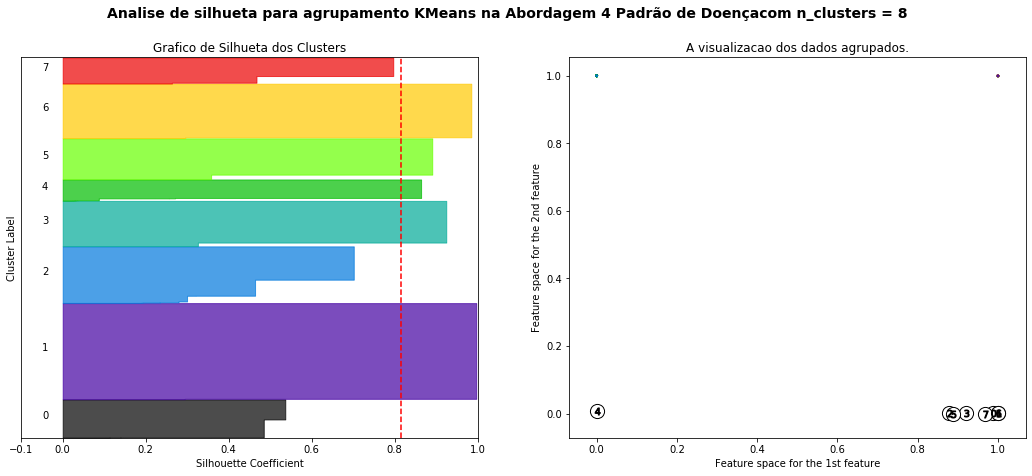

In [164]:
#Silhouette
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    # O silhouette_score fornece o valor médio para todas as amostras
    # Isso dá uma perspectiva sobre a densidade e separação das formas clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio é :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("Grafico de Silhueta dos Clusters")
    ax1.set_xlabel("Silhouette Coefficient")
    ax1.set_ylabel("Cluster Label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans na Abordagem 4 Padrão de Doença"
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_doenca_{n_clusters}.svg', format="svg")
    #fig.savefig('padrao_doencas/padrao_doencas_kmeans_'+str(n_clusters)+'.png', format='png')  

plt.show()

#fig.savefig('kmeans_padroes_doencas.png', format='png')

In [165]:
#dataset com grupos e por padrão de doencas

dataset_padrao_doenca = dataset_apos_tratamento.loc[:,'numero_identificacao':'IMC']
#dataset_padrao_doenca = dataset_apos_tratamento.loc[:,'numero_identificacao':'altura']
#dataset_padrao_doenca['IMC'] = dataset_medidas['IMC']
dataset_padrao_doenca['grupo'] = grupos
dataset_padrao_doenca['grupo'] = dataset_padrao_doenca['grupo'] + 1

dataset_padrao_doenca = pd.concat([dataset_padrao_doenca,dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)

dataset_padrao_doenca.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

In [166]:
dados_padrao_doencas

Hipotensao  Sistolica Isolada  Diastolica Isolada  Dipping  \
0            True              False               False    False   
1            True              False               False    False   
2            True              False               False    False   
3            True              False               False     True   
4            True              False               False     True   
...           ...                ...                 ...      ...   
19145        True              False               False     True   
19146        True              False               False    False   
19147        True              False               False    False   
19148        True              False               False    False   
19149        True              False               False    False   

       Non Dipping  Extreme Dipping  Reverse Dipping  Morning Surge  Masked  \
0            False            False             True          False   False   
1            False            False             True          False   False   
2             True            False            False          False   False   
3            False            False            False          False   False   
4            False            False            False          False   False   
...            ...              ...              ...            ...     ...   
19145        False            False            False           True   False   
19146         True            False            False          False   False   
19147         True            False            False          False   False   
19148        False             True            False          False   False   
19149        False            False             True          False   False   

       Whitecoat  Normotenso  
0          False       False  
1          False       False  
2           True       False  
3           True       False  
4          False       False  
...          ...         ...  
19145       True       False  
19146       True       False  
19147       True       False  
19148      False       False  
19149       True       False  

[19150 rows x 11 columns]

# Abordagem 4.1: Features Selection: Kbest  na Abordagem 4: Doenças

In [167]:
#  Uso do SelectKBest para identificar as melhores 5 features

from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

features_mais_importante_ml = SelectKBest(chi2, k=5).fit_transform(X, grupos)
features_mais_importante_ml.shape

(19150, 5)

In [168]:
# Transforma a variável acima em dataframe para automatizar a identificação de quais colunas foram escolhidas

features_mais_importante = pd.DataFrame(features_mais_importante_ml)


In [169]:
# identificação de quais colunas foram escolhidas

lista_colunas_escolhidas = []
# X é o dataset das doenças que precisa ser transformado em df
x_df = pd.DataFrame(X)
for coluna_ml in range(len(features_mais_importante.columns)):
    for coluna_base in range(len(x_df.columns)):
        # para identificar valores únicos
        if set(np.array(x_df[coluna_base]) == np.array(features_mais_importante[coluna_ml])) == {True}:
            lista_colunas_escolhidas.append(coluna_base)
            break

lista_colunas_escolhidas

# Foram escolhidas as colunas 'Diastolica Isolada', 'Dipping','Non Dipping', 'Extreme Dipping', 'Reverse Dipping'

[3, 4, 5, 6, 7]

In [170]:
#selecionando padrões de doencas

ls_doencas_kbest = ['Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping']

#ls_doencas_kbest = ['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
#       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
#       'Masked', 'Whitecoat', 'Normotenso']

dados_padrao_doencas_kbest =  dataset_apos_tratamento[ls_doencas_kbest]

## Abordagem 4.1:  K-means para SelectKbest

In [171]:
#  Cálculo do "n_clusters" considerando as colunas definidas por SelectKBest

sum_of_squares = calculate_wcss(features_mais_importante_ml)
n_kbest = optimal_number_of_clusters(sum_of_squares)
kmeans = KMeans(n_clusters=n_kbest, random_state=42).fit(features_mais_importante_ml)
grupos = kmeans.fit_predict(features_mais_importante_ml)
print(n)
print(grupos)

c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (10). Possibly due to duplicate points in X.
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (11). Possibl

8
[0 0 1 ... 1 4 0]


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:24: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (20). Possibly due to duplicate points in X.


In [172]:
# Separa o grupo de dados para treino e teste

# Feature Selection: none
#X_train, X_test, y_train, y_test = train_test_split(X, grupos, test_size=0.15, random_state=0)

# Feature Selection: SelectKBest
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)
#
#X_train.shape, y_train.shape
#
#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

###  Abordagem 4.1: Random Forest

In [173]:
from sklearn.ensemble import RandomForestClassifier

In [174]:
#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=10)

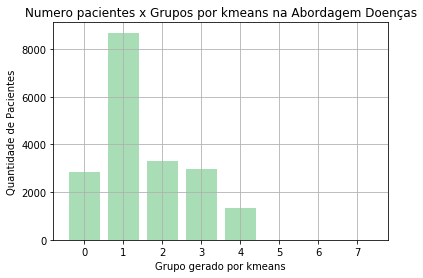

In [175]:
#base para modelo
classes = []
qtds = []

contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
plt.grid()
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()

In [176]:
#salvar a imagem
#fig.savefig('padrao_doencas/qtd_x_padrao_doencas.png', format='png')

## Train, Test, Validation

In [177]:
# Separa o grupo de dados para treino e teste
#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection: none
#X_train, X_test, y_train, y_test = train_test_split(X, grupos, test_size=0.15, random_state=42)
#x_train, x_test, y_train, y_test = train_test_split(X, grupos, test_size=1 - train_ratio,random_state=42)

# Feature Selection: SelectKBest
x_train, x_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=1 - train_ratio,random_state=42)

# Feature Selection: none
#x_val, x_test, y_val, y_test = train_test_split(X, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Feature Selection: SelectKBest
x_val, x_test, y_val, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)


# Feature Selection: SelectKBest sem validação
#X_train, X_test, y_train, y_test = train_test_split(features_mais_importante_ml, grupos, test_size=0.15, random_state=0)

#X_train.shape, y_train.shape

#X_test.shape, y_test.shape

# Feature Selection: Cross Validation
#clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#clf.score(X_test, y_test)

In [178]:
# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10)

#### Abordagem 4.1: VALIDAÇÃO

In [179]:
#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [180]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [181]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3    4  5  6  7
0  1695     0     0     0    0  0  0  0
1     0  5201     0     0    0  0  0  0
2     0     0  2015     0    0  0  0  0
3     0     0     0  1807    0  0  0  0
4     0     0     0     0  772  0  0  0
5     0     0     0     0    0  0  0  0
6     0     0     0     0    0  0  0  0
7     0     0     0     0    0  0  0  0

#### Abordagem 4.1: TESTE

In [182]:
#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [183]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [184]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3    4  5  6  7
0  1165     0     0     0    0  0  0  0
1     0  3480     0     0    0  0  0  0
2     0     0  1299     0    0  0  0  0
3     0     0     0  1172    0  0  0  0
4     0     0     0     0  544  0  0  0
5     0     0     0     0    0  0  0  0
6     0     0     0     0    0  0  0  0
7     0     0     0     0    0  0  0  0

In [185]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação e teste
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_padrao_doenca, grupos, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_padrao_doencas = x_val_[['numero_identificacao']]
pacientes_validacao_padrao_doencas['Grupo_Real'] = y_val_
pacientes_validacao_padrao_doencas['Grupo_Previsto'] = y_prev_val
pacientes_validacao_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_padrao_doencas = x_test_[['numero_identificacao']]
pacientes_teste_padrao_doencas['Grupo_Real'] = y_test_
pacientes_teste_padrao_doencas['Grupo_Previsto'] = y_prev_test
pacientes_teste_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

####  Abordagem 4.1: Importância das Features Random Forest

In [186]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

#importancia = pd.DataFrame({'features':ls_padroes_doencas,'importance':np.round(random_forest.feature_importances_,3)})

# Importância para SelctKBest
importancia = pd.DataFrame({'features':ls_doencas_kbest,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
1             Dipping       0.381
4     Reverse Dipping       0.237
0  Diastolica Isolada       0.174
3     Extreme Dipping       0.145
2         Non Dipping       0.063

# Abordagem 5 doença sem extremos (Sem Hipotensão e sem Normotenso)

In [187]:
#   Doenças SEM Hipotensão

ls_doencas = list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns)
ls_doencas = ls_doencas[1:]

#  O índice zero é a 1a. coluna de doença que vai até 9 (a última até Whitecoat)
#  Usar esse comando para a abordagem em cada uma das doenças separadamente
#grupos_doenca = np.array(dataset_apos_tratamento[ls_doencas[0]])

#  Usar esse comando para a abordagem de um range de doenças. Aqui não entrou Hipotensão, nem Normotenso
escolho_doenca = np.array(dataset_apos_tratamento[ls_doencas])

In [188]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares = calculate_wcss(escolho_doenca)
n = optimal_number_of_clusters(sum_of_squares)
print (n)

#habilitando o kmeans com 7 grupos (foi calculado na etapa anterior)
kmeans = KMeans(n_clusters=n, random_state=42).fit(escolho_doenca)

#listar os grupos 
grupo_escolho_doenca = kmeans.fit_predict(escolho_doenca)

#incluir grupos nos dados de sist e diast

grupo_df = pd.DataFrame()
grupo_df['grupo'] = grupo_escolho_doenca
grupo_df['grupo'] = grupo_df['grupo'] + 1

dados_completos_escolho_doenca = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    grupo_df['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}

dados_completos_escolho_doenca = dados_completos_escolho_doenca.replace(genero_M_F)

#dados_completos_escolho_doenca = dados_completos_generico
#dados_completos_escolho_doenca['grupo'] = grupo_escolho_doenca
#dados_completos_escolho_doenca['grupo'] = dados_completos_escolho_doenca['grupo'] + 1

Wall time: 2.27 s
7


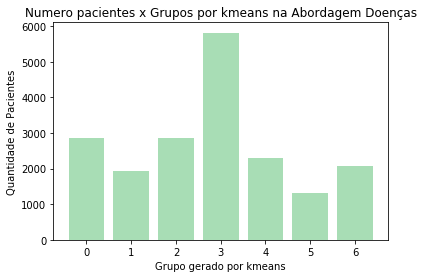

In [189]:
#     Aplicação do RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier

#    Aplicação do modelo com parâmetro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = []
qtds = []

contagem = Counter(grupo_escolho_doenca)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()

In [190]:
#  Separação dos dados em Treino, Test e Validação
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(escolho_doenca, grupo_escolho_doenca, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(escolho_doenca, grupo_escolho_doenca, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

In [191]:
#### Abordagem 5: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0     1     2     3     4    5     6
0  1694     0     0     0     0    0     0
1     0  1191     0     0     0    0     0
2     0     0  1694     0     0    0     0
3     0     0     0  3507     0    0     0
4     0     0     0     0  1392    0     0
5     0     0     0     0     0  772     0
6     0     0     0     0     0    0  1240

In [192]:
#### Abordagem 5: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0    1     2     3    4    5    6
0  1174    0     0     0    0    0    0
1     0  742     0     0    0    0    0
2     0    0  1165     0    0    0    0
3     0    0     0  2306    0    0    0
4     0    0     0     0  898    0    0
5     0    0     0     0    0  544    0
6     0    0     0     0    0    0  831

In [193]:
####  Abordagem 5: Importância das Features Random Forest

#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais


importancia = pd.DataFrame({'features':ls_doencas,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_sem_hipo_normo.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
8           Whitecoat       0.349
3         Non Dipping       0.188
5     Reverse Dipping       0.141
2             Dipping       0.126
6       Morning Surge       0.125
4     Extreme Dipping       0.070
0   Sistolica Isolada       0.000
1  Diastolica Isolada       0.000
7              Masked       0.000

# Abordagem 6: escolho doença

In [194]:
ls_doencas = list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns)
ls_medidas = list(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'].columns)

#  O índice zero é a 1a. coluna de doença que vai até 9 (a última até Whitecoat)
grupos_doenca = np.array(dataset_apos_tratamento[ls_doencas[0]])

dados_medidas_novo = np.array(dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45'])
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = [0,1]
qtds = []

'''contagem = Counter(grupos)

for i in range(0,n):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Doenças')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem3_doenca_por_grupos.svg',format="svg")
plt.show()'''
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

In [195]:
# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(dados_medidas_novo, grupos_doenca, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(dados_medidas_novo, grupos_doenca, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

In [196]:
#### Abordagem 6: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9997389033942559 - Recall: 0.9987468671679198 - F1 Score: 0.9992997929910192


In [197]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0      1
0  1194      3
1     0  10293

In [198]:
#### Abordagem 6: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9550913838120104 - Recall: 0.8011843185550083 - F1 Score: 0.8447221293122692


In [199]:
#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1
0  429   271
1   73  6887

In [200]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação e teste
x_train_, x_test_, y_train_, y_test_ = train_test_split(dados_medidas_novo, grupos_doenca, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dados_medidas_novo, grupos_doenca, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

##validacao
#pacientes_validacao_padrao_doencas = x_val_[['numero_identificacao']]
#pacientes_validacao_padrao_doencas['Grupo_Real'] = y_val_
#pacientes_validacao_padrao_doencas['Grupo_Previsto'] = y_prev_val
#pacientes_validacao_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_doenca.csv', 
#             sep=';',index=False,encoding='UTF-8')

##teste
#pacientes_teste_padrao_doencas = x_test_[['numero_identificacao']]
#pacientes_teste_padrao_doencas['Grupo_Real'] = y_test_
#pacientes_teste_padrao_doencas['Grupo_Previsto'] = y_prev_test
#pacientes_teste_padrao_doencas.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_doenca.csv', 
#             sep=';',index=False,encoding='UTF-8')

####  Abordagem 6: Importância das Features Random Forest

In [201]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais

importancia = pd.DataFrame({'features':ls_medidas,'importance':np.round(random_forest.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_escolho_doenca.csv', 
             sep=';',index=False,encoding='UTF-8')
importancia

features  importance
146  diast 3:00       0.025
148  diast 4:00       0.025
149  diast 4:30       0.024
153  diast 6:15       0.023
147  diast 3:30       0.019
..          ...         ...
75    sist 7:15       0.003
79    sist 8:15       0.003
50   sist 21:30       0.003
44   sist 20:00       0.003
71    sist 6:15       0.003

[164 rows x 2 columns]

# Abordagem 7: por Categorias 

In [202]:
#dataset_por_classes[ls_classes]
#ls_classes

In [203]:
#convertendo os dados para entrega ao Random - Classifcação

#ls_classes = list(dataset_por_classes.loc[:,'genero':].columns)

#genero_M_F1 = {"genero": {"M":1, "F":0}}
#dataset_por_classes = dataset_por_classes.replace(genero_M_F1)

ls_classes = list((dataset_por_classes.drop(list(dataset_por_classes.loc[:,'sist 9:00':'diast 8:45'].columns),axis=1)).drop('numero_identificacao',axis=1).columns)

array_classes = np.array(dataset_por_classes[ls_classes])

print (dataset_por_classes)


       numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      3    3      105.0      108.0   
1                         5       1      3    2      103.0      114.0   
2                         6       1      1    2      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    3      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19145                 21786       1      1    2      163.0      198.0   
19146                 21787       1      1    2      114.0      120.0   
19147                 21788       0      1    3      107.0      110.0   
19148                 21792       0      3    2       94.0      107.0   
19149                 21793       1      1    3      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Hipotensao  \
0          116.0      104.0       106.0        98.0

In [204]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)

sum_of_squares = calculate_wcss(array_classes)
n_classes = optimal_number_of_clusters(sum_of_squares)
print (n_classes)


8


In [205]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans_classes = KMeans(n_clusters=n_classes, random_state=42).fit(array_classes)


#listar os grupos 

grupos_classes = kmeans_classes.fit_predict(array_classes)


grupos_classes


array([4, 4, 1, ..., 7, 4, 7])

In [206]:
#  Inclui a coluna Grupo no dataset que será gravado no final
dataset_por_classes['grupo'] = grupos_classes 
dataset_por_classes['grupo'] = dataset_por_classes['grupo'] + 1

In [207]:
dataset_por_classes

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      3    3      105.0      108.0   
1                         5       1      3    2      103.0      114.0   
2                         6       1      1    2      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    3      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19145                 21786       1      1    2      163.0      198.0   
19146                 21787       1      1    2      114.0      120.0   
19147                 21788       0      1    3      107.0      110.0   
19148                 21792       0      3    2       94.0      107.0   
19149                 21793       1      1    3      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Sistolica Isolada  \
0          116.0      104.0       106.0        98.0  ...                  0   
1           82.0      104.0        98.0       106.0  ...                  0   
2          156.0      140.0       130.0       132.0  ...                  0   
3          142.0      137.0       135.0       177.0  ...                  0   
4          101.0      108.0       111.0       111.0  ...                  0   
...          ...        ...         ...         ...  ...                ...   
19145      172.0      148.0       161.0       156.0  ...                  0   
19146      164.0      116.0       119.0       126.0  ...                  0   
19147      103.0      105.0       108.0       111.0  ...                  0   
19148      112.0      124.0       120.0        94.0  ...                  0   
19149      103.0      101.0        97.0       110.0  ...                  0   

       Diastolica Isolada  Dipping  Non Dipping  Extreme Dipping  \
0                       0        0            0                0   
1                       0        0            0                0   
2                       0        0            1                0   
3                       0        1            0                0   
4                       0        1            0                0   
...                   ...      ...          ...              ...   
19145                   0        1            0                0   
19146                   0        0            1                0   
19147                   0        0            1                0   
19148                   0        0            0                1   
19149                   0        0            0                0   

       Reverse Dipping  Morning Surge  Masked  Whitecoat  grupo  
0                    1              0       0          0      5  
1                    1              0       0          0      5  
2                    0              0       0          1      2  
3                    0              0       0          1      7  
4                    0              0       0          0      6  
...                ...            ...     ...        ...    ...  
19145                0              1       0          1      7  
19146                0              0       0          1      2  
19147                0              0       0          1      8  
19148                0              0       0          0      5  
19149                1              0       0          1      8  

[19150 rows x 179 columns]

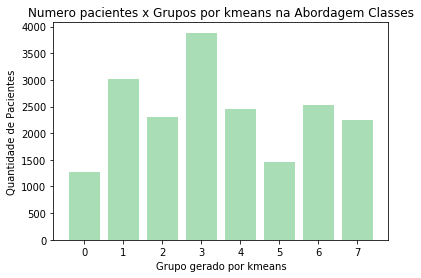

In [208]:
from sklearn.ensemble import RandomForestClassifier

#parametro simples do modelo
random_forest_classes = RandomForestClassifier(n_estimators=50)

#base para modelo
classes = []
qtds = []

contagem = Counter(grupos_classes)

for i in range(0,n_classes):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid
plt.title('Numero pacientes x Grupos por kmeans na Abordagem Classes')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_AbordagemClasses_doenca_por_grupos.svg',format="svg")
plt.show()

In [209]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# Feature Selection
x_train, x_test, y_train, y_test = train_test_split(array_classes, grupos_classes, test_size=1 - train_ratio,random_state=42)

# Feature Selection
x_val, x_test, y_val, y_test = train_test_split(array_classes, grupos_classes, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

# Aplicação do modelo Random Forest no conjunto de dados de treino
random_forest_classes.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

In [210]:
#### Abordagem 7: VALIDAÇÃO

#calcular acuracia, recall e f1
y_prev_val = random_forest_classes.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0     1     2     3     4    5     6     7
0  765     0     0     0     0    0     0     0
1    0  1804     0     0     0    0     0     0
2    0     0  1398     0     0    0     0     0
3    0     0     0  2317     0    0     0     0
4    0     0     0     0  1438    0     0     0
5    0     0     0     0     0  884     0     0
6    0     0     0     0     0    0  1540     0
7    0     0     0     0     0    0     0  1344

In [211]:
#### Abordagem 7: TESTE

#calcular acuracia, recall e f1
y_prev_test = random_forest_classes.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

#Matriz de Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


0     1    2     3     4    5    6    7
0  503     0    0     0     0    0    0    0
1    0  1209    0     0     0    0    0    0
2    0     0  899     0     0    0    0    0
3    0     0    0  1567     0    0    0    0
4    0     0    0     0  1006    0    0    0
5    0     0    0     0     0  584    0    0
6    0     0    0     0     0    0  988    0
7    0     0    0     0     0    0    0  904

In [212]:
# Importância para Categorias

importancia = pd.DataFrame({'features':ls_classes,'importance':np.round(random_forest_classes.feature_importances_,3)})

importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_categoria.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
1                idade       0.319
2                  IMC       0.249
7          Non Dipping       0.154
6              Dipping       0.103
9      Reverse Dipping       0.076
8      Extreme Dipping       0.051
10       Morning Surge       0.033
0               genero       0.010
3           Hipotensao       0.001
12           Whitecoat       0.001
4    Sistolica Isolada       0.000
5   Diastolica Isolada       0.000
11              Masked       0.000

# Abordagem 8: Extratificação do Sexo Masculino

In [213]:
#   Gera uma lista com cabeçalhos

ls_sist_diast = list(dataset_masc_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dataset_masc_medidas_sem_id = dataset_masc_medidas.loc[:,'sist 9:00':'diast 8:45']

dataset_masc_medidas_sem_id


sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
0          105.0      108.0      116.0      104.0       106.0        98.0   
1          103.0      114.0       82.0      104.0        98.0       106.0   
2          147.0      148.0      156.0      140.0       130.0       132.0   
4          113.0      110.0      101.0      108.0       111.0       111.0   
5          152.0      152.0      152.0      152.0       154.0       138.0   
...          ...        ...        ...        ...         ...         ...   
19139      105.0      117.0       86.0      110.0       114.0       117.0   
19144      119.0      116.0      113.0      110.0       115.0       117.0   
19145      163.0      198.0      172.0      148.0       161.0       156.0   
19146      114.0      120.0      164.0      116.0       119.0       126.0   
19149      111.0      104.0      103.0      101.0        97.0       110.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:30  \
0           102.0       107.0       111.0       116.0  ...        41.0   
1           108.0       107.0       109.0       100.0  ...        74.0   
2           121.0       113.0       149.0       128.0  ...        80.0   
4           114.0       115.0       113.0       112.0  ...        64.0   
5           137.0       152.0        95.0       117.0  ...        67.0   
...           ...         ...         ...         ...  ...         ...   
19139       119.0       119.0       119.0        96.0  ...        78.0   
19144       112.0       119.0       111.0       112.0  ...        83.0   
19145       156.0       138.0       107.0        76.0  ...       102.0   
19146       123.0       122.0       122.0       159.0  ...        87.0   
19149       111.0       116.0       104.0       121.0  ...        67.0   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
0            46.0        51.0        56.0        61.0        67.0        61.0   
1            74.0        74.0        70.0        67.0        63.0        60.0   
2            86.0        93.0        91.0        89.0        87.0        86.0   
4            73.0        83.0        93.0        68.0        91.0        87.0   
5            94.0       120.0       109.0       109.0       110.0       111.0   
...           ...         ...         ...         ...         ...         ...   
19139        78.0        77.0        65.0        64.0        54.0        60.0   
19144        80.0        78.0        72.0        66.0        70.0        75.0   
19145       114.0       126.0       125.0       124.0       123.0       123.0   
19146        73.0        59.0        74.0        68.0        86.0        96.0   
19149        68.0        69.0        71.0        73.0        56.0        57.0   

       diast 8:15  diast 8:30  diast 8:45  
0            69.0        62.0        51.0  
1            74.0        70.0        67.0  
2            87.0        82.0        82.0  
4            84.0        81.0        72.0  
5           112.0       114.0       115.0  
...           ...         ...         ...  
19139        62.0        65.0        63.0  
19144        66.0        83.0        82.0  
19145       121.0       119.0       123.0  
19146       107.0       106.0        93.0  
19149        65.0        68.0        82.0  

[8705 rows x 164 columns]

## Abordagem 8: Número de Clusters gerado pelo k-Means

In [214]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_masc = calculate_wcss(dataset_masc_medidas_sem_id)
num_otimo_clusters_masc = optimal_number_of_clusters(sum_of_squares_masc)
num_otimo_clusters_masc

Wall time: 18.1 s


6

In [215]:
#convertendo os dados para a clusterização

dataset_masc_medidas_array = np.array(dataset_masc_medidas_sem_id)

In [216]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_masc = KMeans(n_clusters=num_otimo_clusters_masc, random_state=42).fit(dataset_masc_medidas_array)

In [217]:
#listar os grupos 

%time grupos_masc = kmeans_masc.fit_predict(dataset_masc_medidas_array)

Wall time: 576 ms


##  Abordagem 8: Método Elbow
###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

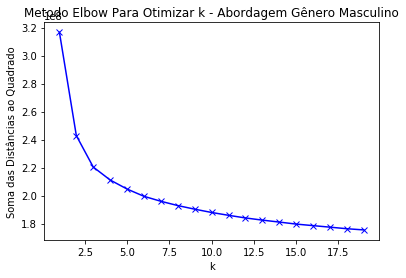

Wall time: 82.3 ms


In [218]:
#metodo de Elbow

Sum_of_squared_distances_masc = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_masc_medidas_array)
    Sum_of_squared_distances_masc.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances_masc, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Gênero Masculino')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medidas_masc.svg', format="svg")
%time plt.show()

## Abordagem 8: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.19933593626581944
Para n_clusters = 3 O score_silhouette medio e : 0.12665649930042538
Para n_clusters = 4 O score_silhouette medio e : 0.08101733409423562
Para n_clusters = 5 O score_silhouette medio e : 0.07640817556426945
Para n_clusters = 6 O score_silhouette medio e : 0.061038950050893624
Para n_clusters = 7 O score_silhouette medio e : 0.057991398820250256
Para n_clusters = 8 O score_silhouette medio e : 0.05527561990135967


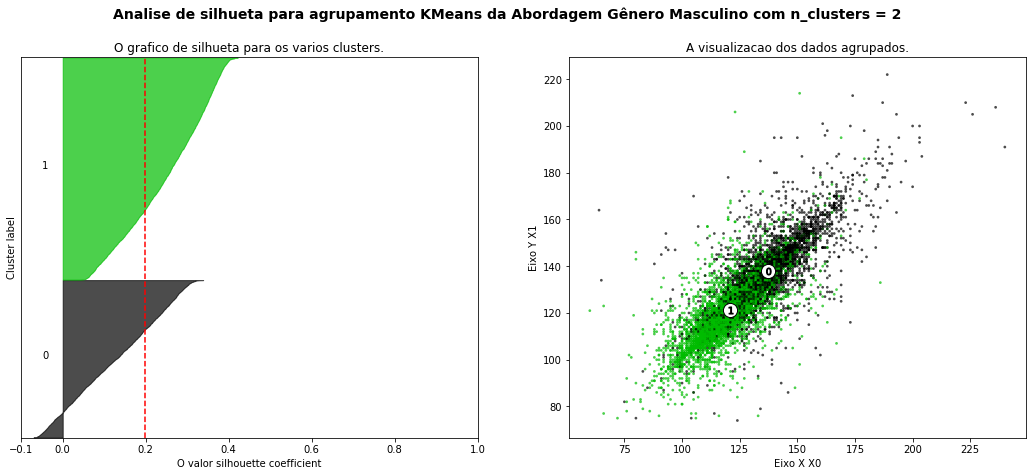

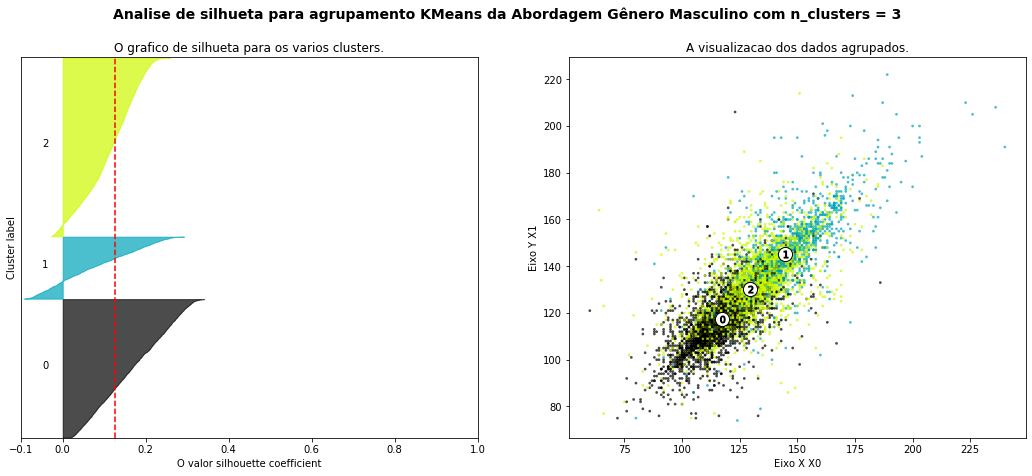

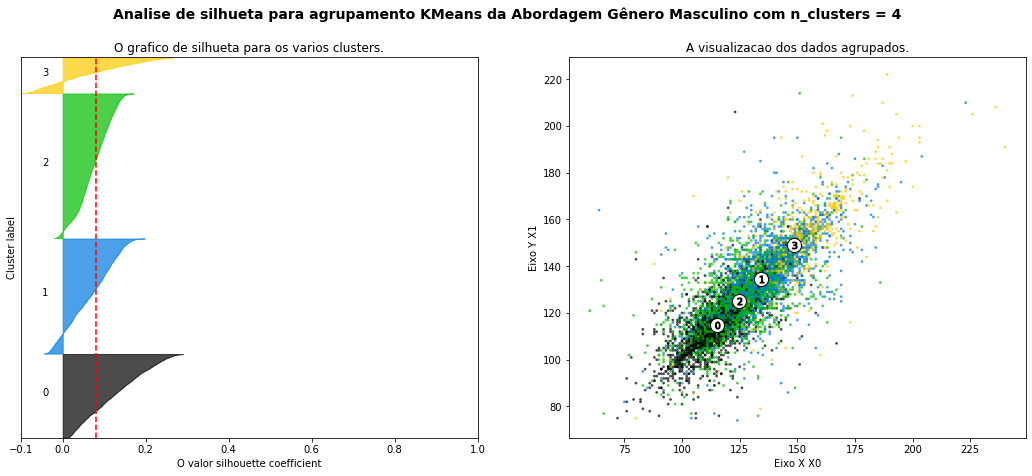

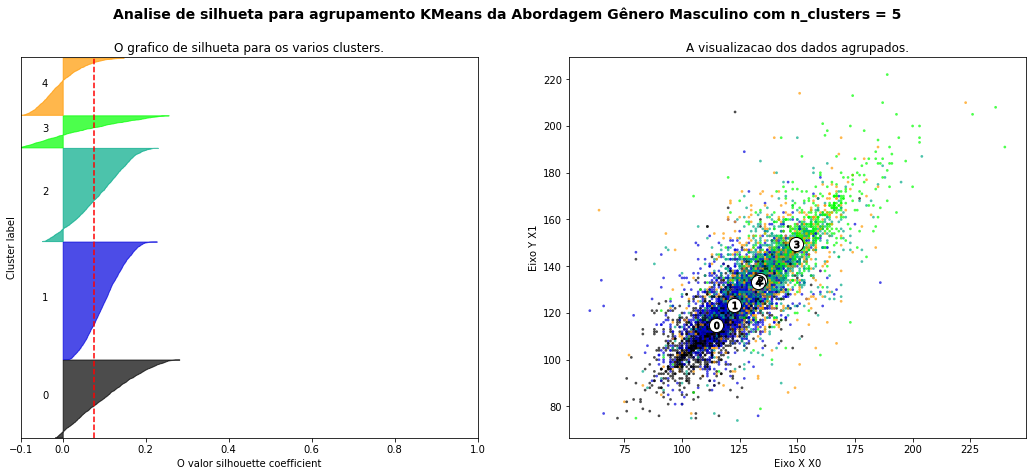

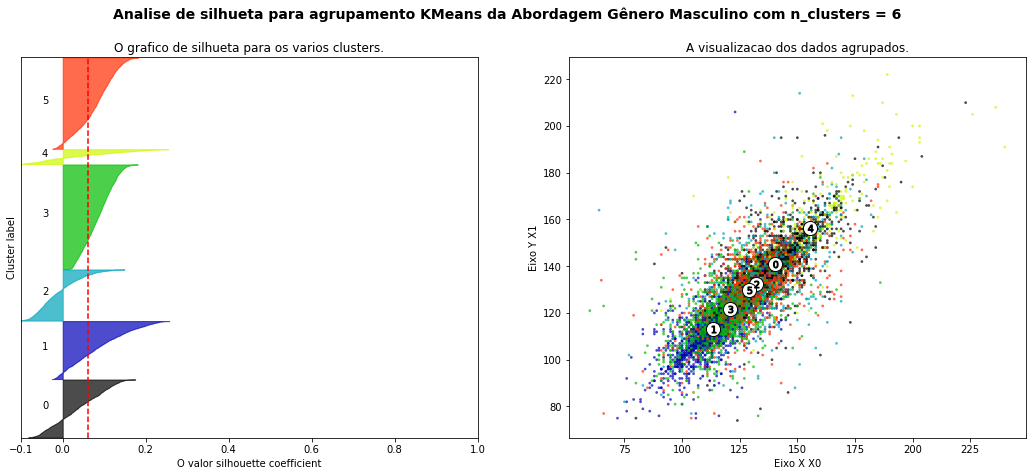

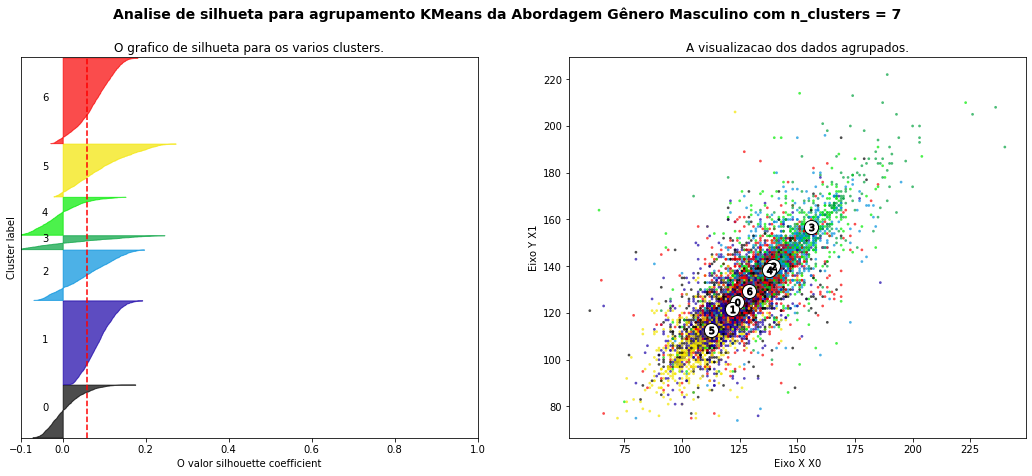

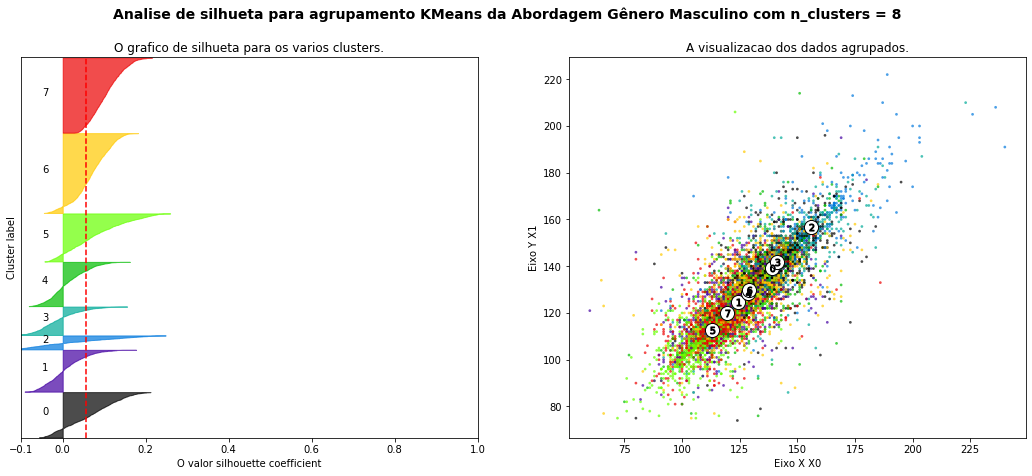

In [219]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dataset_masc_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dataset_masc_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dataset_masc_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dataset_masc_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dataset_masc_medidas_array[:, 0], dataset_masc_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Gênero Masculino "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_masc_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [220]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
genero_M_F = {"genero": {1: "M", 0: "F"}}

dataset_masc_apos_kmeans = dataset_masc.loc[:,'numero_identificacao':'data_exame']

dataset_masc_apos_kmeans['grupo'] = grupos_masc

dataset_masc_apos_kmeans['grupo'] = dataset_masc_apos_kmeans['grupo'] + 1

dataset_masc_apos_kmeans = pd.concat([dataset_masc_apos_kmeans,
                                         dataset_masc.loc[:,'sist 9:00':]],axis=1)

dataset_masc_apos_kmeans = dataset_masc_apos_kmeans.replace(genero_M_F)

# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_masc_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')

dataset_masc_apos_kmeans

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
0                         4      1923-10-05      M   94.0   85.0    160  33.2   
1                         5      1948-10-07      M   70.0   80.0    165  29.4   
2                         6      1999-03-23      M   19.0  100.0    197  25.8   
4                         8      1990-03-07      M   28.0  120.0    172  40.6   
5                         9      1982-04-28      M   36.0  100.0    185  29.2   
...                     ...             ...    ...    ...    ...    ...   ...   
19139                 21775      1955-09-04      M   65.0   94.0   1,83  28.1   
19144                 21783      1969-05-24      M   51.0   93.0    168  33.0   
19145                 21786      1972-11-25      M   47.0   75.0    165  27.5   
19146                 21787      1970-10-19      M   49.0   90.0    183  26.9   
19149                 21793      1971-01-14      M   49.0   99.0    179  30.9   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
0      2018-09-10 12:25:23      2      105.0  ...                       59.0   
1      2018-12-26 07:39:41      2      103.0  ...                       62.0   
2      2018-12-26 08:06:19      3      147.0  ...                       79.0   
4      2018-12-26 08:26:59      4      113.0  ...                       78.0   
5      2018-12-26 09:56:35      5      152.0  ...                      104.5   
...                    ...    ...        ...  ...                        ...   
19139  2020-09-10 14:40:03      4      105.0  ...                       78.0   
19144  2020-09-10 15:40:30      4      119.0  ...                       74.0   
19145  2020-09-10 16:03:08      5      163.0  ...                      116.0   
19146  2020-09-10 16:21:02      1      114.0  ...                       85.0   
19149  2020-09-10 17:42:01      6      111.0  ...                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
4                    9141.5                 6118.0          2405.0   
5                   11583.0                 8198.0          2783.5   
...                     ...                    ...             ...   
19139                9742.5                 6171.5          2984.5   
19144                9121.5                 5963.5          2605.0   
19145               12224.5                 9265.0          2439.0   
19146               10970.0                 6819.0          3319.0   
19149                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
4                 566.0                12.27                 12.79   
5                 558.5                10.83                 12.82   
...                 ...                  ...                   ...   
19139             546.0                14.42                  8.85   
19144             513.0                14.69                 11.86   
19145             474.5                18.66                 14.80   
19146             738.0                17.22                 13.67   
19149             612.0                13.92                 12.71   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
0                   11                34             0.966110  
1                    9                23             0.969464  
2                   19                19             1.055812  
4                   10                11             1.136996  
5                   37                52             1.051359  
...    

### Abordagem 8: Random Forest

In [221]:
from sklearn.ensemble import RandomForestClassifier

In [222]:
#parametro simples do modelo
random_forest_masc = RandomForestClassifier(n_estimators=50)

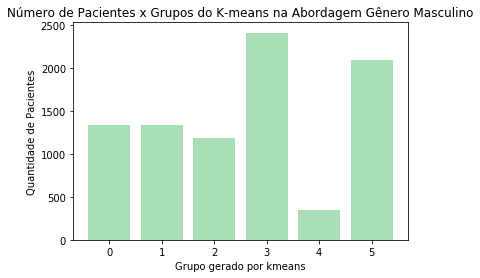

In [223]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_masc)

for i in range(0,num_otimo_clusters_masc):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Gênero Masculino')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem9_pacientes_masculino_por_grupos.svg',format="svg")
plt.show()


In [224]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dataset_masc_medidas_array, grupos_masc, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dataset_masc_medidas_array, grupos_masc, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [225]:
#treino
random_forest_masc.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 8: VALIDAÇÃO

In [226]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_masc.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [227]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [228]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1    2     3    4     5
0  810    0    0     0    0     0
1    0  794    0     0    0     0
2    0    0  726     0    0     0
3    0    0    0  1485    0     0
4    0    0    0     0  191     0
5    0    0    0     0    0  1217

#### Abordagem 8: TESTE

In [229]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_masc.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

In [230]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9187248707639287 - Recall: 0.8883630795537508 - F1 Score: 0.9068637375572787


In [231]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1    2    3    4    5
0  483    0    8    0    0   34
1    0  508    3   33    0    0
2    9    2  395   32    0   16
3    0   14    7  882    0   23
4   42    0    0    0  109    0
5   17    0    6   37    0  822

In [232]:
dataset_masc_apos_kmeans.describe()


numero_identificacao        idade         peso          IMC  \
count           8705.000000  8705.000000  8705.000000  8705.000000   
mean           10844.504423    53.200574    85.753820    28.297002   
std             6290.093497    15.636517    16.125461     4.516502   
min                4.000000    18.000000    44.000000    15.000000   
25%             5393.000000    41.000000    75.000000    25.300000   
50%            10814.000000    52.000000    84.000000    27.700000   
75%            16324.000000    65.000000    95.000000    30.500000   
max            21793.000000   100.000000   200.000000    85.400000   

             grupo    sist 9:00    sist 9:15    sist 9:30    sist 9:45  \
count  8705.000000  8705.000000  8705.000000  8705.000000  8705.000000   
mean      3.618495   127.595405   128.058242   128.241815   128.129121   
std       1.728931    16.386471    16.553089    16.544239    16.338752   
min       1.000000    60.000000    74.000000    62.000000    63.000000   
25%       2.000000   117.000000   117.000000   118.000000   118.000000   
50%       4.000000   127.000000   127.000000   127.000000   127.000000   
75%       5.000000   137.000000   138.000000   138.000000   138.000000   
max       6.000000   240.000000   222.000000   257.000000   230.000000   

        sist 10:00  ...  Mediana Diastolica em 24h  AUC Sistolica em 24h  \
count  8705.000000  ...                8705.000000           8705.000000   
mean    127.882941  ...                  79.809190          10042.388397   
std      16.263632  ...                   9.405423            883.629654   
min      62.000000  ...                  43.000000           7438.500000   
25%     117.000000  ...                  73.500000           9439.500000   
50%     127.000000  ...                  79.500000           9966.000000   
75%     137.000000  ...                  86.000000          10532.000000   
max     232.000000  ...                 132.000000          15047.500000   

       AUC Diastolica em 24h  AUC PP Daytime  AUC PP Nighttime  \
count            8705.000000     8705.000000       8705.000000   
mean             6413.391212     2992.200862        590.611430   
std               724.989507      542.354627        111.082551   
min              3674.500000     1706.000000        301.000000   
25%              5925.500000     2608.000000        513.500000   
50%              6380.000000     2917.500000        574.500000   
75%              6859.500000     3289.000000        651.000000   
max             10530.500000     5885.000000       1250.500000   

       DP Sistolica em 24h  DP Diastolica em 24h  Picos Sistolica  \
count          8705.000000           8705.000000      8705.000000   
mean             12.545723             10.709521        15.394945   
std               3.189435              2.319657        13.192884   
min               5.070000              3.980000         0.000000   
25%              10.310000              9.050000         6.000000   
50%              12.120000             10.520000        11.000000   
75%              14.280000             12.130000        20.000000   
max              38.360000             23.850000        81.000000   

       Picos Diastolica  Diferença % Dipping  
count       8705.000000          8705.000000  
mean          21.118093             1.086480  
std           14.506403             0.080127  
min            0.000000             0.784534  
25%           11.000000             1.034540  
50%           17.000000             1.086405  
75%           28.000000             1.137554  
max           79.000000             1.491723  

[8 rows x 194 columns]

In [233]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_masc_apos_kmeans, grupos_masc, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_masc_apos_kmeans, grupos_masc, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 8: Importância das Features Random Forest

In [234]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_masc.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas_masc.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia

features  importance
46    sist 20:30       0.015
95   diast 12:15       0.015
73     sist 6:45       0.014
90   diast 11:00       0.014
40    sist 19:00       0.012
..           ...         ...
146   diast 3:00       0.003
145   diast 2:30       0.003
144   diast 2:00       0.003
148   diast 4:00       0.003
154   diast 6:30       0.002

[164 rows x 2 columns]

# Abordagem 9: Extratificação do Sexo Feminino

In [235]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45

#   Gera uma lista com cabeçalhos
ls_sist_diast = list(dataset_fem_medidas.loc[:,'sist 9:00':'diast 8:45'].columns)

dataset_fem_medidas_sem_id = dataset_fem_medidas.loc[:,'sist 9:00':'diast 8:45']

dataset_fem_medidas_sem_id


sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
3          140.0      139.0      142.0      137.0       135.0       177.0   
9          131.0      131.0      130.0      129.0       129.0       111.0   
10         107.0      110.0      113.0      116.0       120.0       108.0   
11         166.0      171.0      176.0      181.0       186.0       192.0   
13         142.0      123.0      124.0      135.0       147.0       159.0   
...          ...        ...        ...        ...         ...         ...   
19141      137.0      121.0      118.0      148.0       111.0       115.0   
19142      153.0      149.0      136.0      152.0       157.0       153.0   
19143      121.0      123.0      125.0      122.0       120.0       118.0   
19147      107.0      110.0      103.0      105.0       108.0       111.0   
19148       94.0      107.0      112.0      124.0       120.0        94.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  diast 6:30  \
3           148.0       152.0       135.0       136.0  ...        49.0   
9           122.0       133.0       144.0       155.0  ...        58.0   
10          105.0       108.0       114.0       105.0  ...        57.0   
11          177.0       168.0       159.0       150.0  ...        79.0   
13          142.0       141.0       133.0       141.0  ...        83.0   
...           ...         ...         ...         ...  ...         ...   
19141       111.0       128.0       136.0       133.0  ...        70.0   
19142       141.0       135.0       136.0       134.0  ...        88.0   
19143       120.0       117.0       121.0       149.0  ...        66.0   
19147       114.0       144.0       128.0       104.0  ...        49.0   
19148       102.0       113.0       104.0        96.0  ...        63.0   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
3            56.0        62.0        83.0       104.0        99.0        94.0   
9            99.0       140.0        67.0        81.0        95.0        94.0   
10           61.0        65.0        70.0        66.0        78.0        67.0   
11           98.0       116.0       114.0       113.0       111.0       110.0   
13           76.0        68.0        86.0        64.0       100.0        88.0   
...           ...         ...         ...         ...         ...         ...   
19141        61.0        52.0        50.0        52.0        65.0        72.0   
19142        90.0        93.0       104.0        94.0        91.0        99.0   
19143        66.0        67.0        65.0        85.0        82.0        82.0   
19147        50.0        50.0        53.0        52.0        62.0        68.0   
19148        63.0        64.0        76.0        72.0        69.0        75.0   

       diast 8:15  diast 8:30  diast 8:45  
3            89.0        90.0        72.0  
9            94.0        94.0        93.0  
10           73.0        75.0        66.0  
11          108.0       107.0       105.0  
13          110.0       119.0        90.0  
...           ...         ...         ...  
19141        79.0        57.0        77.0  
19142        96.0       103.0        98.0  
19143        85.0        87.0        86.0  
19147        61.0        64.0        60.0  
19148        74.0        69.0        67.0  

[10445 rows x 164 columns]

## Abordagem 9: Número de Clusters gerado pelo k-Means

In [236]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_fem = calculate_wcss(dataset_fem_medidas_sem_id)
num_otimo_clusters_fem = optimal_number_of_clusters(sum_of_squares_fem)
num_otimo_clusters_fem

Wall time: 26.8 s


7

In [237]:
#convertendo os dados para a clusterização

dataset_fem_medidas_array = np.array(dataset_fem_medidas_sem_id)

In [238]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_fem = KMeans(n_clusters=num_otimo_clusters_fem, random_state=42).fit(dataset_fem_medidas_array)

In [239]:
#listar os grupos 

grupos_fem = kmeans_fem.fit_predict(dataset_fem_medidas_array)

##  Abordagem 9: Método Elbow
###  Esse método para calcular o melhor número de cluster para o algoritmo e mostar o gráfico
###  https://minerandodados.com.br/algoritmo-k-means-python-passo-passo/#:~:text=O%20m%C3%A9todo%20Elbow%20se%20trata,um%20valor%20significativo%20de%20ganho.

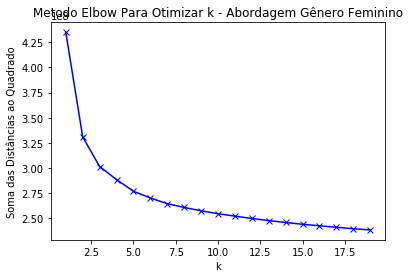

Wall time: 90 ms


In [240]:
#metodo de Elbow

Sum_of_squared_distances_fem = []
K = range(1,20)

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_fem_medidas_array)
    Sum_of_squared_distances_fem.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances_fem, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma das Distâncias ao Quadrado')
plt.title('Metodo Elbow Para Otimizar k - Abordagem Gênero Feminino')
fig = plt.gcf() 
fig.savefig( DIR_KMEANS / 'graficos' / f'metodoelbow_medidas_fem.svg', format="svg")
%time plt.show()

## Abordagem 9: Silhouette

####  A análise da Silhouette pode ser usada para determinar o grau de separação entre os clusters. O coeficiente de Silhouette quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster



Para n_clusters = 2 O score_silhouette medio e : 0.21434336093635475
Para n_clusters = 3 O score_silhouette medio e : 0.12850747989800515
Para n_clusters = 4 O score_silhouette medio e : 0.11203160026665515
Para n_clusters = 5 O score_silhouette medio e : 0.0773993297523967
Para n_clusters = 6 O score_silhouette medio e : 0.07210989175642002
Para n_clusters = 7 O score_silhouette medio e : 0.05524409149781212
Para n_clusters = 8 O score_silhouette medio e : 0.05385941095876853


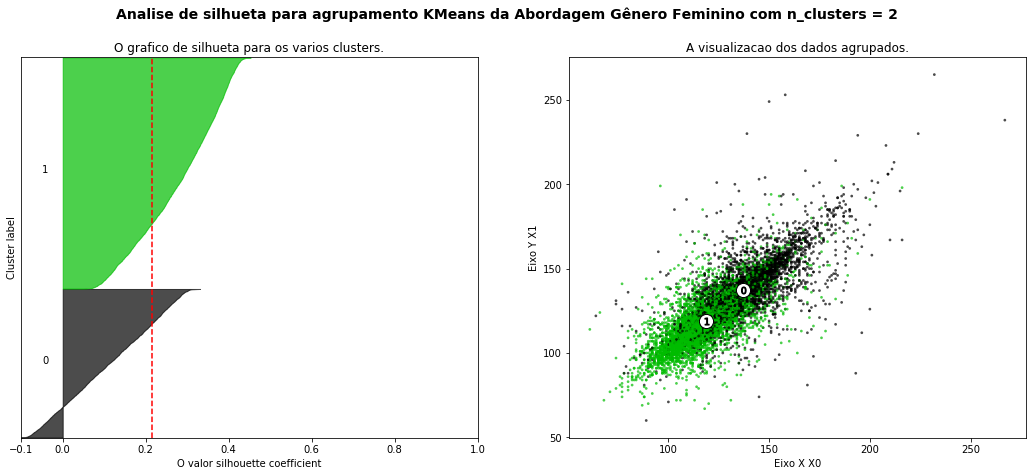

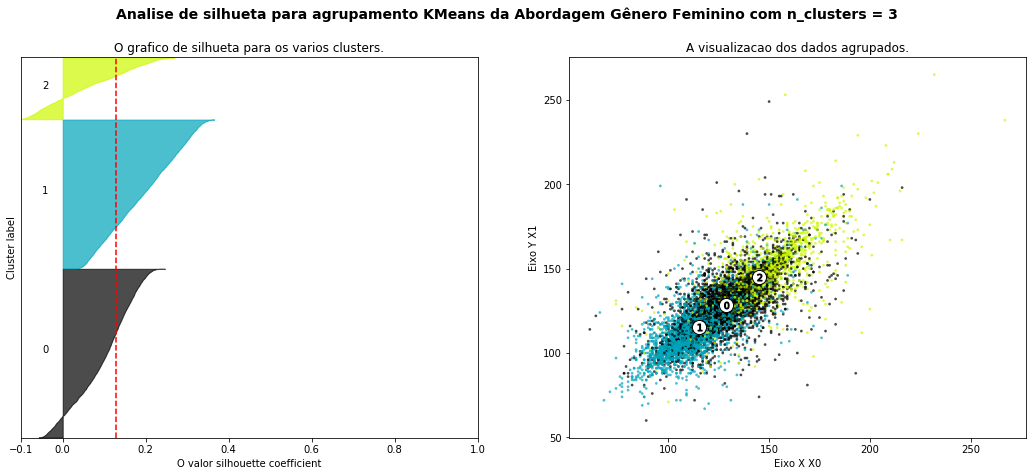

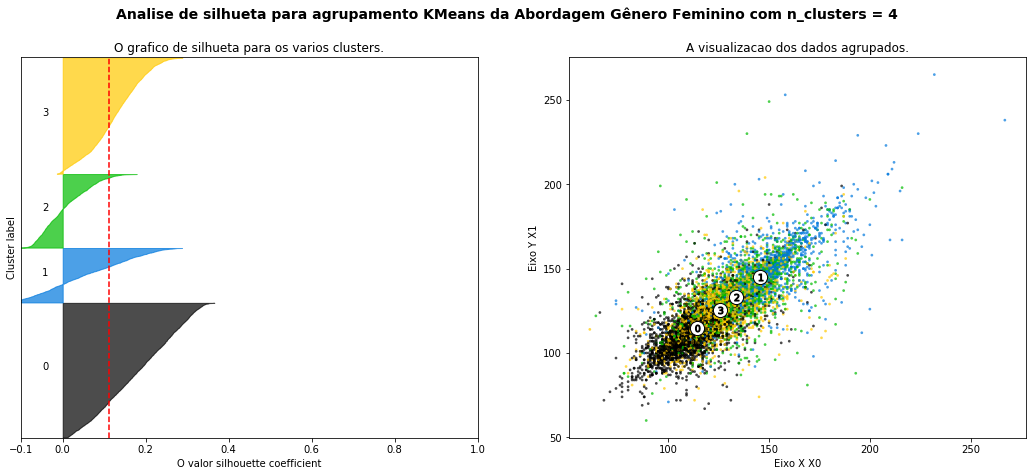

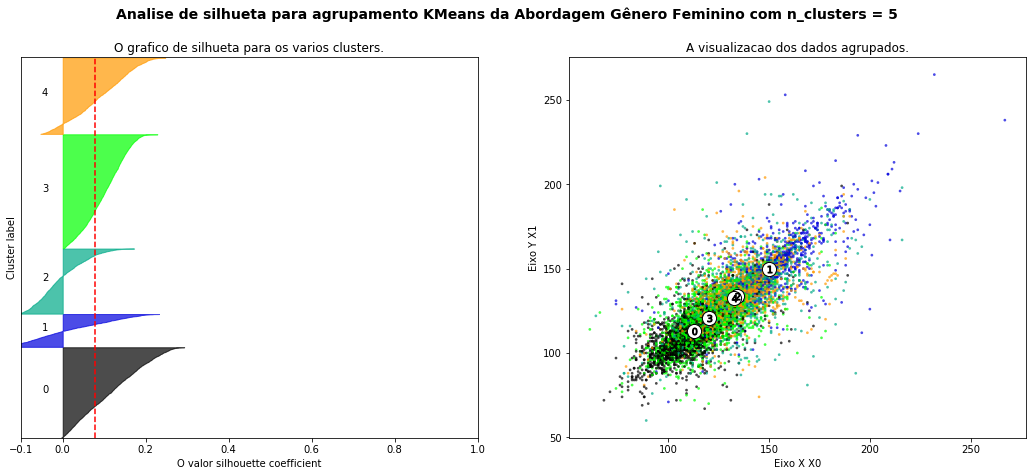

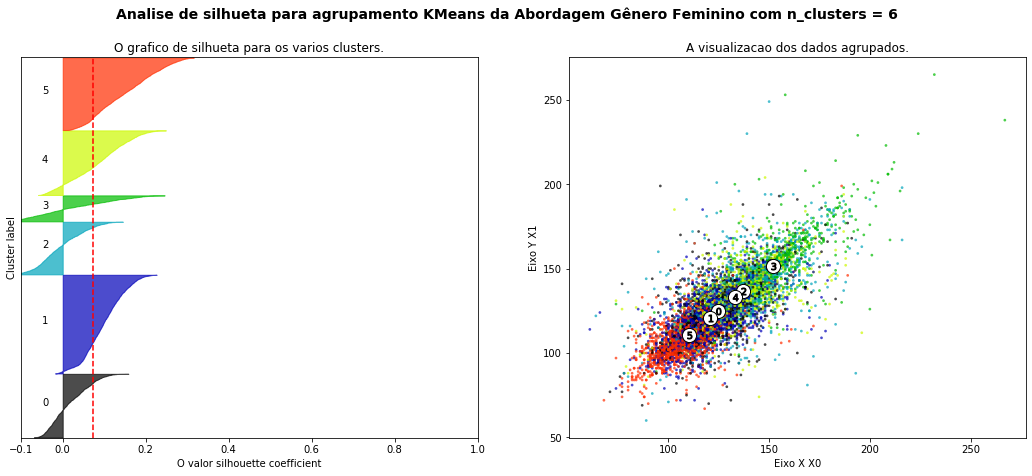

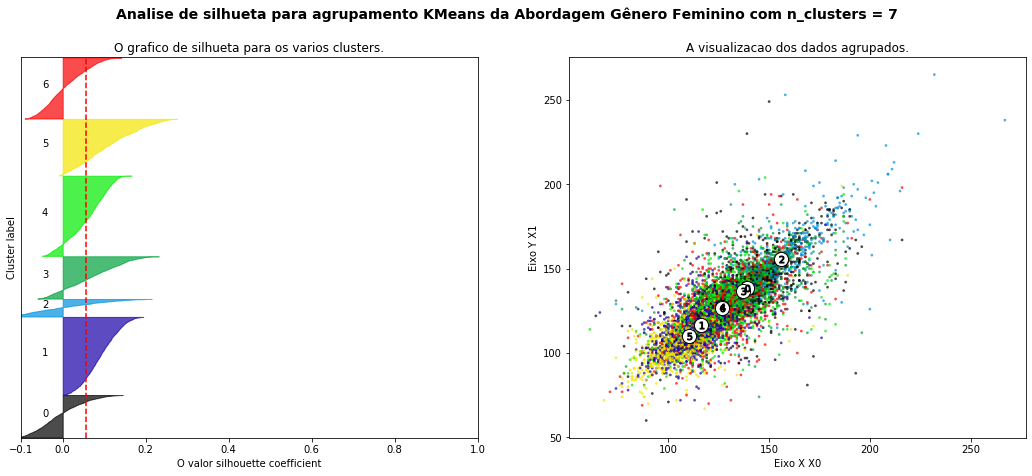

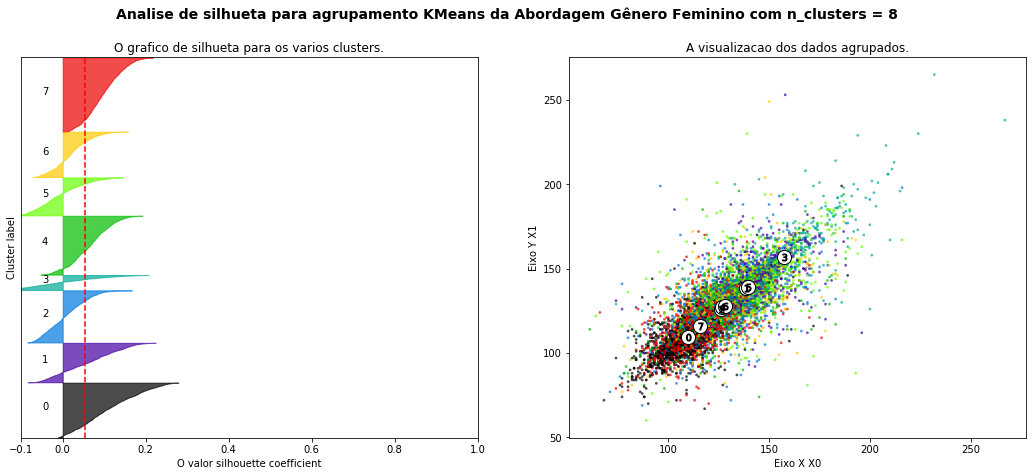

In [241]:
#Silhouette

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for n_clusters in range_n_clusters:    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # O 1st subplot é o grafico silhouette
    # O coeficiente silhouette  um range de -1, 1 but in this example all
    # Os exemplos vão ficar em [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # O (n_clusters + 1) * 10 é para inserir um espaço em branco entre a silhueta
    # Para gerar destaque
    ax1.set_ylim([0, len(dataset_fem_medidas_array) + (n_clusters + 1) * 10])
    # Inicialize o clusterer com o valor n_clusters e um valor aleatorio
    # seed 10.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(dataset_fem_medidas_array)
# O silhouette_score fornece o valor médio para todas as amostras.
    # Isso dá uma perspectiva sobre a densidade e separação das formas
    # clusters
    #  Cálculo de toda a matriz que entra no cálculo do Silhouette
    silhouette_avg = silhouette_score(dataset_fem_medidas_array, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette medio e :", silhouette_avg)
    # Calcule as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(dataset_fem_medidas_array, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregue as pontuações de silhueta para amostras pertencentes a
        # cluster i, e classifica-los
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Rotule os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcule o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  #10 para as 0 amostras
    ax1.set_title("O grafico de silhueta para os varios clusters.")
    ax1.set_xlabel("O valor silhouette coefficient")
    ax1.set_ylabel("Cluster label")
    # A linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Limpar os yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    # 2º gráfico mostrando os clusters reais formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dataset_fem_medidas_array[:, 0], dataset_fem_medidas_array[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    # Labeling dos clusters
    centers = clusterer.cluster_centers_
    # Desenhe círculos brancos nos centros do cluster
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("A visualizacao dos dados agrupados.")
    ax2.set_xlabel("Eixo X X0")
    ax2.set_ylabel("Eixo Y X1")
    plt.suptitle(("Analise de silhueta para agrupamento KMeans da Abordagem Gênero Feminino "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    fig = plt.gcf()
    fig.savefig( DIR_KMEANS / 'graficos' / f'metodosilhouette_medidas_fem_{n_clusters}.svg', format="svg")
    
plt.show()

#fig.savefig('diast_sist_kmeans.png', format='png')

### Não existe um valor de k clusters que não esteja se intersectando¶

In [242]:
# Dataset com grupos e medidas
# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

#
dataset_fem_apos_kmeans = dataset_fem.loc[:,'numero_identificacao':'data_exame']

dataset_fem_apos_kmeans['grupo'] = grupos_fem

dataset_fem_apos_kmeans['grupo'] = dataset_fem_apos_kmeans['grupo'] + 1

dataset_fem_apos_kmeans = pd.concat([dataset_fem_apos_kmeans,
                                         dataset_fem.loc[:,'sist 9:00':]],axis=1)

dataset_fem_apos_kmeans = dataset_fem_apos_kmeans.replace(genero_M_F)

# Salva dataset com dados completos após o K-Means com abordagem 1 (medidas)
dataset_fem_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')

dataset_fem_apos_kmeans

numero_identificacao data_nascimento genero  idade  peso altura   IMC  \
3                         7      1978-01-26      F   40.0  65.0   1,64  24.2   
9                        13      1963-06-23      F   55.0  60.0    158  24.0   
10                       14      1932-05-28      F   86.0  59.0    149  26.6   
11                       15      1933-02-16      F   85.0  68.0    151  29.8   
13                       18      1953-04-18      F   65.0  72.0    172  24.3   
...                     ...             ...    ...    ...   ...    ...   ...   
19141                 21779      1947-04-19      F   73.0  71.0    159  28.1   
19142                 21781      1947-04-18      F   73.0  92.0    168  32.6   
19143                 21782      1979-05-23      F   41.0  56.0   1,58  22.4   
19147                 21788      1985-03-15      F   35.0  93.0    167  33.3   
19148                 21792      1952-04-21      F   68.0  64.0    160  25.0   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
3      2018-12-26 08:19:06      1      140.0  ...                       80.0   
9      2018-12-26 10:04:36      5      131.0  ...                       70.0   
10     2018-12-26 10:06:10      6      107.0  ...                       66.0   
11     2018-12-26 10:08:12      1      166.0  ...                       74.0   
13     2018-12-26 10:15:40      4      142.0  ...                       87.0   
...                    ...    ...        ...  ...                        ...   
19141  2020-09-10 15:13:35      7      137.0  ...                       68.0   
19142  2020-09-10 15:18:46      3      153.0  ...                       93.0   
19143  2020-09-10 15:31:01      2      121.0  ...                       83.0   
19147  2020-09-10 16:44:53      6      107.0  ...                       62.0   
19148  2020-09-10 17:25:50      2       94.0  ...                       68.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
3                   10679.5                 6420.5          3642.0   
9                    9767.5                 6112.0          3093.0   
10                   8810.5                 5280.5          2900.5   
11                  11307.5                 6435.5          3922.0   
13                  11003.5                 6952.5          3237.0   
...                     ...                    ...             ...   
19141                9369.5                 5393.5          3321.0   
19142               11726.0                 7390.0          3668.0   
19143                9108.0                 6613.5          2069.5   
19147                9245.0                 4935.5          3556.0   
19148                8989.5                 5660.0          2815.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
3                 602.5                16.13                 10.34   
9                 506.0                19.92                 15.62   
10                574.0                 8.15                  7.86   
11                868.5                16.56                  9.47   
13                735.5                18.78                 14.23   
...                 ...                  ...                   ...   
19141             604.0                13.71                 10.41   
19142             618.0                20.56                 12.37   
19143             391.5                14.49                 12.30   
19147             713.5                14.36                  8.29   
19148             460.0                14.14                  9.38   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
3                   21                 9             1.106757  
9                   19                22             1.184304  
10                  11                16             1.115168  
11                  26                 4             0.999183  
13                  37                28             1.024866  
...                

### Abordagem 9: Random Forest

In [243]:
from sklearn.ensemble import RandomForestClassifier

In [244]:
#parametro simples do modelo
random_forest_fem = RandomForestClassifier(n_estimators=50)

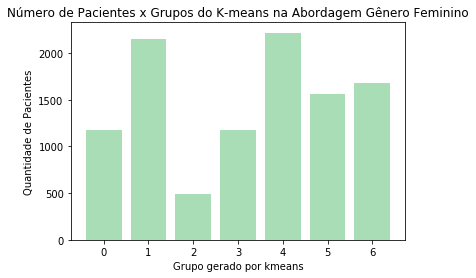

In [245]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_fem)

for i in range(0,num_otimo_clusters_fem):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Gênero Feminino')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem9_pacientes_feminino_por_grupos.svg',format="svg")
plt.show()


In [246]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(dataset_fem_medidas_array, grupos_fem, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(dataset_fem_medidas_array, grupos_fem, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [247]:
#treino
random_forest_fem.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 9: VALIDAÇÃO

In [248]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_fem.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

In [249]:
print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [250]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2    3     4    5     6
0  721     0    0    0     0    0     0
1    0  1274    0    0     0    0     0
2    0     0  296    0     0    0     0
3    0     0    0  688     0    0     0
4    0     0    0    0  1331    0     0
5    0     0    0    0     0  912     0
6    0     0    0    0     0    0  1045

#### Abordagem 9: TESTE

In [251]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_fem.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9207754906653901 - Recall: 0.9120563179171592 - F1 Score: 0.9212149515161007


In [252]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0    1    2    3    4    5    6
0  388    0    2    8   34    0   21
1    0  817    0    0   28   15   17
2    7    0  170   13    0    0    0
3    4    0    2  436   41    0    0
4    4   22    0    8  851    0    2
5    0   20    0    0    0  619   11
6    8   43    0    0   12    9  566

In [253]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_fem_apos_kmeans, grupos_fem, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_fem_apos_kmeans, grupos_fem, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 9: Importância das Features Random Forest

In [254]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sist_diast,'importance':np.round(random_forest_fem.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)
importancia

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_medidas_fem.csv', 
             sep=';',index=False,encoding='UTF-8')

# Abordagem 10: Sistólicas separadas

In [255]:
#selecionando variaveis de medidas : sist 9:00 a diast 8:45 em listas separadas

ls_sistolica = list(dataset_medidas.loc[:,'sist 9:00':'sist 8:45'].columns)
sistolica_sem_id = dataset_medidas.loc[:,'sist 9:00':'sist 8:45']


## Abordagem 10: Número de Clusters gerado pelo k-Means

In [256]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_sistolica = calculate_wcss(sistolica_sem_id)
num_otimo_clusters_sistolica = optimal_number_of_clusters(sum_of_squares_sistolica)
num_otimo_clusters_sistolica

Wall time: 30.8 s


6

In [257]:
#convertendo os dados para a clusterização

sistolica_array = np.array(sistolica_sem_id)

In [258]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_sistolica = KMeans(n_clusters=num_otimo_clusters_sistolica, random_state=42).fit(sistolica_array)

In [259]:
#listar os grupos 

grupos_sistolica = kmeans_sistolica.fit_predict(sistolica_array)

In [260]:
#incluir grupos nos dados de sist e diast

sistolica_sem_id['grupo'] = grupos_sistolica
sistolica_sem_id['grupo'] = sistolica_sem_id['grupo'] + 1
sistolica_sem_id

sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  sist 10:15  \
0          105.0      108.0      116.0      104.0       106.0        98.0   
1          103.0      114.0       82.0      104.0        98.0       106.0   
2          147.0      148.0      156.0      140.0       130.0       132.0   
3          140.0      139.0      142.0      137.0       135.0       177.0   
4          113.0      110.0      101.0      108.0       111.0       111.0   
...          ...        ...        ...        ...         ...         ...   
19145      163.0      198.0      172.0      148.0       161.0       156.0   
19146      114.0      120.0      164.0      116.0       119.0       126.0   
19147      107.0      110.0      103.0      105.0       108.0       111.0   
19148       94.0      107.0      112.0      124.0       120.0        94.0   
19149      111.0      104.0      103.0      101.0        97.0       110.0   

       sist 10:30  sist 10:45  sist 11:00  sist 11:15  ...  sist 6:45  \
0           102.0       107.0       111.0       116.0  ...       94.0   
1           108.0       107.0       109.0       100.0  ...      111.0   
2           121.0       113.0       149.0       128.0  ...      136.0   
3           148.0       152.0       135.0       136.0  ...      104.0   
4           114.0       115.0       113.0       112.0  ...      116.0   
...           ...         ...         ...         ...  ...        ...   
19145       156.0       138.0       107.0        76.0  ...      162.0   
19146       123.0       122.0       122.0       159.0  ...      136.0   
19147       114.0       144.0       128.0       104.0  ...       96.0   
19148       102.0       113.0       104.0        96.0  ...      124.0   
19149       111.0       116.0       104.0       121.0  ...      105.0   

       sist 7:00  sist 7:15  sist 7:30  sist 7:45  sist 8:00  sist 8:15  \
0           92.0       91.0       89.0       88.0      115.0      114.0   
1          113.0      113.0      113.0      113.0      114.0      111.0   
2          136.0      135.0      134.0      133.0      133.0      137.0   
3          111.0      128.0      145.0      147.0      150.0      153.0   
4          124.0      132.0       93.0      118.0      114.0      110.0   
...          ...        ...        ...        ...        ...        ...   
19145      166.0      166.0      166.0      166.0      167.0      162.0   
19146      116.0      113.0      113.0      146.0      146.0      147.0   
19147       95.0      100.0      110.0      116.0      113.0      124.0   
19148      133.0      121.0      114.0      108.0      115.0      105.0   
19149      108.0      111.0      105.0       90.0       98.0       98.0   

       sist 8:30  sist 8:45  grupo  
0          111.0      102.0      4  
1          102.0      116.0      6  
2          169.0      143.0      1  
3          153.0      185.0      1  
4          106.0      116.0      4  
...          ...        ...    ...  
19145      156.0      148.0      5  
19146      145.0      142.0      1  
19147      114.0      113.0      4  
19148      113.0      101.0      6  
19149      103.0      113.0      4  

[19150 rows x 83 columns]

In [261]:

# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

dataset_sistolica_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'data_exame']

dataset_sistolica_apos_kmeans = pd.concat([dataset_sistolica_apos_kmeans, sistolica_sem_id['grupo'],
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_sistolica_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 10 (medidas)
#dataset_sistolica_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_sistolica.csv', 
#             sep=';',index=False,encoding='UTF-8')


numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19145                 21786      1972-11-25       1   47.0   75.0    165   
19146                 21787      1970-10-19       1   49.0   90.0    183   
19147                 21788      1985-03-15       0   35.0   93.0    167   
19148                 21792      1952-04-21       0   68.0   64.0    160   
19149                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 9:00  ...  \
0      33.2  2018-09-10 12:25:23      4      105.0  ...   
1      29.4  2018-12-26 07:39:41      6      103.0  ...   
2      25.8  2018-12-26 08:06:19      1      147.0  ...   
3      24.2  2018-12-26 08:19:06      1      140.0  ...   
4      40.6  2018-12-26 08:26:59      4      113.0  ...   
...     ...                  ...    ...        ...  ...   
19145  27.5  2020-09-10 16:03:08      5      163.0  ...   
19146  26.9  2020-09-10 16:21:02      1      114.0  ...   
19147  33.3  2020-09-10 16:44:53      4      107.0  ...   
19148  25.0  2020-09-10 17:25:50      6       94.0  ...   
19149  30.9  2020-09-10 17:42:01      4      111.0  ...   

       Mediana Sistolica em 24h  Mediana Diastolica em 24h  \
0                         118.5                       59.0   
1                         106.0                       62.0   
2                         133.0                       79.0   
3                         131.0                       80.0   
4                         115.0                       78.0   
...                         ...                        ...   
19145                     152.0                      116.0   
19146                     136.0                       85.0   
19147                     112.0                       62.0   
19148                     109.5                       68.0   
19149                     121.0                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
3                   10679.5                 6420.5          3642.0   
4                    9141.5                 6118.0          2405.0   
...                     ...                    ...             ...   
19145               12224.5                 9265.0          2439.0   
19146               10970.0                 6819.0          3319.0   
19147                9245.0                 4935.5          3556.0   
19148                8989.5                 5660.0          2815.5   
19149                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
3                 602.5                16.13                 10.34   
4                 566.0                12.27                 12.79   
...                 ...                  ...                   ...   
19145             474.5                18.66                 14.80   
19146             738.0                17.22                 13.67   
19147             713.5                14.36                  8.29   
19148             460.0                14.14                  9.38   
19149             612.0      

### Abordagem 10: Random Forest

In [262]:
from sklearn.ensemble import RandomForestClassifier

In [263]:
#parametro simples do modelo
random_forest_sistolica = RandomForestClassifier(n_estimators=50)

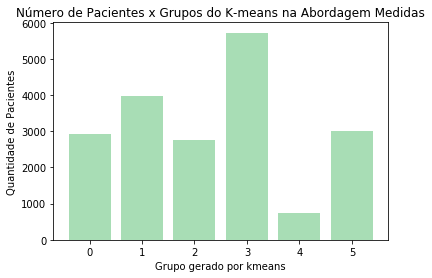

In [264]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_sistolica)

for i in range(0,num_otimo_clusters_sistolica):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem_sistolica_pacientes_por_grupos.svg',format="svg")
plt.show()


In [265]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(sistolica_array, grupos_sistolica, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(sistolica_array, grupos_sistolica, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [266]:
#treino
random_forest_sistolica.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 10: VALIDAÇÃO

In [267]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_sistolica.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [268]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2     3    4     5
0  1780     0     0     0    0     0
1     0  2389     0     0    0     0
2     0     0  1637     0    0     0
3     0     0     0  3454    0     0
4     0     0     0     0  446     0
5     0     0     0     0    0  1784

#### Abordagem 10: TESTE

In [269]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_sistolica.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9224543080939948 - Recall: 0.9021425209039383 - F1 Score: 0.918670861044936


In [270]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1    2     3    4     5
0  1080    53   17     0    0     0
1    23  1471   24    71    0     0
2    32    65  955    77    0     0
3     0    31   21  2209    0     8
4    52     0    0     0  248     0
5     0     0    1   119    0  1103

In [271]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_sistolica_apos_kmeans, grupos_sistolica, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_sistolica_apos_kmeans, grupos_sistolica, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 10: Importância das Features Random Forest

In [272]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_sistolica,'importance':np.round(random_forest_sistolica.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_sistolica.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia


features  importance
73   sist 6:45       0.031
71   sist 6:15       0.030
23  sist 14:45       0.020
35  sist 17:45       0.019
22  sist 14:30       0.018
..         ...         ...
28  sist 16:00       0.009
26  sist 15:30       0.009
19  sist 13:45       0.009
4   sist 10:00       0.009
81   sist 8:45       0.009

[82 rows x 2 columns]

# Abordagem 11: Diastólicas

In [273]:
ls_diastolica = list(dataset_medidas.loc[:,'diast 9:00':'diast 8:45'].columns)
diastolica_sem_id = dataset_medidas.loc[:,'diast 9:00':'diast 8:45']

## Abordagem 11: Número de Clusters gerado pelo k-Means

In [274]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_diastolica = calculate_wcss(diastolica_sem_id)
num_otimo_clusters_diastolica = optimal_number_of_clusters(sum_of_squares_diastolica)
num_otimo_clusters_diastolica

Wall time: 28.2 s


6

In [275]:
#convertendo os dados para a clusterização

diastolica_array = np.array(diastolica_sem_id)

In [276]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_diastolica = KMeans(n_clusters=num_otimo_clusters_diastolica, random_state=42).fit(diastolica_array)

In [277]:
#listar os grupos 

grupos_diastolica = kmeans_diastolica.fit_predict(diastolica_array)

In [278]:
#incluir grupos nos dados de sist e diast

diastolica_sem_id['grupo'] = grupos_diastolica
diastolica_sem_id['grupo'] = diastolica_sem_id['grupo'] + 1
diastolica_sem_id

diast 9:00  diast 9:15  diast 9:30  diast 9:45  diast 10:00  \
0            47.0        47.0        53.0        48.0         55.0   
1            60.0        54.0        59.0        57.0         62.0   
2            92.0        95.0        78.0        82.0         75.0   
3            81.0        90.0        90.0        89.0         83.0   
4            76.0        80.0        78.0        79.0         68.0   
...           ...         ...         ...         ...          ...   
19145       121.0       112.0       134.0       124.0        130.0   
19146        87.0        86.0        79.0        79.0         76.0   
19147        57.0        58.0        57.0        58.0         60.0   
19148        63.0        68.0        72.0        68.0         73.0   
19149        73.0        64.0        55.0        64.0         60.0   

       diast 10:15  diast 10:30  diast 10:45  diast 11:00  diast 11:15  ...  \
0             49.0         50.0         50.0         54.0         58.0  ...   
1             64.0         60.0         52.0         61.0         61.0  ...   
2             69.0         56.0         57.0         54.0         54.0  ...   
3             93.0         85.0         88.0         77.0         84.0  ...   
4             75.0         80.0         81.0         76.0         78.0  ...   
...            ...          ...          ...          ...          ...  ...   
19145        111.0        117.0        121.0         90.0         60.0  ...   
19146         78.0         76.0         80.0         83.0         84.0  ...   
19147         61.0         63.0         66.0         63.0         65.0  ...   
19148         60.0         60.0         71.0         74.0         69.0  ...   
19149         58.0         79.0         78.0         75.0         98.0  ...   

       diast 6:45  diast 7:00  diast 7:15  diast 7:30  diast 7:45  diast 8:00  \
0            46.0        51.0        56.0        61.0        67.0        61.0   
1            74.0        74.0        70.0        67.0        63.0        60.0   
2            86.0        93.0        91.0        89.0        87.0        86.0   
3            56.0        62.0        83.0       104.0        99.0        94.0   
4            73.0        83.0        93.0        68.0        91.0        87.0   
...           ...         ...         ...         ...         ...         ...   
19145       114.0       126.0       125.0       124.0       123.0       123.0   
19146        73.0        59.0        74.0        68.0        86.0        96.0   
19147        50.0        50.0        53.0        52.0        62.0        68.0   
19148        63.0        64.0        76.0        72.0        69.0        75.0   
19149        68.0        69.0        71.0        73.0        56.0        57.0   

       diast 8:15  diast 8:30  diast 8:45  grupo  
0            69.0        62.0        51.0      6  
1            74.0        70.0        67.0      6  
2            87.0        82.0        82.0      3  
3            89.0        90.0        72.0      3  
4            84.0        81.0        72.0      2  
...           ...         ...         ...    ...  
19145       121.0       119.0       123.0      4  
19146       107.0       106.0        93.0      5  
19147        61.0        64.0        60.0      6  
19148        74.0        69.0        67.0      1  
19149        65.0        68.0        82.0      2  

[19150 rows x 83 columns]

In [279]:

# nume id, data exame, idade, peso, altura, medidas, 22 estatisticas, 11 doenças em cada grupo 

dataset_diastolica_apos_kmeans = dataset_apos_tratamento.loc[:,'numero_identificacao':'data_exame']

dataset_diastolica_apos_kmeans = pd.concat([dataset_diastolica_apos_kmeans, diastolica_sem_id['grupo'],
                                         dataset_apos_tratamento.loc[:,'sist 9:00':'Picos Diastolica']],axis=1)
dataset_diastolica_apos_kmeans

# Salva dataset com dados completos após o K-Means com abordagem 10 (medidas)
#dataset_diastolica_apos_kmeans.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'mapa_apos_kmeans_diastolica.csv', 
#             sep=';',index=False,encoding='UTF-8')


numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19145                 21786      1972-11-25       1   47.0   75.0    165   
19146                 21787      1970-10-19       1   49.0   90.0    183   
19147                 21788      1985-03-15       0   35.0   93.0    167   
19148                 21792      1952-04-21       0   68.0   64.0    160   
19149                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 9:00  ...  \
0      33.2  2018-09-10 12:25:23      6      105.0  ...   
1      29.4  2018-12-26 07:39:41      6      103.0  ...   
2      25.8  2018-12-26 08:06:19      3      147.0  ...   
3      24.2  2018-12-26 08:19:06      3      140.0  ...   
4      40.6  2018-12-26 08:26:59      2      113.0  ...   
...     ...                  ...    ...        ...  ...   
19145  27.5  2020-09-10 16:03:08      4      163.0  ...   
19146  26.9  2020-09-10 16:21:02      5      114.0  ...   
19147  33.3  2020-09-10 16:44:53      6      107.0  ...   
19148  25.0  2020-09-10 17:25:50      1       94.0  ...   
19149  30.9  2020-09-10 17:42:01      2      111.0  ...   

       Mediana Sistolica em 24h  Mediana Diastolica em 24h  \
0                         118.5                       59.0   
1                         106.0                       62.0   
2                         133.0                       79.0   
3                         131.0                       80.0   
4                         115.0                       78.0   
...                         ...                        ...   
19145                     152.0                      116.0   
19146                     136.0                       85.0   
19147                     112.0                       62.0   
19148                     109.5                       68.0   
19149                     121.0                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
3                   10679.5                 6420.5          3642.0   
4                    9141.5                 6118.0          2405.0   
...                     ...                    ...             ...   
19145               12224.5                 9265.0          2439.0   
19146               10970.0                 6819.0          3319.0   
19147                9245.0                 4935.5          3556.0   
19148                8989.5                 5660.0          2815.5   
19149                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
3                 602.5                16.13                 10.34   
4                 566.0                12.27                 12.79   
...                 ...                  ...                   ...   
19145             474.5                18.66                 14.80   
19146             738.0                17.22                 13.67   
19147             713.5                14.36                  8.29   
19148             460.0                14.14                  9.38   
19149             612.0      

### Abordagem 11: Random Forest

In [280]:
from sklearn.ensemble import RandomForestClassifier

In [281]:
#parametro simples do modelo
random_forest_diastolica = RandomForestClassifier(n_estimators=50)

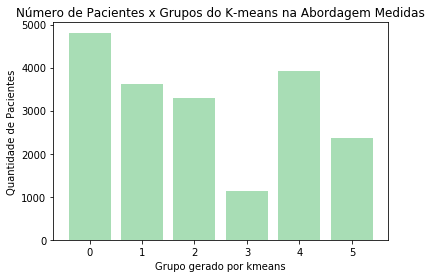

In [282]:
# Plota Gráfico da qtd pacientes em cada Grupos

classes = []
qtds = []

contagem = Counter(grupos_diastolica)

for i in range(0,num_otimo_clusters_diastolica):
    classes.append(i)
    qtds.append(contagem[i])

plt.bar(classes,qtds,color="#a8ddb5")
plt.xticks(classes)
plt.ylabel('Quantidade de Pacientes')
plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
plt.title('Número de Pacientes x Grupos do K-means na Abordagem Medidas')
fig = plt.gcf()
fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_Abordagem_diastolica_pacientes_por_grupos.svg',format="svg")
plt.show()


In [283]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

#separar train(75%) - 14.485, test (10%) - 7.726  and validation (15%) - 11.588
#  O parâmetro random_state=42 garante o rastreio do numero de identificação
x_train, x_test, y_train, y_test = train_test_split(diastolica_array, grupos_diastolica, test_size=1 - train_ratio,random_state=42)
x_val, x_test, y_val, y_test = train_test_split(diastolica_array, grupos_diastolica, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)

In [284]:
#treino
random_forest_diastolica.fit(x_train, y_train)

RandomForestClassifier(n_estimators=50)

#### Abordagem 11: VALIDAÇÃO

In [285]:
#calcular acuracia, recall e f1
y_prev_val = random_forest_diastolica.predict(x_val)

accuracy = accuracy_score(y_val, y_prev_val)
recall = recall_score(y_val, y_prev_val,average='macro')
f1 = f1_score(y_val, y_prev_val,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 1.0 - Recall: 1.0 - F1 Score: 1.0


In [286]:
#Matriz de Confusão
mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2    3     4     5
0  2873     0     0    0     0     0
1     0  2153     0    0     0     0
2     0     0  1960    0     0     0
3     0     0     0  714     0     0
4     0     0     0    0  2373     0
5     0     0     0    0     0  1417

#### Abordagem 11: TESTE

In [287]:
#calcular acuracia, recall e f1
y_prev_test = random_forest_diastolica.predict(x_test)

accuracy = accuracy_score(y_test, y_prev_test)
recall = recall_score(y_test, y_prev_test,average='macro')
f1 = f1_score(y_test, y_prev_test,average='macro')

print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))

Accuracy: 0.9199738903394256 - Recall: 0.9104881829003767 - F1 Score: 0.9214978552711495


In [288]:
#Matriz da Confusão
mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
pd.DataFrame(mat,index = classes, columns = classes)

0     1     2    3     4    5
0  1864    19    35    0     0   19
1    50  1298    46    0    65    0
2    92    58  1156    0    33    0
3     0     0     0  365    53    0
4     0    33    25    2  1492    0
5    83     0     0    0     0  872

In [289]:
#salvar dataframe numero_paciente, grupo_real, grupo, previsto validação
x_train_, x_test_, y_train_, y_test_ = train_test_split(dataset_diastolica_apos_kmeans, grupos_diastolica, test_size=1 - train_ratio, random_state=42)
x_val_, x_test_, y_val_, y_test_ = train_test_split(dataset_diastolica_apos_kmeans, grupos_diastolica, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

#validacao
pacientes_validacao_diast_sisto = x_val_[['numero_identificacao']]
pacientes_validacao_diast_sisto['Grupo_Real'] = y_val_
pacientes_validacao_diast_sisto['Grupo_Previsto'] = y_prev_val

pacientes_validacao_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_validacao_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')

#teste
pacientes_teste_diast_sisto = x_test_[['numero_identificacao']]
pacientes_teste_diast_sisto['Grupo_Real'] = y_test_
pacientes_teste_diast_sisto['Grupo_Previsto'] = y_prev_test

pacientes_teste_diast_sisto.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'pacientes_teste_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')


c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

#### Abordagem 11: Importância das Features Random Forest

In [290]:
#calculo da importancia de cada variavel para idenficar os grupos com 3 casas decimais
importancia = pd.DataFrame({'features':ls_diastolica,'importance':np.round(random_forest_diastolica.feature_importances_,3)})
importancia = importancia.sort_values('importance',ascending=False)

importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_diastolica.csv', 
             sep=';',index=False,encoding='UTF-8')

importancia


features  importance
73   diast 6:45       0.032
71   diast 6:15       0.027
36  diast 18:00       0.020
35  diast 17:45       0.019
8   diast 11:00       0.018
..          ...         ...
53  diast 22:15       0.009
81   diast 8:45       0.009
58   diast 0:00       0.008
59   diast 0:30       0.007
57  diast 23:30       0.007

[82 rows x 2 columns]

# Abordagem 12 Medidas Mais Importantes

In [291]:
ls_importantes = importancia_medidas['features'].iloc[:7].values
ls_importantes

array(['sist 6:15', 'sist 6:45', 'sist 7:15', 'sist 7:30', 'sist 7:00',
       'sist 6:30', 'sist 6:00'], dtype=object)

In [292]:
medidas_importantes = dataset_apos_tratamento[ls_importantes]
medidas_importantes

sist 6:15  sist 6:45  sist 7:15  sist 7:30  sist 7:00  sist 6:30  \
0          104.0       94.0       91.0       89.0       92.0       96.0   
1          107.0      111.0      113.0      113.0      113.0      109.0   
2          122.0      136.0      135.0      134.0      136.0      135.0   
3          116.0      104.0      128.0      145.0      111.0       96.0   
4          102.0      116.0      132.0       93.0      124.0      109.0   
...          ...        ...        ...        ...        ...        ...   
19145      152.0      162.0      166.0      166.0      166.0      157.0   
19146      146.0      136.0      113.0      113.0      116.0      157.0   
19147       94.0       96.0      100.0      110.0       95.0       98.0   
19148      107.0      124.0      121.0      114.0      133.0      116.0   
19149      102.0      105.0      111.0      105.0      108.0      103.0   

       sist 6:00  
0          113.0  
1          105.0  
2          109.0  
3          135.0  
4           94.0  
...          ...  
19145      147.0  
19146      135.0  
19147       89.0  
19148       99.0  
19149      100.0  

[19150 rows x 7 columns]

In [293]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)
%time sum_of_squares_medidas_importantes = calculate_wcss(medidas_importantes)
num_otimo_clusters_medidas_importantes = optimal_number_of_clusters(sum_of_squares_medidas_importantes)
num_otimo_clusters_medidas_importantes

Wall time: 16 s


6

In [294]:
#convertendo os dados para a clusterização

dados_medidas_importantes_array = np.array(medidas_importantes)

## K-means Abordagem: Medidas Mais Importantes

In [295]:
#habilitando o kmeans com "num_otimo_clusters" grupos (foi calculado na etapa anterior)

kmeans_medidas_importantes = KMeans(n_clusters=num_otimo_clusters_medidas_importantes, random_state=42).fit(dados_medidas_importantes_array)

In [296]:
#listar os grupos 

%time grupos_medidas_importantes = kmeans_medidas_importantes.fit_predict(dados_medidas_importantes_array)
grupos_medidas_importantes

Wall time: 441 ms


array([2, 3, 1, ..., 2, 3, 2])

In [297]:
#medidas_importantes.drop(['grupo'],axis=1,inplace=True)

In [298]:
medidas_importantes['grupo'] = grupos_medidas_importantes + 1
medidas_importantes

c:\users\marta\anaconda3\envs\emoti\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


sist 6:15  sist 6:45  sist 7:15  sist 7:30  sist 7:00  sist 6:30  \
0          104.0       94.0       91.0       89.0       92.0       96.0   
1          107.0      111.0      113.0      113.0      113.0      109.0   
2          122.0      136.0      135.0      134.0      136.0      135.0   
3          116.0      104.0      128.0      145.0      111.0       96.0   
4          102.0      116.0      132.0       93.0      124.0      109.0   
...          ...        ...        ...        ...        ...        ...   
19145      152.0      162.0      166.0      166.0      166.0      157.0   
19146      146.0      136.0      113.0      113.0      116.0      157.0   
19147       94.0       96.0      100.0      110.0       95.0       98.0   
19148      107.0      124.0      121.0      114.0      133.0      116.0   
19149      102.0      105.0      111.0      105.0      108.0      103.0   

       sist 6:00  grupo  
0          113.0      3  
1          105.0      4  
2          109.0      2  
3          135.0      2  
4           94.0      4  
...          ...    ...  
19145      147.0      6  
19146      135.0      5  
19147       89.0      3  
19148       99.0      4  
19149      100.0      3  

[19150 rows x 8 columns]

In [299]:
df_medidas_importantes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],medidas_importantes.loc[:,'grupo'],dataset_apos_tratamento.loc[:,'sist 9:00':]], axis=1)
df_medidas_importantes


numero_identificacao data_nascimento  genero  idade   peso altura  \
0                         4      1923-10-05       1   94.0   85.0    160   
1                         5      1948-10-07       1   70.0   80.0    165   
2                         6      1999-03-23       1   19.0  100.0    197   
3                         7      1978-01-26       0   40.0   65.0   1,64   
4                         8      1990-03-07       1   28.0  120.0    172   
...                     ...             ...     ...    ...    ...    ...   
19145                 21786      1972-11-25       1   47.0   75.0    165   
19146                 21787      1970-10-19       1   49.0   90.0    183   
19147                 21788      1985-03-15       0   35.0   93.0    167   
19148                 21792      1952-04-21       0   68.0   64.0    160   
19149                 21793      1971-01-14       1   49.0   99.0    179   

        IMC           data_exame  grupo  sist 9:00  ...  \
0      33.2  2018-09-10 12:25:23      3      105.0  ...   
1      29.4  2018-12-26 07:39:41      4      103.0  ...   
2      25.8  2018-12-26 08:06:19      2      147.0  ...   
3      24.2  2018-12-26 08:19:06      2      140.0  ...   
4      40.6  2018-12-26 08:26:59      4      113.0  ...   
...     ...                  ...    ...        ...  ...   
19145  27.5  2020-09-10 16:03:08      6      163.0  ...   
19146  26.9  2020-09-10 16:21:02      5      114.0  ...   
19147  33.3  2020-09-10 16:44:53      3      107.0  ...   
19148  25.0  2020-09-10 17:25:50      4       94.0  ...   
19149  30.9  2020-09-10 17:42:01      3      111.0  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
0                           59.0                9545.5                 4902.0   
1                           62.0                8586.5                 5034.5   
2                           79.0               10674.0                 6154.0   
3                           80.0               10679.5                 6420.5   
4                           78.0                9141.5                 6118.0   
...                          ...                   ...                    ...   
19145                      116.0               12224.5                 9265.0   
19146                       85.0               10970.0                 6819.0   
19147                       62.0                9245.0                 4935.5   
19148                       68.0                8989.5                 5660.0   
19149                       86.0                9812.0                 6746.5   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
0              3748.0             841.5                16.52   
1              2915.0             606.0                 7.51   
2              3721.0             751.5                12.70   
3              3642.0             602.5                16.13   
4              2405.0             566.0                12.27   
...               ...               ...                  ...   
19145          2439.0             474.5                18.66   
19146          3319.0             738.0                17.22   
19147          3556.0             713.5                14.36   
19148          2815.5             460.0                14.14   
19149          2400.5             612.0                13.92   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
0                     11.36               11                34   
1                      6.65                9                23   
2                     13.01               19                19   
3                     10.34               21                 9   
4                     12.79               10                11   
...                     ...              ...               ...   
19145                 14.80               49                60   
19146                 13.67               32                27   
19147                  8.29               14     

# Abordagem 13: Apenas 2 categorias das covariáveis Gênero, Idade e IMC

In [300]:
dataset_simples = pd.DataFrame()
dataset_simples['numero_identificacao'] = dataset_apos_tratamento['numero_identificacao']
dataset_simples['genero'] = dataset_apos_tratamento['genero']
dataset_simples['idade'] = dataset_apos_tratamento['idade'].apply(faixas_etarias_classe_13)
dataset_simples['IMC'] = dataset_apos_tratamento['IMC'].apply(faixas_imc_classe_13)
dataset_simples = pd.concat([dataset_simples, dataset_apos_tratamento.loc[:,'sist 9:00':'diast 8:45']],axis=1)
for doenca in list(dataset_apos_tratamento.loc[:,'Hipotensao':'Whitecoat'].columns):
    dataset_simples[doenca] = dataset_apos_tratamento[doenca].apply(verdadeiro_falso)
dataset_simples

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      2    2      105.0      108.0   
1                         5       1      2    1      103.0      114.0   
2                         6       1      1    1      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    2      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19145                 21786       1      1    1      163.0      198.0   
19146                 21787       1      1    1      114.0      120.0   
19147                 21788       0      1    2      107.0      110.0   
19148                 21792       0      2    1       94.0      107.0   
19149                 21793       1      1    2      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Hipotensao  \
0          116.0      104.0       106.0        98.0  ...           1   
1           82.0      104.0        98.0       106.0  ...           1   
2          156.0      140.0       130.0       132.0  ...           1   
3          142.0      137.0       135.0       177.0  ...           1   
4          101.0      108.0       111.0       111.0  ...           1   
...          ...        ...         ...         ...  ...         ...   
19145      172.0      148.0       161.0       156.0  ...           1   
19146      164.0      116.0       119.0       126.0  ...           1   
19147      103.0      105.0       108.0       111.0  ...           1   
19148      112.0      124.0       120.0        94.0  ...           1   
19149      103.0      101.0        97.0       110.0  ...           1   

       Sistolica Isolada  Diastolica Isolada  Dipping  Non Dipping  \
0                      0                   0        0            0   
1                      0                   0        0            0   
2                      0                   0        0            1   
3                      0                   0        1            0   
4                      0                   0        1            0   
...                  ...                 ...      ...          ...   
19145                  0                   0        1            0   
19146                  0                   0        0            1   
19147                  0                   0        0            1   
19148                  0                   0        0            0   
19149                  0                   0        0            0   

       Extreme Dipping  Reverse Dipping  Morning Surge  Masked  Whitecoat  
0                    0                1              0       0          0  
1                    0                1              0       0          0  
2                    0                0              0       0          1  
3                    0                0              0       0          1  
4                    0                0              0       0          0  
...                ...              ...            ...     ...        ...  
19145                0                0              1       0          1  
19146                0                0              0       0          1  
19147                0                0              0       0          1  
19148                1                0              0       0          0  
19149                0                1              0       0          1  

[19150 rows x 178 columns]

In [301]:
#convertendo os dados para entrega ao Random - Classifcação

#ls_classes = list(dataset_por_classes.loc[:,'genero':].columns)

#genero_M_F1 = {"genero": {"M":1, "F":0}}
#dataset_por_classes = dataset_por_classes.replace(genero_M_F1)

ls_simples = list((dataset_simples.drop(list(dataset_simples.loc[:,'Hipotensao':].columns),axis=1)).drop('numero_identificacao',axis=1).columns)

array_simples = np.array(dataset_simples[ls_simples])

dataset_simples[ls_simples].head()

genero  idade  IMC  sist 9:00  sist 9:15  sist 9:30  sist 9:45  sist 10:00  \
0       1      2    2      105.0      108.0      116.0      104.0       106.0   
1       1      2    1      103.0      114.0       82.0      104.0        98.0   
2       1      1    1      147.0      148.0      156.0      140.0       130.0   
3       0      1    1      140.0      139.0      142.0      137.0       135.0   
4       1      1    2      113.0      110.0      101.0      108.0       111.0   

   sist 10:15  sist 10:30  ...  diast 6:30  diast 6:45  diast 7:00  \
0        98.0       102.0  ...        41.0        46.0        51.0   
1       106.0       108.0  ...        74.0        74.0        74.0   
2       132.0       121.0  ...        80.0        86.0        93.0   
3       177.0       148.0  ...        49.0        56.0        62.0   
4       111.0       114.0  ...        64.0        73.0        83.0   

   diast 7:15  diast 7:30  diast 7:45  diast 8:00  diast 8:15  diast 8:30  \
0        56.0        61.0        67.0        61.0        69.0        62.0   
1        70.0        67.0        63.0        60.0        74.0        70.0   
2        91.0        89.0        87.0        86.0        87.0        82.0   
3        83.0       104.0        99.0        94.0        89.0        90.0   
4        93.0        68.0        91.0        87.0        84.0        81.0   

   diast 8:45  
0        51.0  
1        67.0  
2        82.0  
3        72.0  
4        72.0  

[5 rows x 167 columns]

In [302]:
#calculando a quantidade ótima de clusters (é possivel dividir os pacientes em quantos grupos)

sum_of_squares = calculate_wcss(array_simples)
n_simples = optimal_number_of_clusters(sum_of_squares)
print (n_simples)


7


In [303]:
#   habilitando o k-means com "optimal_number_of_clusters" grupos (calculado na etapa anterior)

kmeans_simples = KMeans(n_clusters=n_simples, random_state=42).fit(array_simples)


#listar os grupos 

grupos_simples = kmeans_simples.fit_predict(array_simples)


grupos_simples


array([0, 0, 2, ..., 0, 1, 6])

In [304]:
#  Inclui a coluna Grupo no dataset que será gravado no final
dataset_simples['grupo'] = grupos_simples 
dataset_simples['grupo'] = dataset_simples['grupo'] + 1

In [305]:
dataset_simples

numero_identificacao  genero  idade  IMC  sist 9:00  sist 9:15  \
0                         4       1      2    2      105.0      108.0   
1                         5       1      2    1      103.0      114.0   
2                         6       1      1    1      147.0      148.0   
3                         7       0      1    1      140.0      139.0   
4                         8       1      1    2      113.0      110.0   
...                     ...     ...    ...  ...        ...        ...   
19145                 21786       1      1    1      163.0      198.0   
19146                 21787       1      1    1      114.0      120.0   
19147                 21788       0      1    2      107.0      110.0   
19148                 21792       0      2    1       94.0      107.0   
19149                 21793       1      1    2      111.0      104.0   

       sist 9:30  sist 9:45  sist 10:00  sist 10:15  ...  Sistolica Isolada  \
0          116.0      104.0       106.0        98.0  ...                  0   
1           82.0      104.0        98.0       106.0  ...                  0   
2          156.0      140.0       130.0       132.0  ...                  0   
3          142.0      137.0       135.0       177.0  ...                  0   
4          101.0      108.0       111.0       111.0  ...                  0   
...          ...        ...         ...         ...  ...                ...   
19145      172.0      148.0       161.0       156.0  ...                  0   
19146      164.0      116.0       119.0       126.0  ...                  0   
19147      103.0      105.0       108.0       111.0  ...                  0   
19148      112.0      124.0       120.0        94.0  ...                  0   
19149      103.0      101.0        97.0       110.0  ...                  0   

       Diastolica Isolada  Dipping  Non Dipping  Extreme Dipping  \
0                       0        0            0                0   
1                       0        0            0                0   
2                       0        0            1                0   
3                       0        1            0                0   
4                       0        1            0                0   
...                   ...      ...          ...              ...   
19145                   0        1            0                0   
19146                   0        0            1                0   
19147                   0        0            1                0   
19148                   0        0            0                1   
19149                   0        0            0                0   

       Reverse Dipping  Morning Surge  Masked  Whitecoat  grupo  
0                    1              0       0          0      1  
1                    1              0       0          0      1  
2                    0              0       0          1      3  
3                    0              0       0          1      3  
4                    0              0       0          0      2  
...                ...            ...     ...        ...    ...  
19145                0              1       0          1      5  
19146                0              0       0          1      6  
19147                0              0       0          1      1  
19148                0              0       0          0      2  
19149                1              0       0          1      7  

[19150 rows x 179 columns]

In [306]:
#from sklearn.ensemble import RandomForestClassifier
#
##parametro simples do modelo
#random_forest_classes = RandomForestClassifier(n_estimators=50)
#
##base para modelo
#classes = []
#qtds = []
#
#contagem = Counter(grupos_classes)
#
#for i in range(0,n_classes):
#    classes.append(i)
#    qtds.append(contagem[i])
#
#plt.bar(classes,qtds,color="#a8ddb5")
#plt.xticks(classes)
#plt.ylabel('Quantidade de Pacientes')
#plt.xlabel('Grupo gerado por kmeans')
#plt.grid()
#plt.title('Numero pacientes x Grupos por kmeans na Abordagem Classes')
#fig = plt.gcf()
#fig.savefig(DIR_KMEANS / 'graficos' / 'grafico_Random_AbordagemClasses_doenca_por_grupos.svg',format="svg")
#plt.show()

In [307]:
#train_ratio = 0.75
#validation_ratio = 0.15
#test_ratio = 0.10
#
## Feature Selection
#x_train, x_test, y_train, y_test = train_test_split(array_classes, grupos_classes, test_size=1 - train_ratio,random_state=42)
#
## Feature Selection
#x_val, x_test, y_val, y_test = train_test_split(array_classes, grupos_classes, test_size=test_ratio/(test_ratio + validation_ratio),random_state=42)
#
## Aplicação do modelo Random Forest no conjunto de dados de treino
#random_forest_classes.fit(x_train, y_train)

In [308]:
#### Abordagem 7: VALIDAÇÃO

#calcular acuracia, recall e f1
#y_prev_val = random_forest_classes.predict(x_val)
#
#accuracy = accuracy_score(y_val, y_prev_val)
#recall = recall_score(y_val, y_prev_val,average='macro')
#f1 = f1_score(y_val, y_prev_val,average='macro')
#
#print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))
#
##Matriz de Confusão
#mat=list(confusion_matrix(y_val, y_prev_val, labels=classes))
#pd.DataFrame(mat,index = classes, columns = classes)

In [309]:
#### Abordagem 7: TESTE

#calcular acuracia, recall e f1
#y_prev_test = random_forest_classes.predict(x_test)
#
#accuracy = accuracy_score(y_test, y_prev_test)
#recall = recall_score(y_test, y_prev_test,average='macro')
#f1 = f1_score(y_test, y_prev_test,average='macro')
#
#print('Accuracy: '+str(accuracy)+' - Recall: '+str(recall)+' - F1 Score: '+str(f1))
#
##Matriz de Confusão
#mat=list(confusion_matrix(y_test, y_prev_test, labels=classes))
#pd.DataFrame(mat,index = classes, columns = classes)

In [310]:
# Importância para Categorias

#importancia = pd.DataFrame({'features':ls_classes,'importance':np.round(random_forest_classes.feature_importances_,3)})
#
#importancia = importancia.sort_values('importance',ascending=False)
#
#importancia.to_csv(path_or_buf = DIR_KMEANS / "padrao_doenca" / 'importancia_features_categoria.csv', 
#             sep=';',index=False,encoding='UTF-8')
#
#importancia

# Função para gravar os outputs

In [311]:
DIR_KMEANS

WindowsPath('D:/Projeto_PA/Projeto_PA_validado/KMeansRandom')

In [312]:
def gera_arquivos_por_grupo(todos_dados_grupo, abordagem):
    grupos = list(set(todos_dados_grupo['grupo'].values))
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    
    for grupo in grupos:
        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo_{grupo}.csv", 
                        sep=";", encoding="latin1", index=False)
    true_false_1_0 = {True:1, False:0}
    for doenca in list(todos_dados_grupo.loc[:,'Hipotensao':'Normotenso'].columns):
        todos_dados_grupo.loc[:,doenca] = todos_dados_grupo.loc[:,doenca].replace(true_false_1_0)
    
    todos_dados_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_compara_todos_pacientes.csv", 
                        sep=";", encoding="latin1", index=False)
    if (abordagem == 'medidas'):
        try:
            df_grupo123 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 1) | (todos_dados_grupo['grupo'] == 2) | (todos_dados_grupo['grupo'] == 3)]
            df_grupo123.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo123.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo45 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 4) | (todos_dados_grupo['grupo'] == 5)]
            df_grupo45.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo45.csv", 
                            sep=";", encoding="latin1", index=False)

            df_grupo67 = todos_dados_grupo[(todos_dados_grupo['grupo'] == 6) | (todos_dados_grupo['grupo'] == 7)]
            df_grupo67.to_csv(DIR_KMEANS / f"KMEANS_approach_{abordagem}_grupo67.csv", 
                            sep=";", encoding="latin1", index=False)
        except:
            pass

In [313]:
#gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

##  Grava arquivo da abordagem 1 - Cadastro e Medidas

In [314]:
#'def gera_arquivos_por_grupo(todos_dados_grupo):
#'    grupos = list(set(todos_dados_grupo['grupo'].values))
#'    
#'    for grupo in grupos:
#'        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#'        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_cadastro_grupo_{grupo}.csv", 
#'                        sep=";", encoding="latin1", index=False)
#'
#'
#'#gera_arquivos_por_grupo(todos_dados_grupo)

In [315]:
dados_completos_cadastro = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_padrao_doenca['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_cadastro = dados_completos_cadastro.replace(genero_M_F)

In [316]:
gera_arquivos_por_grupo(dados_completos_cadastro,'cadastro')

In [317]:
dados_completos_cadastro[dados_completos_cadastro['grupo'] == 2]

numero_identificacao data_nascimento genero  idade  peso altura   IMC  \
26                       31      1963-01-20      F   55.0  62.0    165  22.8   
35                       42      1969-10-11      F   49.0  74.0   1,63  27.9   
54                       62      1942-12-21      M   76.0  63.0    160  24.6   
67                       76      1961-02-28      F   57.0  78.0   1,65  28.7   
118                     134      1955-10-14      F   63.0  82.0    163  30.9   
...                     ...             ...    ...    ...   ...    ...   ...   
19035                 21654      1966-03-04      M   54.0  76.0    172  25.7   
19077                 21701      1968-12-11      M   51.0  93.0   1,78  29.4   
19083                 21709      1951-01-21      M   69.0  94.0    175  30.7   
19100                 21732      1957-11-27      F   62.0  66.0   1,58  26.4   
19135                 21771      1972-12-11      F   47.0  63.0   1,58  25.2   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
26     2018-12-26 13:19:42      2      113.0  ...                       75.0   
35     2018-12-26 17:28:58      2      111.0  ...                       88.0   
54     2018-12-27 09:59:39      2      156.0  ...                       90.0   
67     2018-12-27 15:13:10      2      113.0  ...                       92.0   
118    2019-01-03 11:18:37      2      143.0  ...                       86.0   
...                    ...    ...        ...  ...                        ...   
19035  2020-09-08 14:14:04      2      154.0  ...                       97.0   
19077  2020-09-09 11:26:43      2      127.0  ...                       97.0   
19083  2020-09-09 13:52:57      2      129.0  ...                       87.0   
19100  2020-09-10 08:47:41      2      159.0  ...                       95.0   
19135  2020-09-10 14:09:58      2      125.0  ...                       81.5   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
26                  10023.0                 6001.5          3319.0   
35                  10280.5                 7302.0          2422.5   
54                  11719.0                 7337.5          3617.0   
67                  10744.5                 7356.5          2769.5   
118                 10288.0                 6895.0          2757.0   
...                     ...                    ...             ...   
19035               10687.5                 7797.5          2389.5   
19077               11077.0                 7795.0          2600.0   
19083               10342.5                 6866.5          2866.0   
19100               11944.5                 7859.0          3390.0   
19135               10659.0                 6608.0          3437.0   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
26                646.5                 9.13                  7.20   
35                512.0                12.74                 12.18   
54                704.5                14.32                 12.83   
67                565.5                11.92                 12.88   
118               594.0                12.51                 11.32   
...                 ...                  ...                   ...   
19035             464.0                11.01                 11.73   
19077             627.5                10.12                  9.11   
19083             556.5                 9.59                  8.44   
19100             644.0                14.67                  8.71   
19135             567.5                10.07                  7.81   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
26                   3                 0             1.041423  
35                   4                22             1.038017  
54                  36                33             1.014698  
67                  17                40             1.044961  
118                 10                29             1.056887  
...                

In [318]:
#dados_completos_cadastro = dados_completos_generico
#dados_completos_cadastro['grupo'] = dataset_padrao_doenca['grupo']

In [319]:
#gera_arquivos_por_grupo(dados_completos_cadastro)

##  Grava arquivo da abordagem 2 - Medidas

In [320]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS /  f"KMEANS_approach_medidas_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [321]:
dados_completos_medidas = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dados_medidas_sem_id['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_medidas = dados_completos_medidas.replace(genero_M_F)

In [322]:
len(dados_completos_medidas)

19150

In [323]:
#gera_arquivos_por_grupo(dados_completos_medidas)

In [324]:
gera_arquivos_por_grupo(dados_completos_medidas,'medidas')

In [325]:
dados_completos_medidas[dados_completos_medidas['grupo'] == 1].describe()

numero_identificacao        idade         peso          IMC   grupo  \
count           2966.000000  2966.000000  2966.000000  2966.000000  2966.0   
mean           10733.734997    56.106204    72.606204    27.073432     1.0   
std             6276.982971    16.679051    15.488320     5.039894     0.0   
min                4.000000    18.000000    31.000000    15.200000     1.0   
25%             5329.250000    43.000000    62.000000    23.600000     1.0   
50%            10811.500000    57.000000    70.000000    26.300000     1.0   
75%            16002.750000    69.000000    81.000000    29.800000     1.0   
max            21788.000000    99.000000   177.000000    76.800000     1.0   

         sist 9:00    sist 9:15    sist 9:30    sist 9:45   sist 10:00  ...  \
count  2966.000000  2966.000000  2966.000000  2966.000000  2966.000000  ...   
mean    111.694538   111.775792   111.869184   111.858732   111.492920  ...   
std      12.489878    12.790620    12.674539    12.567951    12.171974  ...   
min      68.000000    67.000000    61.000000    62.000000    60.000000  ...   
25%     104.000000   104.000000   104.000000   104.000000   104.000000  ...   
50%     111.000000   111.000000   111.000000   111.000000   111.000000  ...   
75%     119.000000   119.000000   119.000000   119.000000   119.000000  ...   
max     189.000000   206.000000   187.000000   189.000000   170.000000  ...   

       Mediana Diastolica em 24h  AUC Sistolica em 24h  AUC Diastolica em 24h  \
count                2966.000000           2966.000000            2966.000000   
mean                   64.862441           8742.307991            5256.064396   
std                     5.271143            398.022084             383.316680   
min                    43.000000           6903.000000            3651.500000   
25%                    62.000000           8500.375000            5020.500000   
50%                    65.500000           8772.000000            5308.000000   
75%                    69.000000           9037.500000            5541.875000   
max                    77.000000           9731.000000            6141.500000   

       AUC PP Daytime  AUC PP Nighttime  DP Sistolica em 24h  \
count     2966.000000       2966.000000          2966.000000   
mean      2879.166554        562.774275            11.299754   
std        469.141784         88.963066             2.649206   
min       1641.500000        281.500000             5.180000   
25%       2540.125000        502.000000             9.392500   
50%       2834.750000        558.500000            10.975000   
75%       3201.750000        621.375000            12.857500   
max       4782.000000        906.000000            27.270000   

       DP Diastolica em 24h  Picos Sistolica  Picos Diastolica  \
count           2966.000000      2966.000000       2966.000000   
mean               9.425951        18.885030         23.664194   
std                1.922041        10.410686         13.166895   
min                4.560000         0.000000          0.000000   
25%                8.070000        11.000000         14.000000   
50%                9.215000        17.000000         21.000000   
75%               10.580000        24.000000         30.750000   
max               20.490000        68.000000         75.000000   

       Diferença % Dipping  
count          2965.000000  
mean              1.078417  
std               0.077422  
min               0.784534  
25%               1.027906  
50%               1.074976  
75%               1.126190  
max               1.430637  

[8 rows x 205 columns]

##  Grava arquivo da abordagem 3 - Estatísticas

In [326]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_estatistica_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [327]:
dados_completos_estatistica = pd.concat([dataset_apos_tratamento.loc[:,:'IMC'],
                                    dados_estatistica_sem_nan['grupo'],
                                    dataset_apos_tratamento.loc[:,'data_exame':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_estatistica = dados_completos_estatistica.replace(genero_M_F)

In [328]:
#gera_arquivos_por_grupo(dados_completos_estatistica)

In [329]:
gera_arquivos_por_grupo(dados_completos_estatistica,'estatistica')

##   Grava arquivo da abordagem 4 - DOENÇAS

In [330]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        print(df_grupo)
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_doenca_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [331]:
dados_completos_doenca = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_padrao_doenca['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_doenca = dados_completos_doenca.replace(genero_M_F)

In [332]:
#gera_arquivos_por_grupo(dados_completos_doenca)

In [333]:
gera_arquivos_por_grupo(dados_completos_doenca,'doenca')

In [334]:
dataset = pd.read_csv(DIRETORIO_PRINCIPAL / "padrao_doenca" / "classificados_por_padroes_de_doenca_estatistica.csv",sep=';')

In [335]:
arquivo_whitecoat = pd.concat([dataset[dataset['Whitecoat'] == True].loc[:,'numero_identificacao'],
                               dataset[dataset['Whitecoat'] == True].loc[:,'Whitecoat']],axis=1)

arquivo_whitecoat.to_csv(DIR_KMEANS / "KMEANS_validando_whitecoat.csv", 
                        sep=";", encoding="latin1", index=False)

## Grava arquivo da abordagem A5: Doenças sem Hipertensão e Normotenso

In [336]:
gera_arquivos_por_grupo(dados_completos_escolho_doenca,'escolho_doenca')

In [337]:
dados_completos_escolho_doenca

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
0                         4      1923-10-05      M   94.0   85.0    160  33.2   
1                         5      1948-10-07      M   70.0   80.0    165  29.4   
2                         6      1999-03-23      M   19.0  100.0    197  25.8   
3                         7      1978-01-26      F   40.0   65.0   1,64  24.2   
4                         8      1990-03-07      M   28.0  120.0    172  40.6   
...                     ...             ...    ...    ...    ...    ...   ...   
19145                 21786      1972-11-25      M   47.0   75.0    165  27.5   
19146                 21787      1970-10-19      M   49.0   90.0    183  26.9   
19147                 21788      1985-03-15      F   35.0   93.0    167  33.3   
19148                 21792      1952-04-21      F   68.0   64.0    160  25.0   
19149                 21793      1971-01-14      M   49.0   99.0    179  30.9   

       grupo           data_exame  sist 9:00  ...  Mediana Diastolica em 24h  \
0          3  2018-09-10 12:25:23      105.0  ...                       59.0   
1          3  2018-12-26 07:39:41      103.0  ...                       62.0   
2          4  2018-12-26 08:06:19      147.0  ...                       79.0   
3          7  2018-12-26 08:19:06      140.0  ...                       80.0   
4          2  2018-12-26 08:26:59      113.0  ...                       78.0   
...      ...                  ...        ...  ...                        ...   
19145      5  2020-09-10 16:03:08      163.0  ...                      116.0   
19146      4  2020-09-10 16:21:02      114.0  ...                       85.0   
19147      4  2020-09-10 16:44:53      107.0  ...                       62.0   
19148      6  2020-09-10 17:25:50       94.0  ...                       68.0   
19149      3  2020-09-10 17:42:01      111.0  ...                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
3                   10679.5                 6420.5          3642.0   
4                    9141.5                 6118.0          2405.0   
...                     ...                    ...             ...   
19145               12224.5                 9265.0          2439.0   
19146               10970.0                 6819.0          3319.0   
19147                9245.0                 4935.5          3556.0   
19148                8989.5                 5660.0          2815.5   
19149                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
3                 602.5                16.13                 10.34   
4                 566.0                12.27                 12.79   
...                 ...                  ...                   ...   
19145             474.5                18.66                 14.80   
19146             738.0                17.22                 13.67   
19147             713.5                14.36                  8.29   
19148             460.0                14.14                  9.38   
19149             612.0                13.92                 12.71   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
0                   11                34             0.966110  
1                    9                23             0.969464  
2                   19                19             1.055812  
3                   21                 9             1.106757  
4                   10                11             1.136996  
...    

##   Grava arquivo da abordagem 7: CATEGORIAS

In [338]:
#def gera_arquivos_por_grupo(todos_dados_grupo):
#    grupos = list(set(todos_dados_grupo['grupo'].values))
#    
#    for grupo in grupos:
#        df_grupo = todos_dados_grupo[todos_dados_grupo['grupo'] == grupo]
#        df_grupo.to_csv(DIR_KMEANS / f"KMEANS_approach_classes_grupo_{grupo}.csv", 
#                        sep=";", encoding="latin1", index=False)
#
#
##gera_arquivos_por_grupo(todos_dados_grupo)

In [339]:
dados_completos_classes = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_por_classes['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_classes = dados_completos_classes.replace(genero_M_F)

In [340]:
#gera_arquivos_por_grupo(dados_completos_classes)

In [341]:
gera_arquivos_por_grupo(dados_completos_classes,'classes')

In [342]:
gera_arquivos_por_grupo(df_medidas_importantes,'medidas_importantes')

##   Grava arquivo da abordagem 8 e 9: Sexo

In [343]:
gera_arquivos_por_grupo(dataset_masc_apos_kmeans,'medidas_masc')

In [344]:
gera_arquivos_por_grupo(dataset_fem_apos_kmeans,'medidas_fem')

In [345]:
dataset_masc_apos_kmeans[dataset_masc_apos_kmeans['grupo'] == 1]

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
12                       17      1976-05-20      M   42.0   87.0    175  28.4   
54                       62      1942-12-21      M   76.0   63.0    160  24.6   
71                       81      1984-09-01      M   34.0   85.0   1,89  23.8   
96                      110      1940-04-19      M   78.0   84.0    171  28.7   
143                     162      1958-06-30      M   60.0  134.0   1,69  46.9   
...                     ...             ...    ...    ...    ...    ...   ...   
19094                 21724      1981-08-18      M   39.0   76.0   1,83  22.7   
19104                 21737      1962-04-05      M   58.0   84.0   1,80  25.9   
19117                 21750      1968-03-19      M   52.0   94.0    183  28.1   
19118                 21751      1982-01-15      M   38.0   90.0    171  30.8   
19146                 21787      1970-10-19      M   49.0   90.0    183  26.9   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
12     2018-12-26 10:12:44      1      145.0  ...                       88.5   
54     2018-12-27 09:59:39      1      156.0  ...                       90.0   
71     2018-12-27 16:27:27      1      133.0  ...                       89.0   
96     2019-01-02 09:03:30      1      113.0  ...                       88.0   
143    2019-01-04 12:29:14      1      133.0  ...                       82.0   
...                    ...    ...        ...  ...                        ...   
19094  2020-09-09 16:40:41      1      144.0  ...                       93.0   
19104  2020-09-10 09:03:24      1      171.0  ...                       80.0   
19117  2020-09-10 10:24:08      1      154.0  ...                       73.0   
19118  2020-09-10 10:25:06      1      115.0  ...                       89.5   
19146  2020-09-10 16:21:02      1      114.0  ...                       85.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
12                  10621.0                 7194.0          2801.0   
54                  11719.0                 7337.5          3617.0   
71                  11019.5                 7236.5          3131.0   
96                  10847.5                 7096.0          2997.5   
143                 11419.5                 6564.5          4093.0   
...                     ...                    ...             ...   
19094               10549.5                 7295.0          2699.5   
19104               11035.5                 6431.0          3887.0   
19117               12026.0                 5719.0          5454.5   
19118               11076.5                 7272.5          3190.0   
19146               10970.0                 6819.0          3319.0   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
12                610.0                17.55                 14.13   
54                704.5                14.32                 12.83   
71                579.5                11.26                 10.68   
96                684.0                20.12                 13.84   
143               679.5                16.87                 14.61   
...                 ...                  ...                   ...   
19094             513.5                11.54                 12.73   
19104             679.0                11.30                  8.23   
19117             791.0                20.67                 10.35   
19118             576.5                15.85                 12.77   
19146             738.0                17.22                 13.67   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
12                  20                26             0.922891  
54                  36                33             1.014698  
71                  19                35             1.108778  
96                  23                27             0.984779  
143                 27                18             1.057725  
...    

In [346]:
dataset_fem_apos_kmeans[dataset_fem_apos_kmeans['grupo'] == 1]

numero_identificacao data_nascimento genero  idade  peso altura   IMC  \
3                         7      1978-01-26      F   40.0  65.0   1,64  24.2   
11                       15      1933-02-16      F   85.0  68.0    151  29.8   
21                       26      1952-04-20      F   66.0  58.0    148  26.5   
24                       29      1952-05-18      F   66.0  52.0    150  23.1   
38                       46      1944-11-30      F   74.0  54.0    155  22.5   
...                     ...             ...    ...    ...   ...    ...   ...   
19057                 21679      1947-11-23      F   72.0  59.0    156  24.2   
19103                 21736      1963-01-17      F   57.0  69.0   1,63  26.0   
19107                 21740      1963-06-26      F   57.0  68.0    160  26.6   
19109                 21742      1943-04-24      F   77.0  44.0   1,63  16.6   
19121                 21754      1953-12-20      F   66.0  68.0    158  27.2   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
3      2018-12-26 08:19:06      1      140.0  ...                       80.0   
11     2018-12-26 10:08:12      1      166.0  ...                       74.0   
21     2018-12-26 10:50:47      1      164.0  ...                       81.5   
24     2018-12-26 12:53:17      1      162.0  ...                       62.0   
38     2018-12-27 07:58:37      1      137.0  ...                       66.5   
...                    ...    ...        ...  ...                        ...   
19057  2020-09-09 09:09:47      1      145.0  ...                       76.0   
19103  2020-09-10 09:00:15      1      162.0  ...                       80.0   
19107  2020-09-10 09:17:34      1      144.0  ...                       78.0   
19109  2020-09-10 09:20:57      1      154.0  ...                       72.0   
19121  2020-09-10 10:44:17      1      155.0  ...                       72.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
3                   10679.5                 6420.5          3642.0   
11                  11307.5                 6435.5          3922.0   
21                  11514.5                 6473.0          4025.5   
24                  10953.5                 4989.5          5002.0   
38                  10688.0                 5344.5          4485.5   
...                     ...                    ...             ...   
19057               10872.5                 6076.5          4062.5   
19103               11073.0                 6421.0          3861.0   
19107               10441.0                 6321.5          3398.0   
19109               11287.0                 5824.0          4629.5   
19121               10624.0                 5794.0          4007.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
3                 602.5                16.13                 10.34   
11                868.5                16.56                  9.47   
21                959.0                20.72                 17.77   
24                928.0                15.48                  8.23   
38                806.0                15.16                  7.74   
...                 ...                  ...                   ...   
19057             704.0                18.51                 11.01   
19103             735.0                14.40                 11.33   
19107             694.5                19.42                 12.11   
19109             794.5                18.89                 11.87   
19121             802.5                18.89                 12.24   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
3                   21                 9             1.106757  
11                  26                 4             0.999183  
21                  37                28             1.085636  
24                  32                24             1.097284  
38                  12                 8             1.048693  
...                

##   Grava arquivo da abordagem 10 e 11

In [347]:
gera_arquivos_por_grupo(dataset_sistolica_apos_kmeans,'medidas_sistolica')

In [348]:
gera_arquivos_por_grupo(dataset_diastolica_apos_kmeans,'medidas_diastolica')

### Grava arquivo da abordagem 13

In [349]:
dados_completos_simples = pd.concat([dataset_apos_tratamento.loc[:,:'data_exame'],
                                    dataset_simples['grupo'],
                                    dataset_apos_tratamento.loc[:,'sist 9:00':]],
                                   axis=1)

genero_M_F = {"genero": {1: "M", 0: "F"}}
dados_completos_simples = dados_completos_simples.replace(genero_M_F)
dados_completos_simples

numero_identificacao data_nascimento genero  idade   peso altura   IMC  \
0                         4      1923-10-05      M   94.0   85.0    160  33.2   
1                         5      1948-10-07      M   70.0   80.0    165  29.4   
2                         6      1999-03-23      M   19.0  100.0    197  25.8   
3                         7      1978-01-26      F   40.0   65.0   1,64  24.2   
4                         8      1990-03-07      M   28.0  120.0    172  40.6   
...                     ...             ...    ...    ...    ...    ...   ...   
19145                 21786      1972-11-25      M   47.0   75.0    165  27.5   
19146                 21787      1970-10-19      M   49.0   90.0    183  26.9   
19147                 21788      1985-03-15      F   35.0   93.0    167  33.3   
19148                 21792      1952-04-21      F   68.0   64.0    160  25.0   
19149                 21793      1971-01-14      M   49.0   99.0    179  30.9   

                data_exame  grupo  sist 9:00  ...  Mediana Diastolica em 24h  \
0      2018-09-10 12:25:23      1      105.0  ...                       59.0   
1      2018-12-26 07:39:41      1      103.0  ...                       62.0   
2      2018-12-26 08:06:19      3      147.0  ...                       79.0   
3      2018-12-26 08:19:06      3      140.0  ...                       80.0   
4      2018-12-26 08:26:59      2      113.0  ...                       78.0   
...                    ...    ...        ...  ...                        ...   
19145  2020-09-10 16:03:08      5      163.0  ...                      116.0   
19146  2020-09-10 16:21:02      6      114.0  ...                       85.0   
19147  2020-09-10 16:44:53      1      107.0  ...                       62.0   
19148  2020-09-10 17:25:50      2       94.0  ...                       68.0   
19149  2020-09-10 17:42:01      7      111.0  ...                       86.0   

       AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
0                    9545.5                 4902.0          3748.0   
1                    8586.5                 5034.5          2915.0   
2                   10674.0                 6154.0          3721.0   
3                   10679.5                 6420.5          3642.0   
4                    9141.5                 6118.0          2405.0   
...                     ...                    ...             ...   
19145               12224.5                 9265.0          2439.0   
19146               10970.0                 6819.0          3319.0   
19147                9245.0                 4935.5          3556.0   
19148                8989.5                 5660.0          2815.5   
19149                9812.0                 6746.5          2400.5   

       AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
0                 841.5                16.52                 11.36   
1                 606.0                 7.51                  6.65   
2                 751.5                12.70                 13.01   
3                 602.5                16.13                 10.34   
4                 566.0                12.27                 12.79   
...                 ...                  ...                   ...   
19145             474.5                18.66                 14.80   
19146             738.0                17.22                 13.67   
19147             713.5                14.36                  8.29   
19148             460.0                14.14                  9.38   
19149             612.0                13.92                 12.71   

       Picos Sistolica  Picos Diastolica  Diferença % Dipping  
0                   11                34             0.966110  
1                    9                23             0.969464  
2                   19                19             1.055812  
3                   21                 9             1.106757  
4                   10                11             1.136996  
...    

In [350]:
gera_arquivos_por_grupo(dados_completos_simples,'simplificado')

# Identificação do Centróide na Abordagem 2: MEDIDAS

In [351]:
len(kmeans_medidas.labels_)

19150

In [352]:
import sklearn.metrics as metric

In [353]:
metric.pairwise_distances_argmin_min(kmeans_medidas.cluster_centers_,dados_medidas_array)

(array([ 7767,  9780, 10326, 11091,   238,   617,  6873], dtype=int64),
 array([69.74525609, 49.96157084, 88.91403731, 83.22931139, 98.16383219,
        83.1356113 , 76.22367367]))

In [354]:
kmeans_medidas.cluster_centers_

array([[111.6945381 , 111.77579231, 111.86918409, ...,  67.88064734,
         68.33715442,  68.55293324],
       [117.93865179, 118.28467507, 118.53297769, ...,  77.67458778,
         78.07638215,  78.33511154],
       [140.22438466, 140.56611334, 140.41728678, ...,  80.26903263,
         79.8311391 ,  80.        ],
       ...,
       [156.11994609, 156.15363881, 155.7574124 , ...,  98.73180593,
         98.5458221 ,  98.92722372],
       [138.04046997, 138.55570061, 138.67449956, ...,  92.7689295 ,
         93.03176675,  93.25065274],
       [128.27658614, 128.69586814, 128.65093701, ...,  84.76111989,
         85.24745992,  85.63513208]])

In [355]:
lista = kmeans_medidas.cluster_centers_
dici = {'c1':lista[0],'c2':lista[1],'c3':lista[2],'c4':lista[3],'c5':lista[4],'c6':lista[5],'c7':lista[6]}

In [356]:
pontos_centroide_kmeans = pd.DataFrame(dici)
pontos_centroide_kmeans

c1          c2          c3          c4          c5          c6  \
0    111.694538  117.938652  140.224385  127.279184  156.119946  138.040470   
1    111.775792  118.284675  140.566113  127.261603  156.153639  138.555701   
2    111.869184  118.532978  140.417287  127.046414  155.757412  138.674500   
3    111.858732  118.579777  139.793932  126.484529  155.491914  139.172759   
4    111.492920  118.687924  139.057813  125.822082  155.482480  139.090513   
..          ...         ...         ...         ...         ...         ...   
159   66.949090   75.863967   80.283915   72.642053   97.925876   91.599217   
160   67.424815   76.990301   80.259874   72.998594   98.588949   91.962141   
161   67.880647   77.674588   80.269033   73.190577   98.731806   92.768930   
162   68.337154   78.076382   79.831139   73.402602   98.545822   93.031767   
163   68.552933   78.335112   80.000000   73.397328   98.927224   93.250653   

             c7  
0    128.276586  
1    128.695868  
2    128.650937  
3    128.760668  
4    128.593814  
..          ...  
159   83.443215  
160   84.229623  
161   84.761120  
162   85.247460  
163   85.635132  

[164 rows x 7 columns]

In [357]:

pontos_centroide_kmeans.to_excel(DIRETORIO_PRINCIPAL / 'KMeansRandom/centroides/pontos_centroide_kmeans.xlsx', 
                         encoding="latin1", index=False)